In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [347]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bgspy.utils import index_cols, haldanes_mapfun
from bgspy.sim_utils import read_params, get_bounds
from bgspy.plots import surface_plot
from bgspy.theory import bgs_segment, bgs_rec

from bgspy.learn import LearnedFunction, LearnedB
from bgspy.theory import bgs_segment, bgs_rec, B_var_limit
from bgspy.plots import bhat_plot, loss_plot, loss_limits_plot, rate_loss_plot, marginal_plot
from bgspy.plots import marginal_plots
from bgspy.plots import b_learn_diagnostic_plot, rate_plot, arch_loss_plot, rate_density_plot
from bgspy.plots import B_loss_plot, feature_loss_plot, feature_loss_plots, theory_loss_plot, rf_plot
from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.utils import signif

In [3]:
import gpustat

gpu_stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), gpu_stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), gpu_stats)
num_gpu = 2
bestGPU = sorted(zip(ids, ratios), key=lambda x: x[1])[:num_gpu]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i, r in bestGPU]) 
print(os.environ['CUDA_VISIBLE_DEVICES'])

0,1


In [4]:
lowess = sm.nonparametric.lowess

In [5]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [6]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

Andy notes

 - control broken
 - check against bgspy classic
 - more sims 
 - check sim averages against theory

## Validation

In [372]:
vda = np.load('../data/slim_sims/validate/validate.npz')
vd = pd.DataFrame(vda['X'], columns=vda['features'])
vdy = pd.DataFrame(vda['y'], columns=vda['targets'])
vd['y'] = vdy['Bhat']
vd['key'] = vda['keys']
vd['theory'] = bgs_segment(vd['mu'], vd['sh'], vd['L'], vd['rbp'], vd['rf'])
vd_ave = vd.groupby(['key']).mean().reset_index()
vd_var = vd.groupby(['key'])['y'].var().reset_index()
vd_var = vd_var.rename(columns={'y': 'y_var'})
vd_grp = pd.concat((vd_ave, vd_var), axis=1).reset_index()
#vd.sort_values(['key', 'rep'])
vd_grp

index                                                key            mu  \
0      0  validate_N1000_mu1e-08_sh0.001_rf1e-09_rbp1e-0...  1.000000e-08   
1      1  validate_N1000_mu1e-08_sh0.002_rf1e-09_rbp1e-0...  1.000000e-08   
2      2  validate_N1000_mu1e-08_sh0.01_rf1e-09_rbp1e-08...  1.000000e-08   
3      3  validate_N1000_mu1e-08_sh0.02_rf1e-09_rbp1e-08...  1.000000e-08   
4      4  validate_N1000_mu1e-08_sh0.1_rf1e-09_rbp1e-08_...  1.000000e-08   
5      5  validate_N1000_mu1e-08_sh0.2_rf1e-09_rbp1e-08_...  1.000000e-08   
6      6  validate_N1000_mu1e-08_sh1e-05_rf1e-09_rbp1e-0...  1.000000e-08   

        sh        L           rbp            rf          rep         y  \
0  0.00100  10000.0  1.000000e-08  1.000000e-09  4999.500000  0.964934   
1  0.00200  10000.0  1.000000e-08  1.000000e-09  4999.433443  0.959278   
2  0.01000  10000.0  1.000000e-08  1.000000e-09  4590.409091  0.988584   
3  0.02000  10000.0  1.000000e-08  1.000000e-09  4999.500000  0.998003   
4  0.10000  10000.0  1.000000e-08  1.000000e-09  4999.558856  0.997009   
5  0.20000  10000.0  1.000000e-08  1.000000e-09  4999.340834  0.996143   
6  0.00001  10000.0  1.000000e-08  1.000000e-09   499.500000  0.997176   

     theory                                                key     y_var  
0  0.913093  validate_N1000_mu1e-08_sh0.001_rf1e-09_rbp1e-0...  0.196922  
1  0.953493  validate_N1000_mu1e-08_sh0.002_rf1e-09_rbp1e-0...  0.195842  
2  0.990147  validate_N1000_mu1e-08_sh0.01_rf1e-09_rbp1e-08...  0.225205  
3  0.995037  validate_N1000_mu1e-08_sh0.02_rf1e-09_rbp1e-08...  0.216165  
4  0.999001  validate_N1000_mu1e-08_sh0.1_rf1e-09_rbp1e-08_...  0.223908  
5  0.999500  validate_N1000_mu1e-08_sh0.2_rf1e-09_rbp1e-08_...  0.224095  
6  0.402927  validate_N1000_mu1e-08_sh1e-05_rf1e-09_rbp1e-0...  0.200359

In [373]:
vd['rep'].max()

9999.0

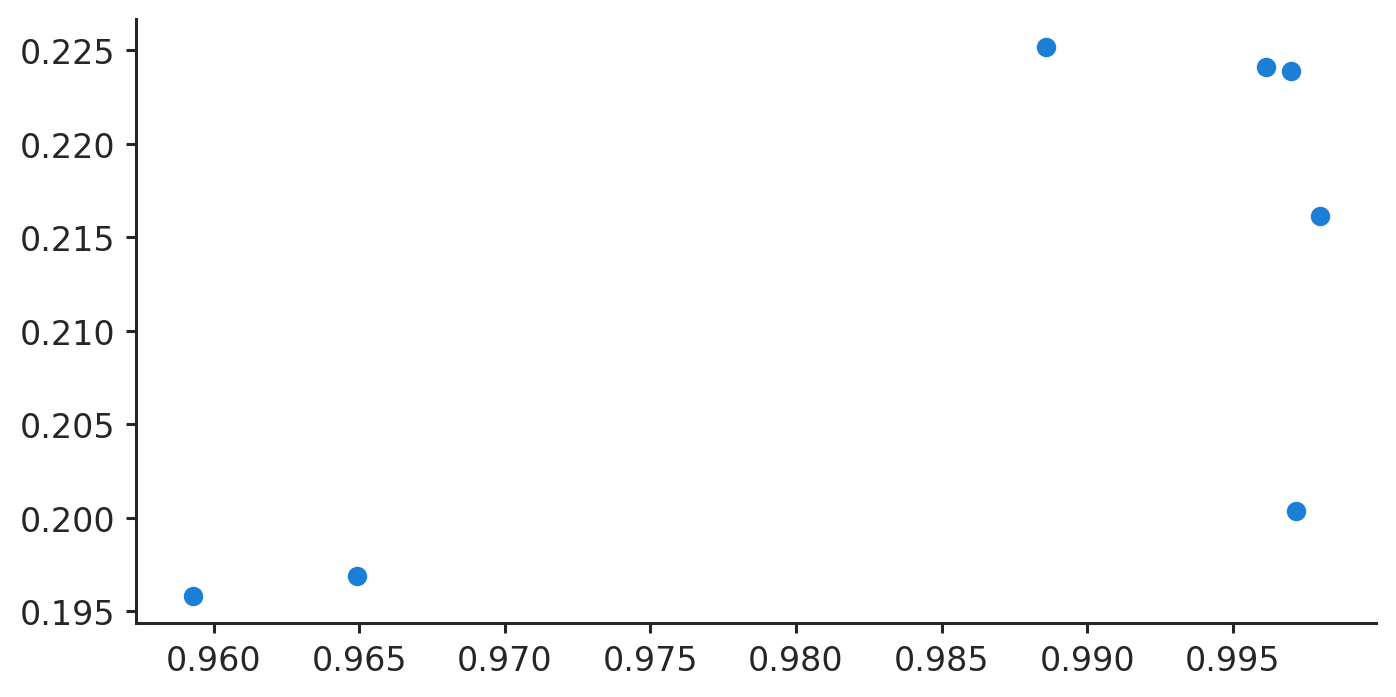

In [374]:
plt.scatter(vd_grp['y'], vd_grp['y_var'])

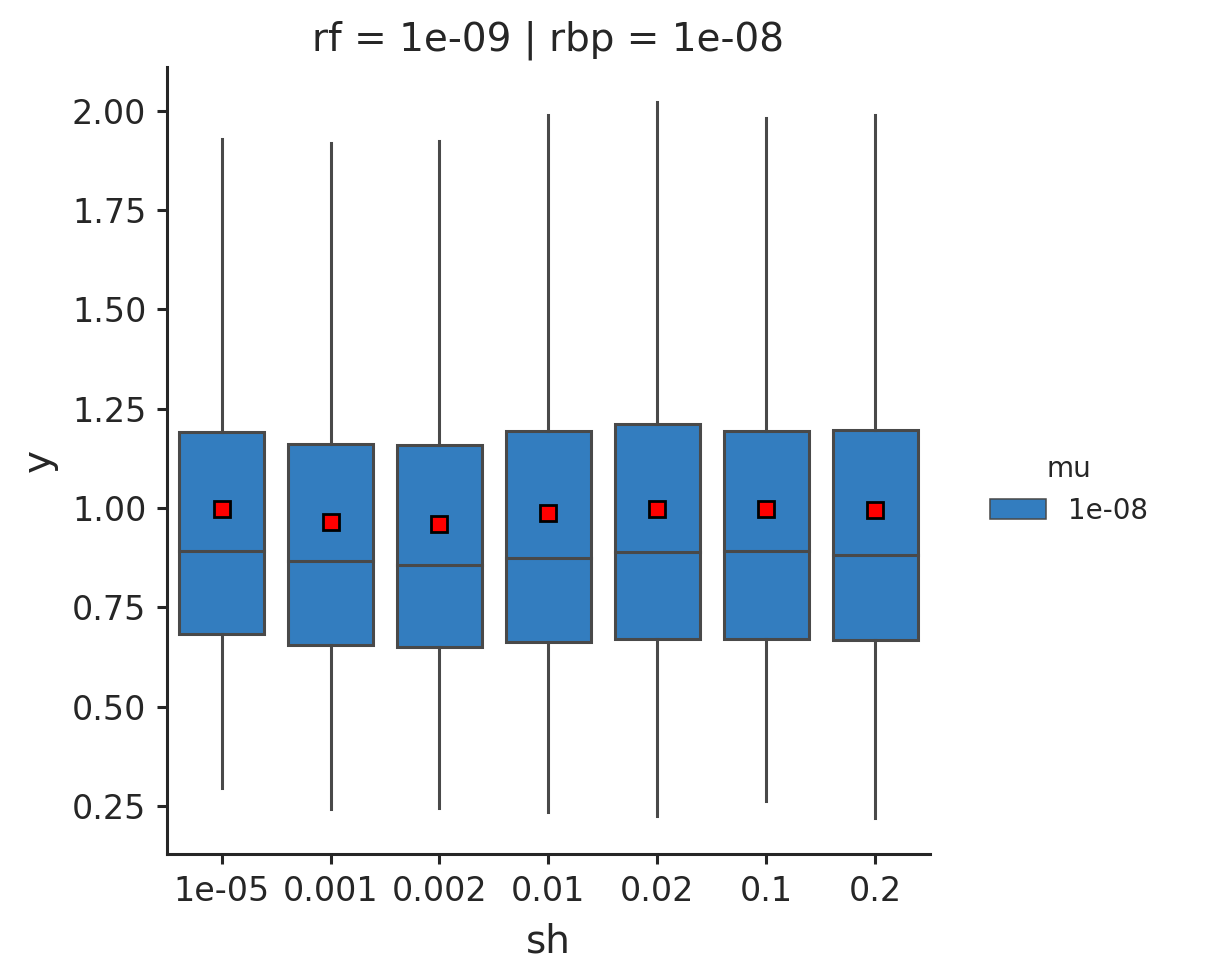

In [375]:
g = sns.catplot(x='sh', y='y', hue='mu', data=vd, col='rbp', row='rf',  kind="box", showmeans=True)

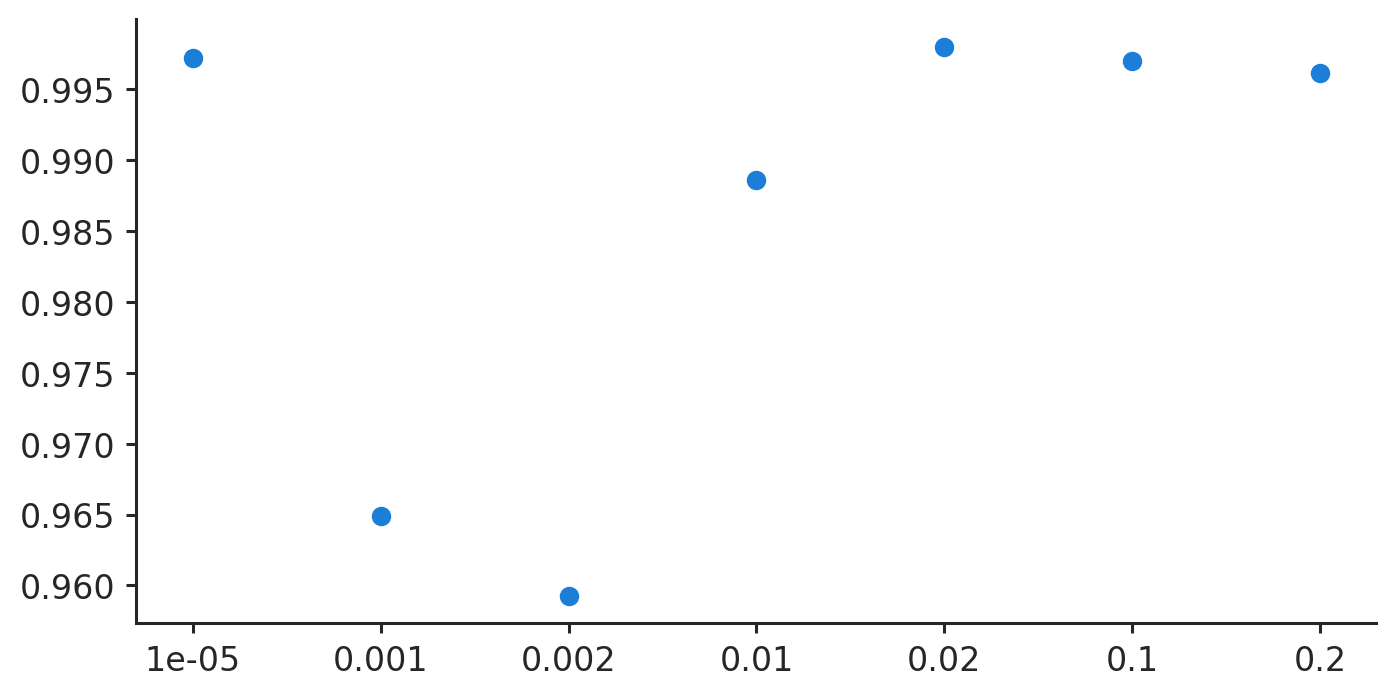

In [390]:
vd_grp_sort = vd_grp.sort_values(['sh'])

plt.scatter([str(v) for v in vd_grp_sort['sh']], vd_grp_sort['y'])

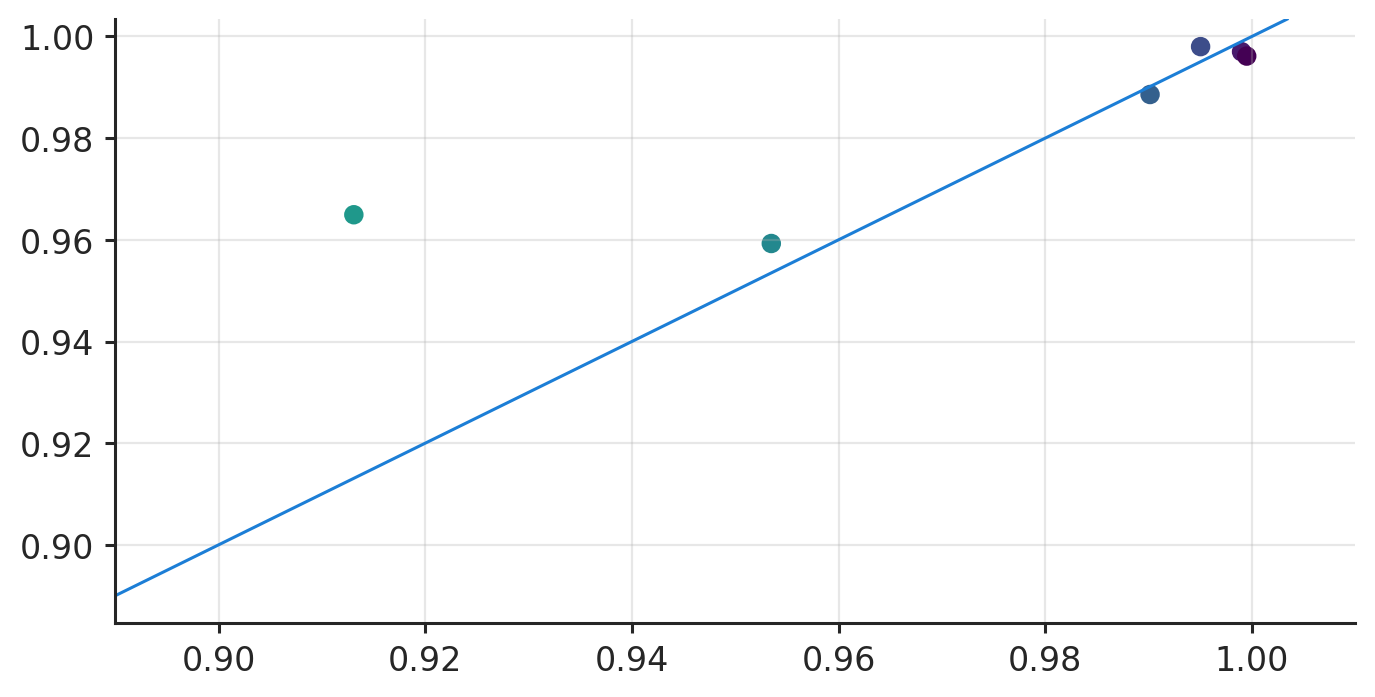

In [387]:
#plt.scatter(vd['theory'], vd['y'])
plt.scatter(vd_grp['theory'], vd_grp['y'], c=np.log10(vd_grp['mu']/vd_grp['sh']))
o = 0.890
plt.xlim(o, 1.01)
plt.axline((o, o), slope=1)
plt.grid(which='both')

## Data

In [43]:
FIT_DIR = '../data/slim_sims/bmap_hg38/fits/'

res = load_learnedfuncs_in_dir(FIT_DIR)
res.head()

key  n8  n4  n2  nx  \
0  bmap_hg38_0n16_0n8_0n4_0n2_2nx_Nonel2penalty_e...   0   0   0   2   
1  bmap_hg38_0n16_0n8_0n4_2n2_0nx_1e-08l2penalty_...   0   0   2   0   
2  bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-07l2penalty...  10   0   0   2   
3  bmap_hg38_0n16_0n8_0n4_0n2_2nx_1e-06l2penalty_...   0   0   0   2   
4  bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-07l2penalty...  10   0   0   2   

  l2penalty activ outactive    vsw  \
0      None   elu      relu   True   
1     1e-08   elu      relu   True   
2     1e-07   elu      relu  False   
3     1e-06   elu      relu   True   
4     1e-07   elu   sigmoid   True   

                                                bf       mse  
0  <bgspy.learn.LearnedB object at 0x7f08306001f0>  0.004747  
1  <bgspy.learn.LearnedB object at 0x7f083c0aa5b0>  0.004892  
2  <bgspy.learn.LearnedB object at 0x7f083c214940>  0.004367  
3  <bgspy.learn.LearnedB object at 0x7f083c214610>  0.004990  
4  <bgspy.learn.LearnedB object at 0x7f083c472b20>  0.004972

In [44]:
res['capacity'] = 8**res['n8'] + 4**res['n4'] + 2**res['n2'] + 5**res['nx'] 

In [45]:
res.sort_values(['capacity'])['key'].values[-5:]

array(['bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_reluoutactiv_Truevsw_fit_1rep',
       'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-05l2penalty_eluactiv_reluoutactiv_Truevsw_fit_2rep',
       'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_sigmoidoutactiv_Falsevsw_fit_1rep',
       'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_reluoutactiv_Truevsw_fit_0rep',
       'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-07l2penalty_eluactiv_reluoutactiv_Truevsw_fit_0rep'],
      dtype=object)

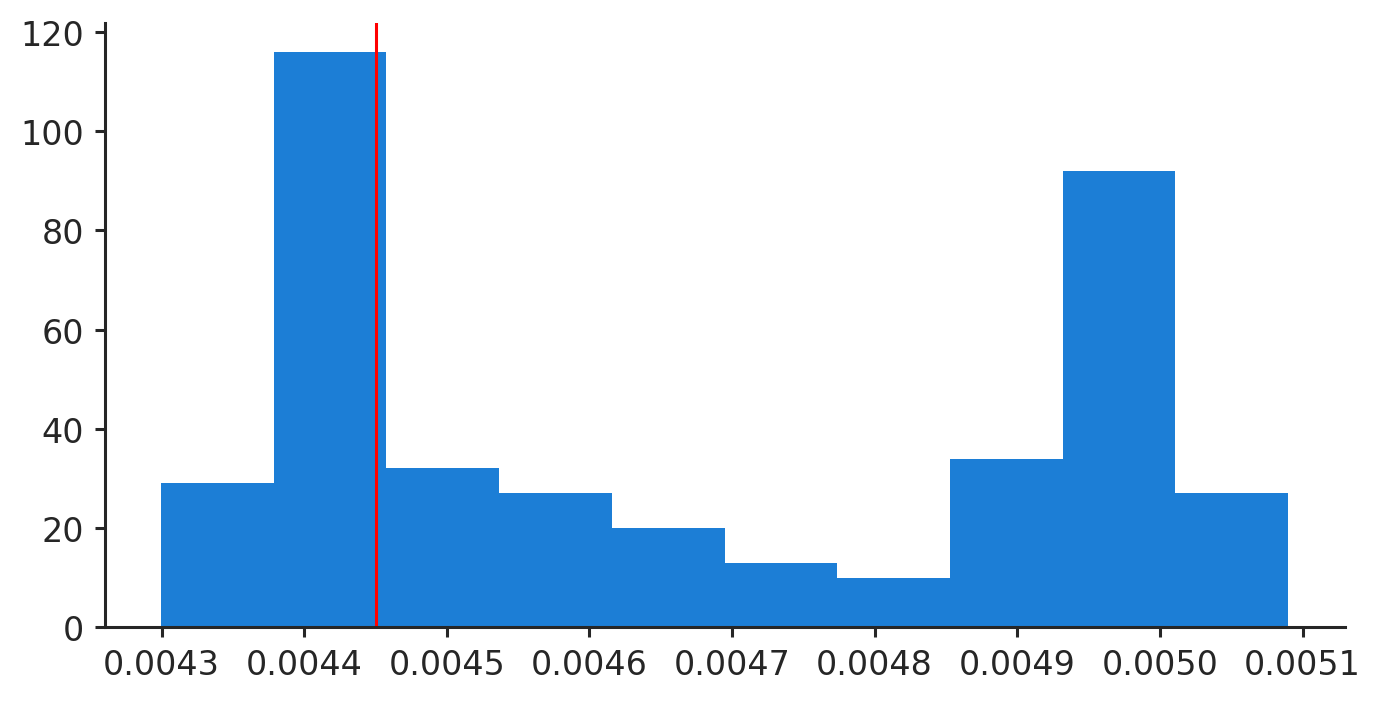

In [46]:
plt.hist(res['mse'])
plt.axvline(B_var_limit(1, R=50, N=1000, n=2000), c='r')

In [9]:
#res['binned_mse'] = [bf.func.test_mse() for bf in res['bf'].values]

In [10]:
#res['binned_mse'] = [bf.Bhat_mse(30) for bf in res['bf'].values]

In [11]:
#nreps = 50
#min_loss = B_var_limit(1, R=nreps, N=1000, n=2000)# 2/(nreps*9)
#res['overfit'] = res['mse'] < min_loss

In [13]:
B_var_limit(1, R=50, N=1000, n=2000), B_var_limit(1, R=50)

(array(0.00445056), array(0.00444444))

In [36]:
res['key'].values[:10]

array(['bmap_hg38_0n16_0n8_0n4_0n2_2nx_Nonel2penalty_eluactiv_reluoutactiv_Truevsw_fit_3rep',
       'bmap_hg38_0n16_0n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_reluoutactiv_Truevsw_fit_2rep',
       'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-07l2penalty_eluactiv_sigmoidoutactiv_Truevsw_fit_0rep',
       'bmap_hg38_0n16_0n8_0n4_0n2_1nx_1e-07l2penalty_eluactiv_sigmoidoutactiv_Truevsw_fit_3rep',
       'bmap_hg38_0n16_4n8_0n4_0n2_0nx_1e-08l2penalty_eluactiv_sigmoidoutactiv_Falsevsw_fit_2rep',
       'bmap_hg38_0n16_0n8_0n4_0n2_1nx_Nonel2penalty_eluactiv_sigmoidoutactiv_Truevsw_fit_1rep',
       'bmap_hg38_0n16_0n8_0n4_0n2_1nx_Nonel2penalty_eluactiv_reluoutactiv_Falsevsw_fit_3rep',
       'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_sigmoidoutactiv_Truevsw_fit_2rep',
       'bmap_hg38_0n16_0n8_0n4_0n2_1nx_1e-07l2penalty_eluactiv_sigmoidoutactiv_Truevsw_fit_1rep',
       'bmap_hg38_0n16_0n8_0n4_0n2_1nx_1e-07l2penalty_eluactiv_reluoutactiv_Truevsw_fit_3rep'],
      dtype=object)

In [28]:
bf.func.metadata

{'model': 'bgs_segment',
 'params': {'mu': {'dist': {'name': 'log10_uniform', 'low': -10, 'high': -7},
   'type': 'float'},
  'sh': {'dist': {'name': 'log10_uniform', 'low': -5, 'high': -1},
   'type': 'float'},
  'rf': {'dist': {'name': 'log10_uniform', 'low': -10, 'high': -0.824},
   'type': 'float'},
  'rbp': {'dist': {'name': 'log10_uniform', 'low': -12, 'high': -7},
   'type': 'float'},
  'L': {'dist': {'name': 'discrete_uniform', 'low': 0, 'high': 10000},
   'type': 'int'}},
 'yextra': array([[ 3.81962260e+03,  9.99930863e-01,  5.52568317e-09,
         -7.11359968e-05],
        [ 4.05215556e+03,  9.99879831e-01,  8.67377541e-09,
         -1.12471996e-04],
        [ 4.00426429e+03,  9.99904466e-01,  1.51541046e-08,
         -8.89559963e-05],
        ...,
        [ 4.02637588e+03,  9.99979457e-01,  4.35447373e-10,
         -2.08432006e-05],
        [ 3.84135637e+03,  9.99999334e-01,  1.62094631e-10,
          0.00000000e+00],
        [ 4.29067613e+03,  9.99997635e-01,  3.92864789e-

(<Figure size 2000x1400 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='actual', ylabel='predict'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

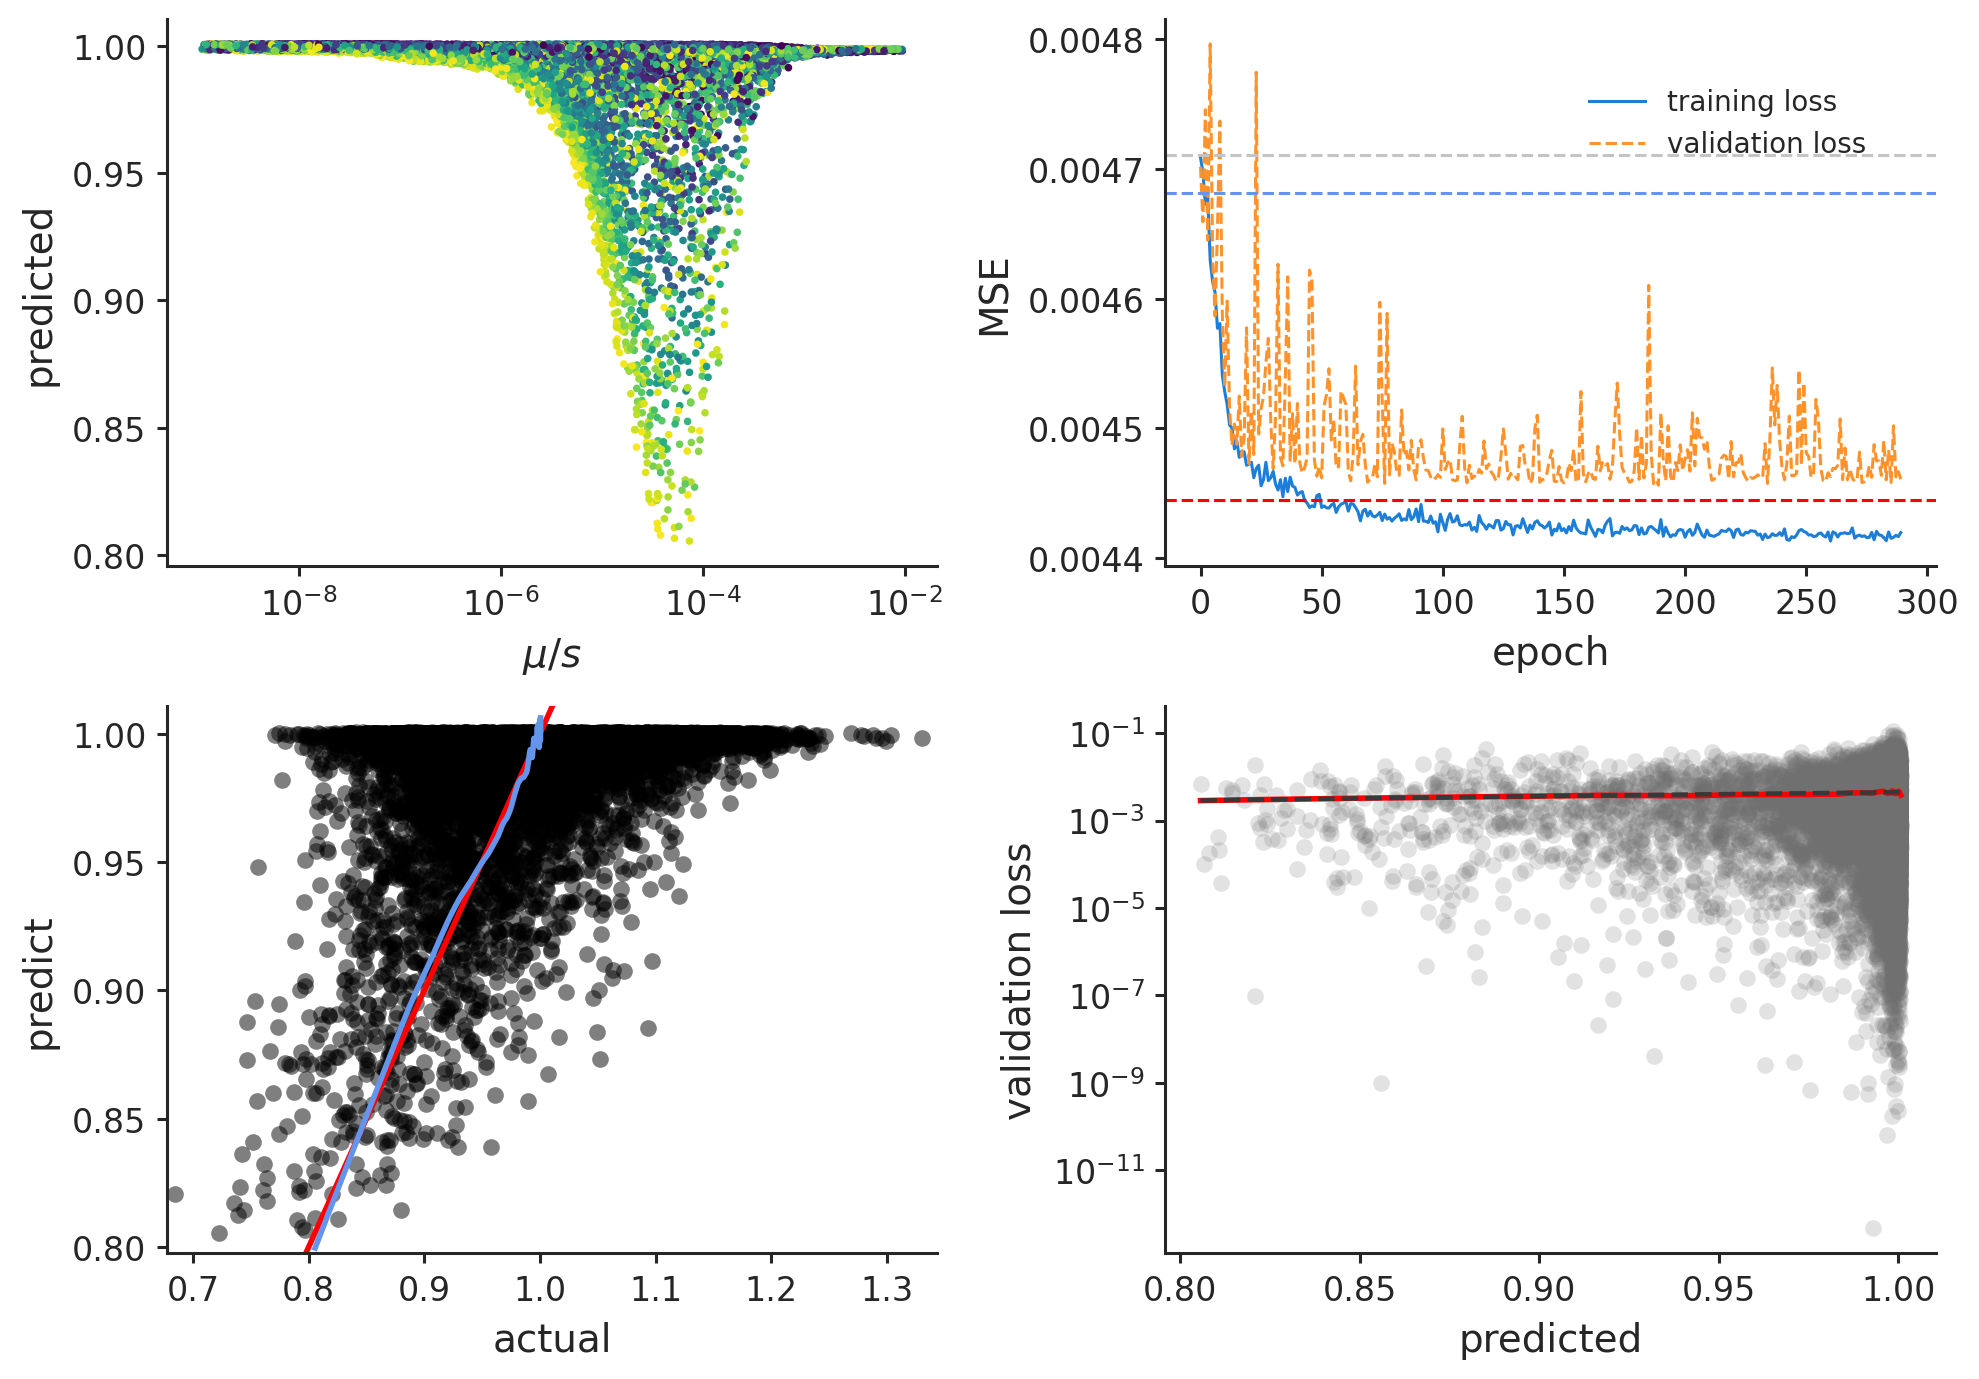

In [47]:
#bf = res.loc[res['key'] == 'bmap_hg38_reps_0n8_1n4_0n2_0nx_1e-06l2penalty_eluactiv_sigmoidoutactiv_fit_2rep']['bf'].values[0]

bf = res.loc[res['key'] == 'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-07l2penalty_eluactiv_reluoutactiv_Falsevsw_fit_0rep']['bf'].values[0]

b_learn_diagnostic_plot(bf, panel='predict', R=50,
                        bins=100,
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

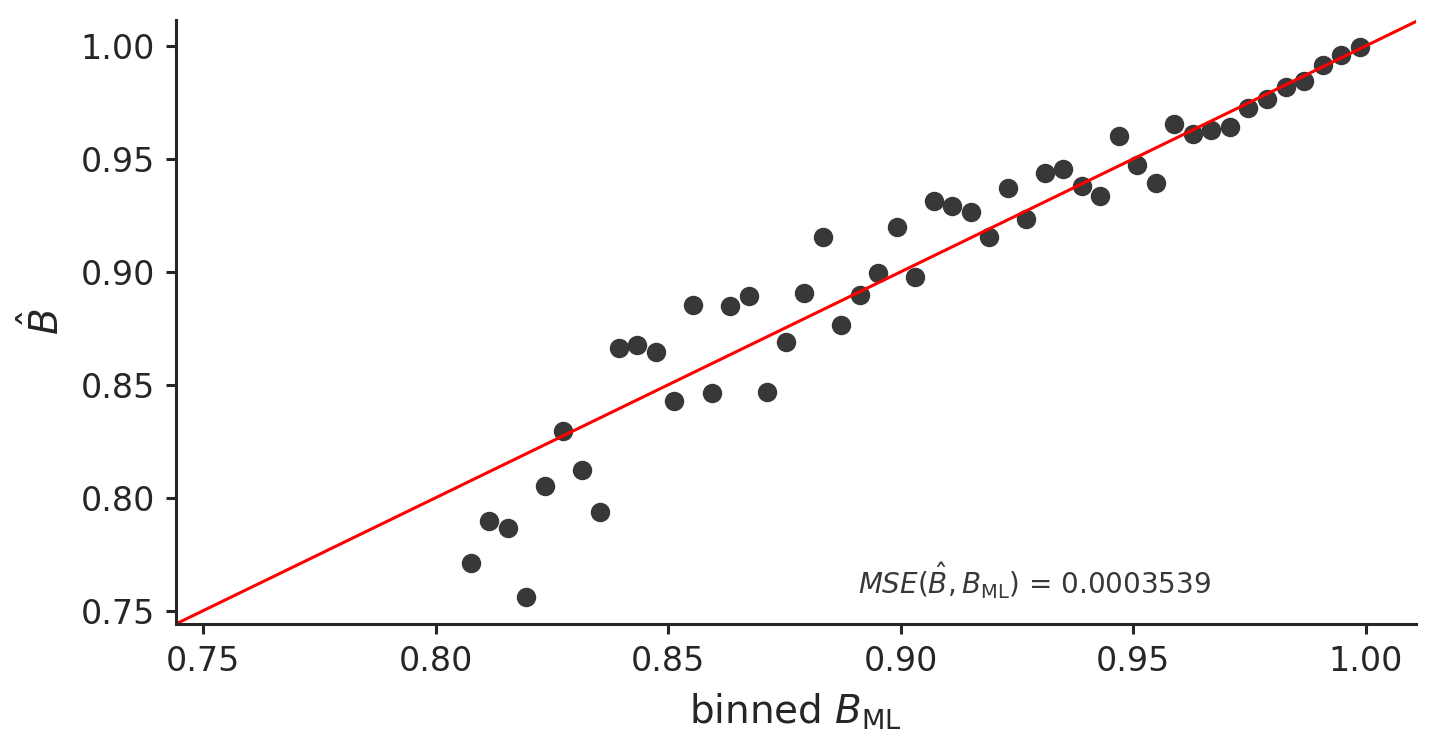

In [ ]:
bhat_plot(bf, 50)

## Learned and Empirical Marginals

In [156]:
f = LearnedFunction.load('../data/slim_sims/bmap_hg38_raw')

In [184]:
import statsmodels.api as sm

Text(0, 0.5, 'average sim B')

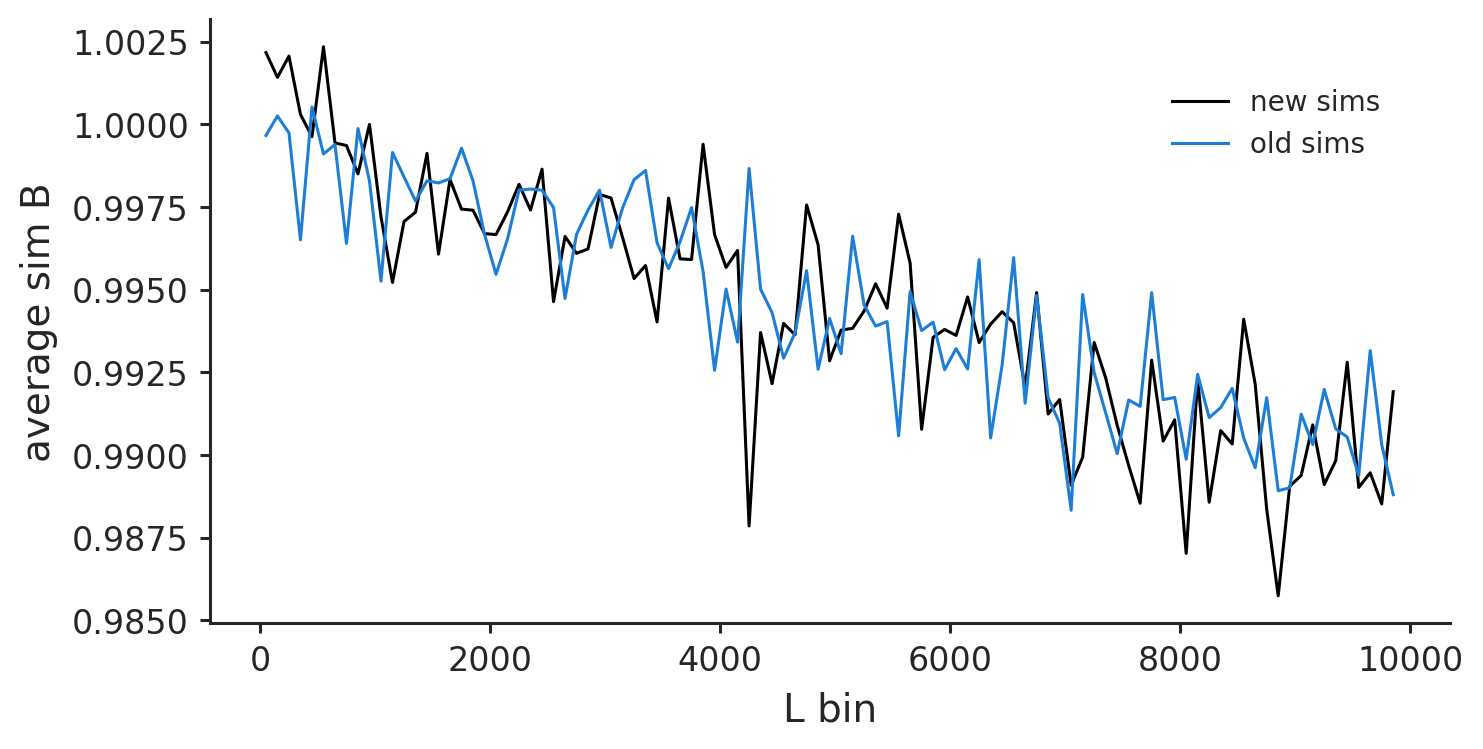

In [189]:
def Ldata(f, bins=100):
    X = pd.DataFrame(f.X, columns=('mu', 'sh', 'L', 'rbp', 'rf'))
    X['y'] = f.y
    X['L_bin'] = pd.cut(X['L'], np.arange(0, X['L'].max(), bins))
    grp = X.groupby(['L_bin']).mean().reset_index()
    mids = np.array([(x.left + x.right)/2 for x in grp['L_bin'].values])
    ybin = grp['y']
    return mids, ybin
plt.plot(*Ldata(f), c='k', label='new sims')
plt.plot(*Ldata(bfs[0].func), label='old sims')

plt.legend()
plt.xlabel('L bin')
plt.ylabel('average sim B')

In [267]:
bfs[0].func.features

{'mu': 0, 'sh': 1, 'L': 2, 'rbp': 3, 'rf': 4}

[]

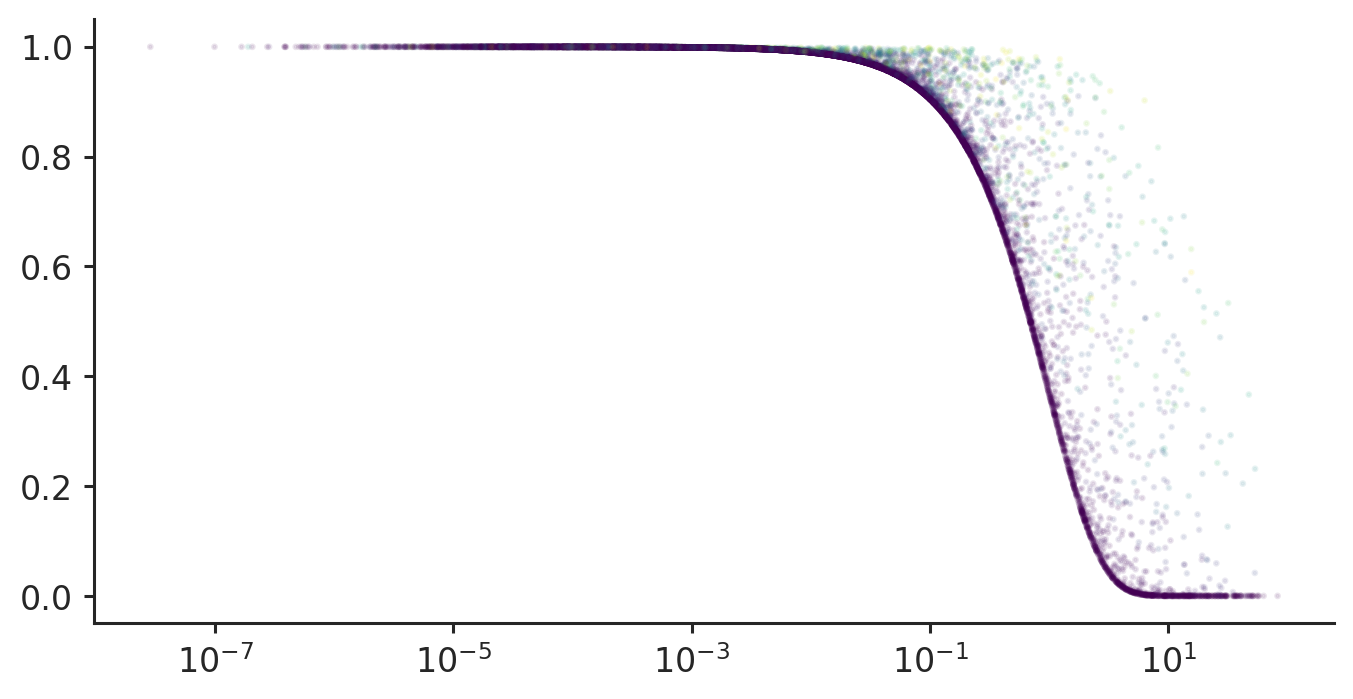

In [279]:
X = bfs[0].func.X
d = pd.DataFrame(X, columns=('mu', 'sh', 'L', 'rbp', 'rf'))
d['y'] = bfs[0].func.y
d['theory'] = bgs_segment(*X.T)
d['rate'] = d['mu'] / d['sh']

d = d.loc[d['rf'] < 1e-9, :]
plt.scatter(d['rate'] * d['L'], d['theory'], c=d['rbp'], s=2, alpha=0.1)
plt.semilogx()

In [260]:

d.loc[(d['y'] < 1) & ((d['sh'] < 1e-4))].mean()['y']

0.9484331080205842

In [262]:
d.loc[(d['y'] < 1) & ((d['sh'] < 1e-4))].mean()['theory']

0.7712214126728707

In [252]:
10**2 * 10 * 10 * 1000 / 1e6

10.0

In [52]:
bfs = [res.loc[res['key'] == f'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-07l2penalty_eluactiv_reluoutactiv_Falsevsw_fit_{i}rep']['bf'].values[0] for i in range(4)]

In [53]:
idx = (bf.func.X[:, 2] == 0) #& (bf.func.X[:, 0] < 1e-8)
bf.func.y[idx, ].mean(), len(idx)

(1.0039894088929238, 127177)

In [ ]:
marginal_plots(bfs, nbins=100)

## Variance Partitioning

/tmp/ipykernel_74323/3042821332.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(predict, var, alpha=1, s=3, c=np.log10(rate), label='yhat')


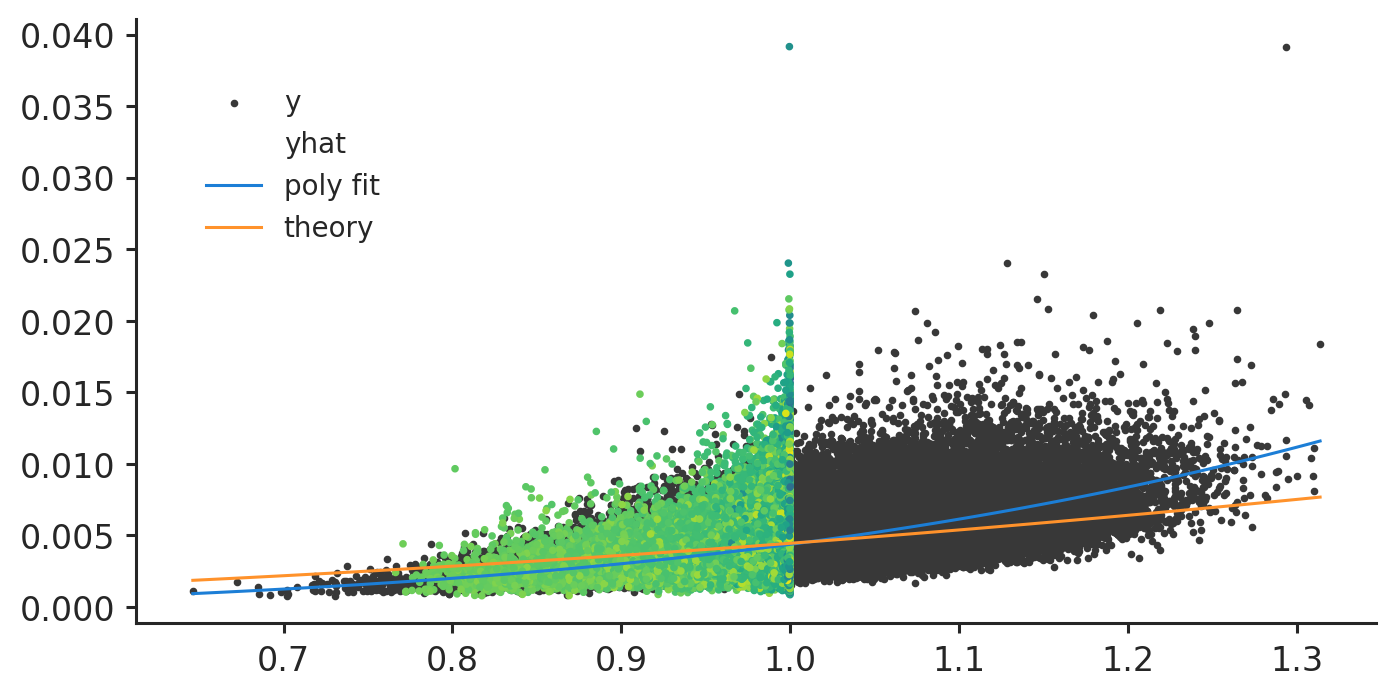

In [15]:
n = 50
R = 50
var = bfs[0].func.bhat_var / R
y = bfs[0].func.y
X = bfs[0].func.X
fig, ax = plt.subplots()

predict = bfs[0].func.predict(X)

rate = X[:, 2] * X[:, 0]/X[:, 1]
ax.scatter(y, var, alpha=1, s=3, c='0.22', label='y')
ax.scatter(predict, var, alpha=1, s=3, c=np.log10(rate), label='yhat')

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),                                           
                       ('regr', LinearRegression())])

x = np.linspace(y.min(), y.max(), 100)

#plt.plot(x, lowess(var, y.squeeze()).predict(x))

ax.plot(x, pipe.fit(y, var[:, None]).predict(x[:, None]), label='poly fit')


yy = 2/(9*R) * x**2
ax.plot(x, yy, label='theory')
ax.legend()

In [ ]:
#bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_sigmoidoutactiv_Falsevsw_fit_0rep

In [225]:
bfs = [res.loc[res['key'] == f'bmap_hg38_0n16_10n8_0n4_0n2_2nx_1e-06l2penalty_eluactiv_sigmoidoutactiv_Falsevsw_fit_{i}rep']['bf'].values[0] for i in range(4)]

In [226]:
bf = bfs[0]


(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(100, #manual_domains={'mu': (-7, -9, 101, True), 'sh': (-4.5, -1, 100, True)}, 
                                                                            fix_X={'rf': 1e-10,
                                                                                   'rbp': 1e-10,
                                                                                    'L': 5000})                                                                   

done.
313/313 [==============================] - 1s 1ms/step


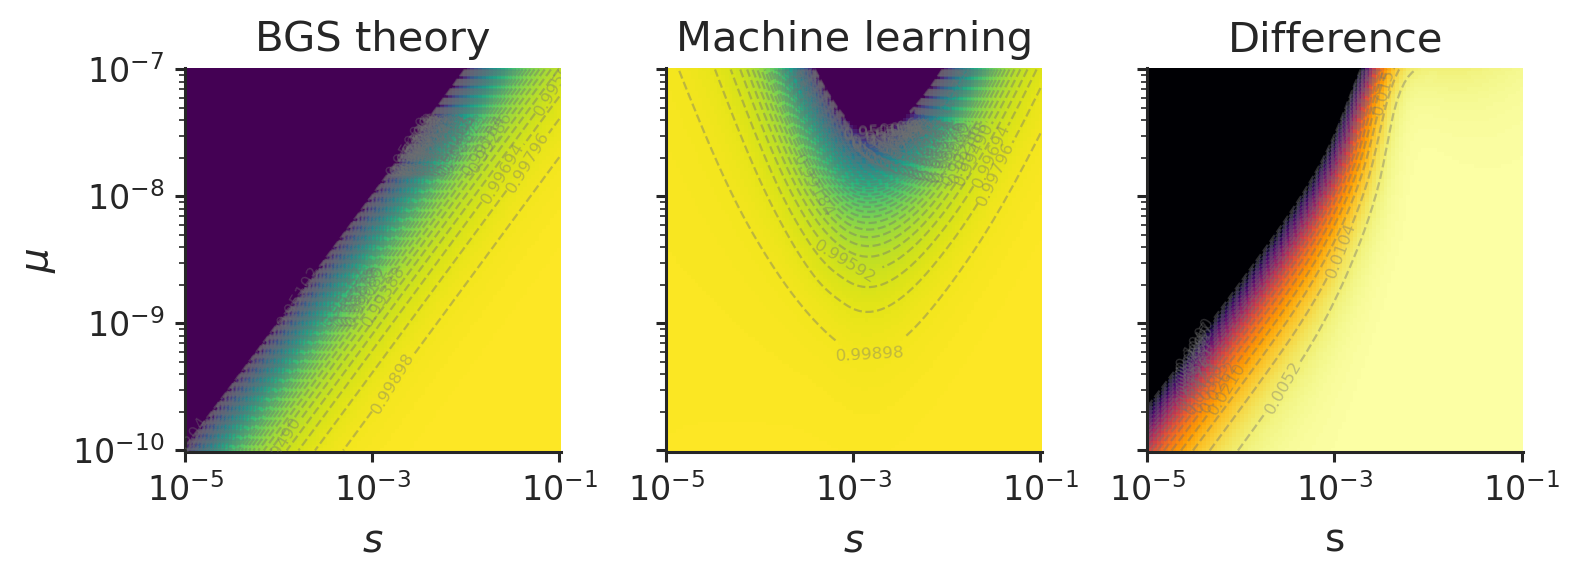

In [227]:
Zp = predict_grid.squeeze()
Z = bf.theory_B(X_mesh_raw).reshape(Zp.shape)

cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')

contmin, contmax = 0.95, 1
norm = mpl.colors.Normalize(vmin=contmin, vmax=contmax, clip=True)

fig, ax = plt.subplots(ncols=3, figsize=(8, 3), sharey=True)
ncontour = np.linspace(contmin, contmax, 50)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))



diff = Zp.T - Z.T
diffmin, diffmax = diff.min(), 0.1 #diff.max()
error_ncontour = np.linspace(diffmin, diffmax, 20)
error_cmap = mpl.cm.get_cmap('inferno_r', 1000)
error_norm = mpl.colors.Normalize(vmin=diffmin, vmax=diffmax, clip=True)

surface_plot(s_grid, mu_grid, diff, scale='loglog', ylabel="", xlabel="s", 
             ncontour=error_ncontour, cmap=error_cmap, norm=error_norm, figax=(fig, ax[2]))

plt.tight_layout()
ax[0].set_title("BGS theory")
ax[1].set_title("Machine learning")
ax[2].set_title("Difference")

plt.tight_layout()


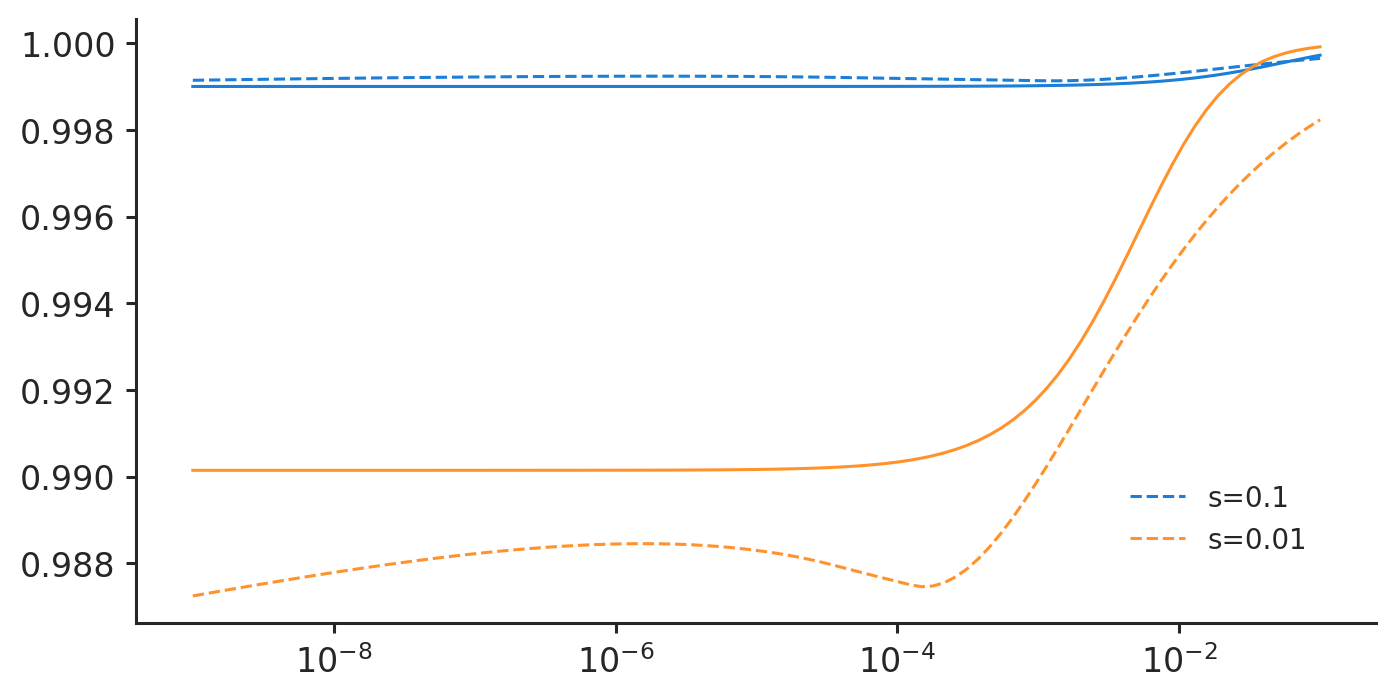

In [228]:
n = 100
rf = np.logspace(-9, -1, n)

mu = 1e-8
s = 1e-2
L = 10000
rbp = 1e-8

for s in [1e-1, 1e-2]:
    X = np.stack((np.repeat(mu, n), np.repeat(s, n), np.repeat(L, n), np.repeat(rbp, n), rf)).T
    Xh = np.copy(X)
    Xh[:, 4] = haldanes_mapfun(Xh[:, 4])

    b_theory = bgs_segment(*X.T)
    b_predict = bf.func.predict(X)

    lines = plt.plot(rf, b_predict, label=f's={s}', linestyle='dashed')
    plt.plot(rf, b_theory, c=lines[0].get_color())
    
plt.semilogx()
plt.legend()

In [229]:
bf.func.metadata['yextra']

array([[ 3.81962260e+03,  9.99930863e-01,  5.52568317e-09,
        -7.11359968e-05],
       [ 4.05215556e+03,  9.99879831e-01,  8.67377541e-09,
        -1.12471996e-04],
       [ 4.00426429e+03,  9.99904466e-01,  1.51541046e-08,
        -8.89559963e-05],
       ...,
       [ 4.02637588e+03,  9.99979457e-01,  4.35447373e-10,
        -2.08432006e-05],
       [ 3.84135637e+03,  9.99999334e-01,  1.62094631e-10,
         0.00000000e+00],
       [ 4.29067613e+03,  9.99997635e-01,  3.92864789e-09,
         0.00000000e+00]])

[]

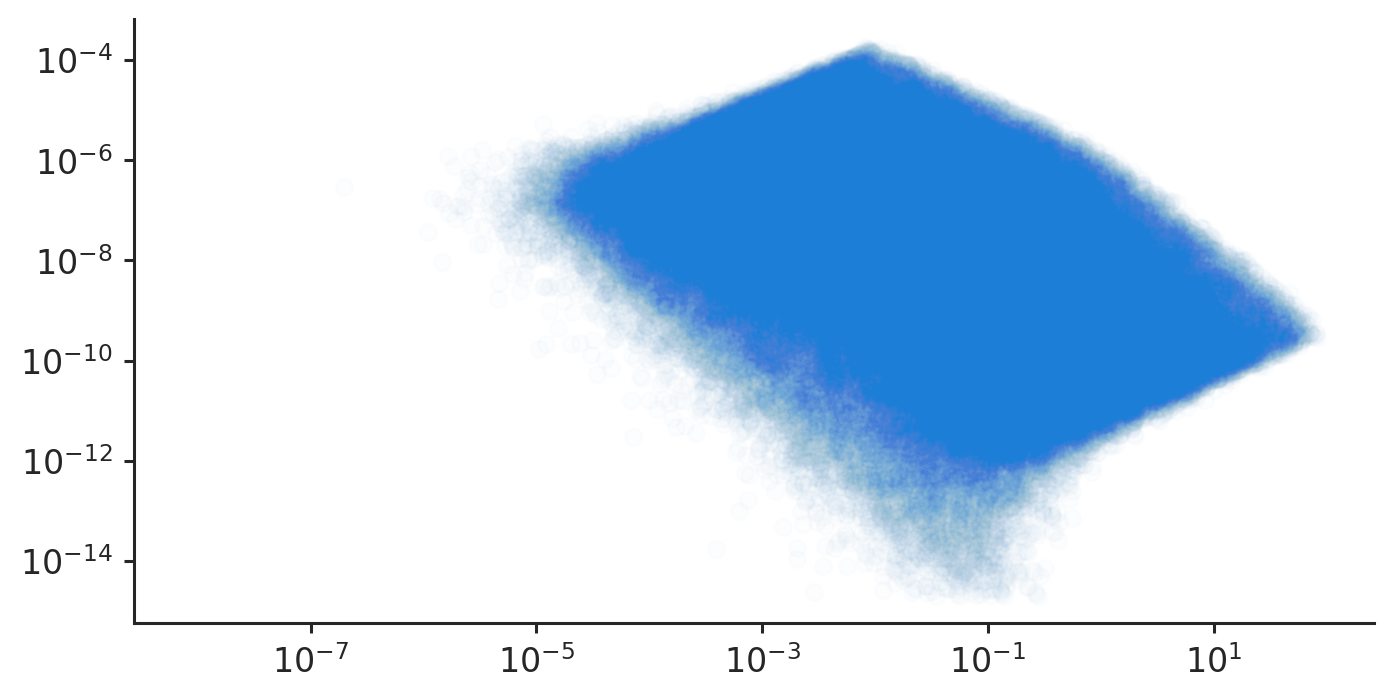

In [230]:
import seaborn as sns

d = pd.DataFrame(bf.func.metadata['yextra'], columns=('pi', 'Ef', 'Vf', 'load'))
d['mu'] = bf.func.X[:, 0]
d['s'] = bf.func.X[:, 1]
d['L'] = bf.func.X[:, 2]
d['rbp'] = bf.func.X[:, 3]
d['rf'] = bf.func.X[:, 4]


#sns.boxplot(x="Vf", y="s", data=d)

rate = d['L']*d['mu']/d['s']
plt.scatter(rate, d['Vf'], alpha=0.01)
plt.loglog()

(0.98, 1.0)

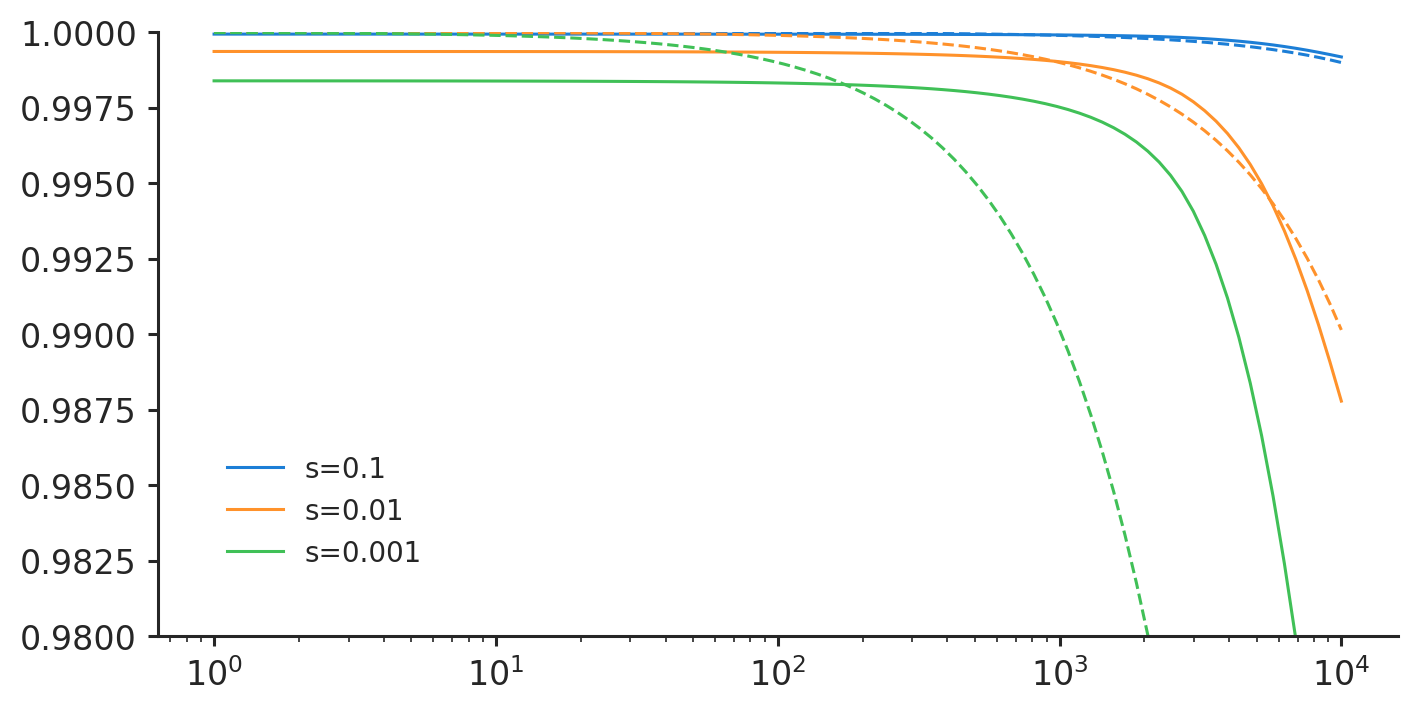

In [231]:
n = 100
L = np.logspace(0, 4, n)

mu = 1e-8
s = 1e-2
rf = 1e-8
rbp = 1e-8

for s in [1e-1, 1e-2, 1e-3]:
    X = np.stack((np.repeat(mu, n), np.repeat(s, n), L, np.repeat(rbp, n), np.repeat(rf, n))).T
    Xh = np.copy(X)
    Xh[:, 4] = haldanes_mapfun(Xh[:, 4])

    b_theory = bgs_segment(*X.T)
    b_predict = bf.func.predict(X)

    lines = plt.plot(L, b_predict, label=f's={s}')
    plt.plot(L, b_theory, c=lines[0].get_color(), linestyle='dashed')
    
    
plt.semilogx()
plt.legend()
plt.ylim(0.98, 1)

done.
313/313 [==============================] - 1s 1ms/step


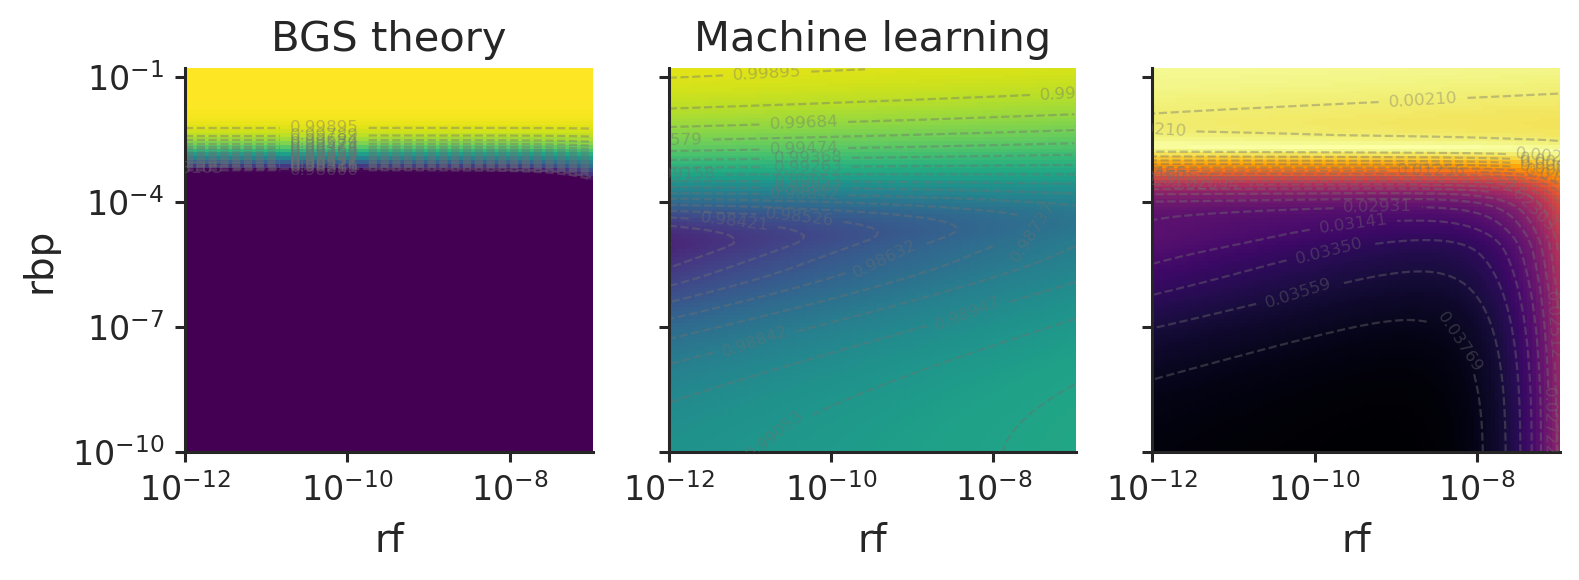

In [232]:
bf = bfs[1]


(mu_grid, s_grid, L_grid, rbp_grid, rf_grid), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(100,
                                                                              fix_X={'sh': 1e-3,
                                                                                    'mu': 1e-8,
                                                                                    'L': 5000})

Zp = predict_grid.squeeze()
Z = bf.theory_B(X_mesh_raw).reshape(Zp.shape)

cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')

contmin, contmax = 0.98, 1
norm = mpl.colors.Normalize(vmin=contmin, vmax=contmax, clip=True)

fig, ax = plt.subplots(ncols=3, figsize=(8, 3), sharey=True)
ncontour = np.linspace(contmin, contmax, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(rbp_grid, rf_grid, Z.T, scale='loglog', ylabel="rbp", xlabel="rf",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(rbp_grid, rf_grid, Zp.T, scale='loglog', ylabel="", xlabel="rf",
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1])) 



diff = (np.abs(Z.T-Zp.T))
error_ncontour = np.linspace(diff.min(), diff.max(), 20)
error_cmap = mpl.cm.get_cmap('inferno_r', 1000)
error_cmap.set_under('0.22')
surface_plot(rbp_grid, rf_grid, diff, scale='loglog', ylabel="", xlabel="rf", 
             ncontour=error_ncontour, cmap=error_cmap, figax=(fig, ax[2]))

plt.tight_layout()
ax[0].set_title("BGS theory")
ax[1].set_title("Machine learning")

plt.tight_layout()


done.
313/313 [==============================] - 1s 1ms/step


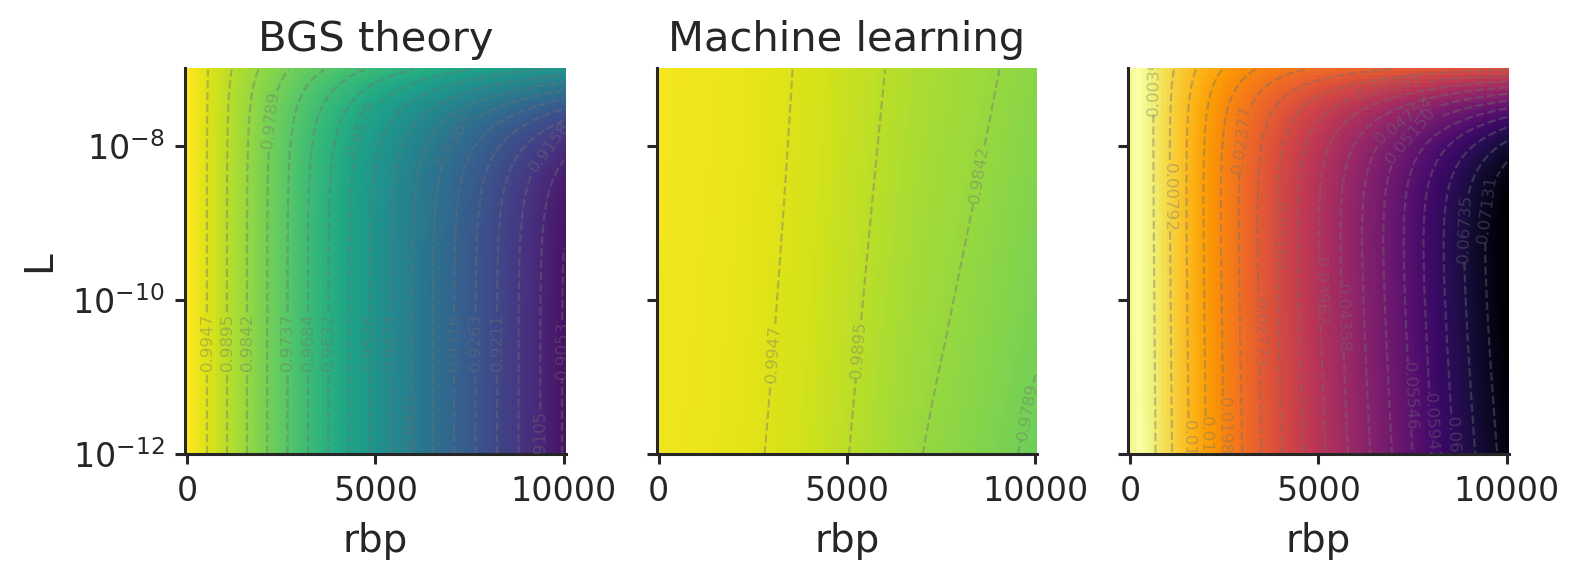

In [233]:
bf = bfs[1]


(mu_grid, s_grid, L_grid, rbp_grid, rf_grid), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(100,
                                                                              fix_X={'sh': 1e-3,
                                                                                     'rf': 1e-9,
                                                                                     'mu': 1e-8})

Zp = predict_grid.squeeze()
Z = bf.theory_B(X_mesh_raw).reshape(Zp.shape)

cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')

contmin, contmax = 0.9, 1
norm = mpl.colors.Normalize(vmin=contmin, vmax=contmax, clip=True)

fig, ax = plt.subplots(ncols=3, figsize=(8, 3), sharey=True)
ncontour = np.linspace(contmin, contmax, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(L_grid, rbp_grid, Z.T, scale='semilogy', ylabel="L", xlabel="rbp",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(L_grid, rbp_grid, Zp.T, scale='semilogy', ylabel="", xlabel="rbp",
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1])) 



diff = (np.abs(Z.T-Zp.T))
error_ncontour = np.linspace(diff.min(), diff.max(), 20)
error_cmap = mpl.cm.get_cmap('inferno_r', 1000)
error_cmap.set_under('0.22')
surface_plot(L_grid, rbp_grid, diff, scale='semilogy', ylabel="", xlabel="rbp", 
             ncontour=error_ncontour, cmap=error_cmap, figax=(fig, ax[2]))

plt.tight_layout()
ax[0].set_title("BGS theory")
ax[1].set_title("Machine learning")

plt.tight_layout()


In [81]:
bf = bfs[1]


(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(100, #manual_domains={'mu': (-7, -9, 101, True), 'sh': (-4.5, -1, 100, True)}, 
                                                                            fix_X={'rf': 0.1,
                                                                                   'rbp': 1e-10,
                                                                                    'L': 1})                                                                   

done.
313/313 [==============================] - 1s 1ms/step


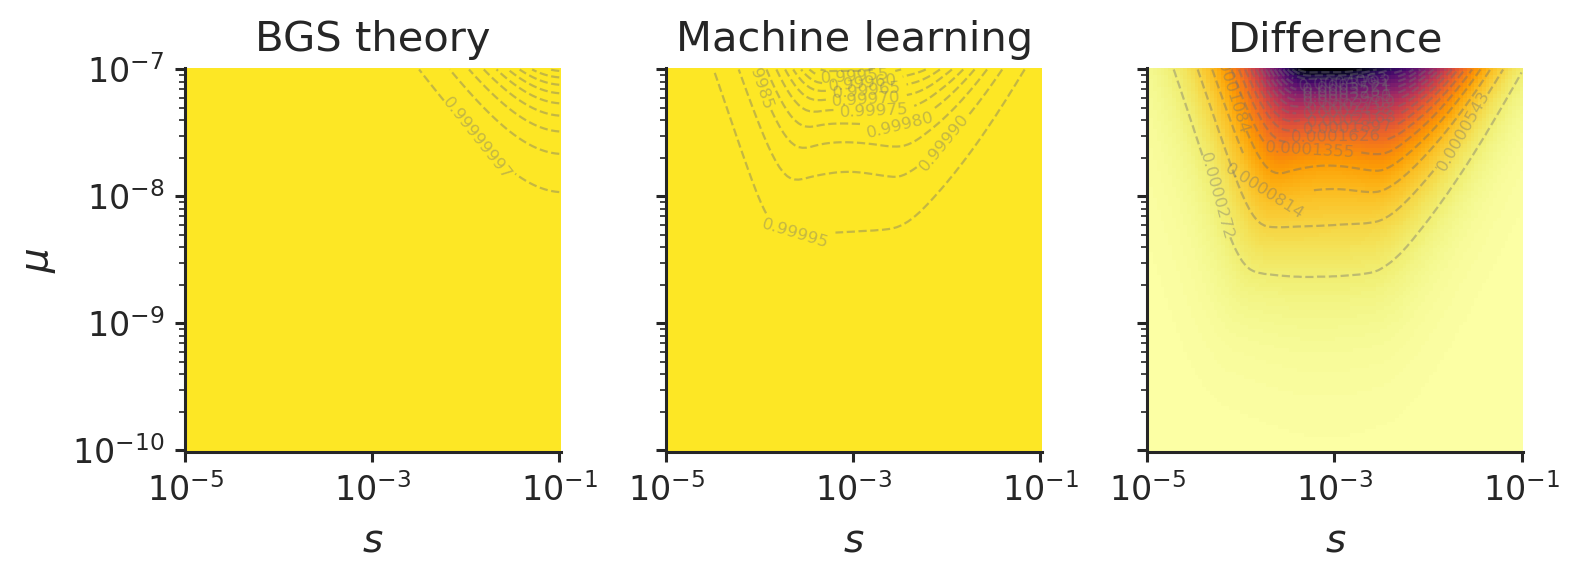

In [83]:
Zp = predict_grid.squeeze()
Z = bf.theory_B(X_mesh_raw).reshape(Zp.shape)

cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')
norm = mpl.colors.Normalize(vmin=0.9, vmax=1, clip=True)

fig, ax = plt.subplots(ncols=3, figsize=(8, 3), sharey=True)
ncontour = 10#np.linspace(0, 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))


diff = (np.abs(Z.T-Zp.T))
error_ncontour = np.linspace(diff.min(), diff.max(), 20)
error_cmap = mpl.cm.get_cmap('inferno_r', 1000)
error_cmap.set_under('0.22')
surface_plot(s_grid, mu_grid, diff, scale='loglog', ylabel="", xlabel="$s$", 
             ncontour=error_ncontour, cmap=error_cmap, figax=(fig, ax[2]))
plt.tight_layout()
ax[0].set_title("BGS theory")
ax[1].set_title("Machine learning")
ax[2].set_title("Difference")
plt.tight_layout()
#fig.savefig('/home/vsb/comparison.pdf')

(<Figure size 1600x800 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'mu'}>,
         <AxesSubplot:title={'center':'sh'}>,
         <AxesSubplot:title={'center':'L'}>],
        [<AxesSubplot:title={'center':'rbp'}>,
         <AxesSubplot:title={'center':'rf'}>, <AxesSubplot:>]],
       dtype=object))

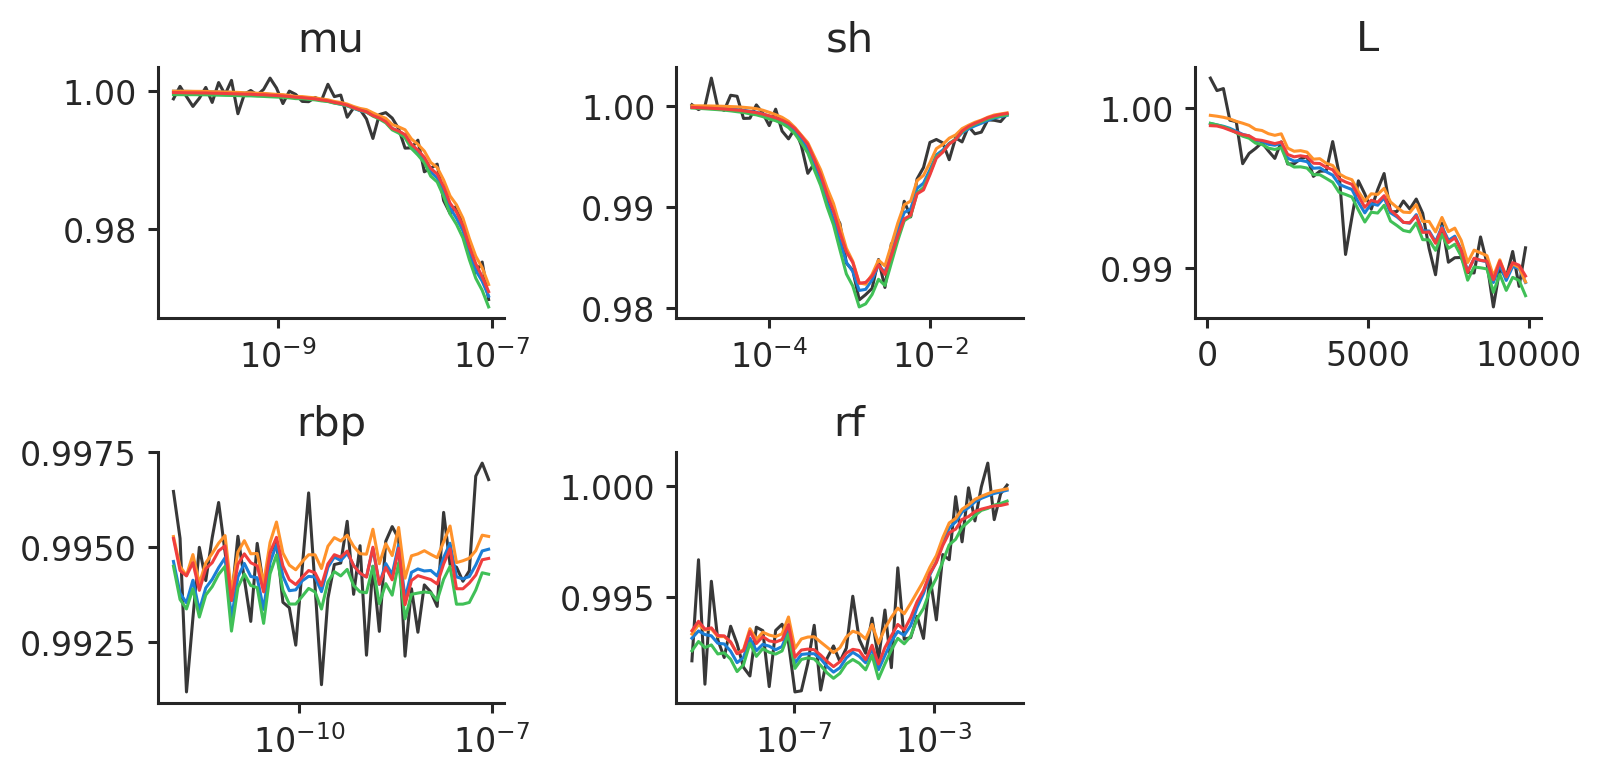

In [85]:
marginal_plots(bfs, 50)

/tmp/ipykernel_74323/3798582777.py:9: RuntimeWarning: divide by zero encountered in log10
  rate = np.log10(mu / s)


Text(0.5, 0, '$\\log_{10}(\\hat{B})$')

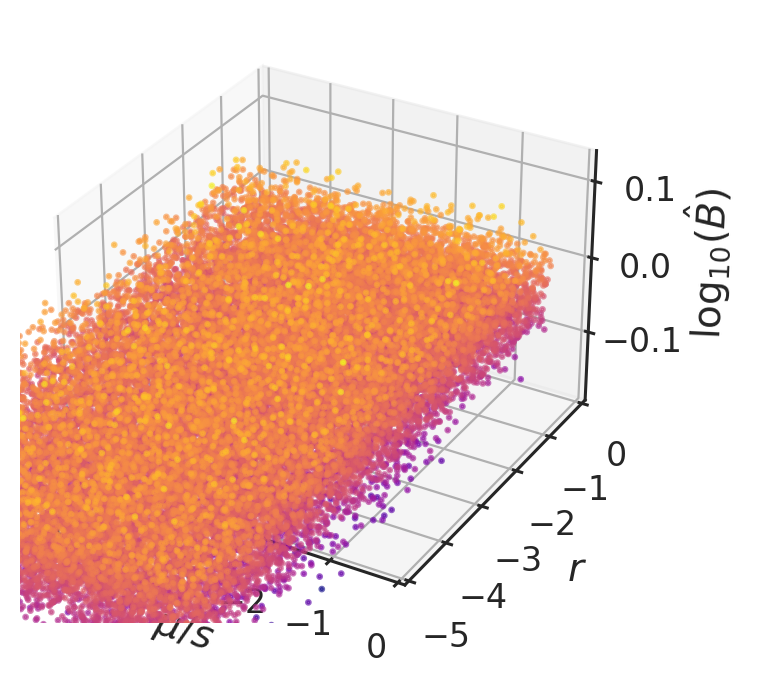

In [113]:
plt.rcParams['text.usetex'] = False

X = bf.func.X_test_raw
y = bf.func.y_test_raw
mu = X[:, 0] * X[:, 2]
rf = X[:, 4]
s = X[:, 1]
 
rate = np.log10(mu / s)

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = (rate > -5) & (rate < 0)

ax.scatter(rate[idx], np.log10(rf[idx]), np.log10(y[idx]), s=2,
           c=np.log10(y[idx]), alpha=0.6, cmap='plasma')


ax.set_xlim(-5, 0)
ax.set_ylim(-5, 0)
ax.set_xlabel('$\\mu/s$')
ax.set_ylabel('$r$')
ax.set_zlabel('$\\log_{10}(\\hat{B})$')
#ax.tick_params(axis='both', which='major', labelsize=6)
#ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])
#ax.set_yticks(np.linspace(-8, -6, 3))
#ax.set_yticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_yticks()])
#fig.savefig('/home/vsb/B3D.pdf')

## Debugging Predictions

In [ ]:
a = np.load('/home/vsb/projects/bprime/data/dnnb/bpreds/hg38_chr10_7200_0_8993_bmap_hg38_reps_0n8_0n4_1n2_0nx_eluactiv_sigmoidoutactiv_fit_0rep_0.npy')

In [ ]:
b = np.load('/home/vsb/projects/bprime/data/dnnb/xps/hg38_chr10_7200_0_8993_110.npy')

In [ ]:
b

array([[1.00000000e-09, 1.00000000e-05, 1.00000000e+03, 1.24458999e-09,
        1.38686334e-04],
       [1.00000000e-09, 1.00000000e-05, 1.00000000e+03, 1.24458999e-09,
        1.37643817e-04],
       [1.00000000e-09, 1.00000000e-05, 1.00000000e+03, 1.24458999e-09,
        1.36592936e-04],
       ...,
       [1.00000000e-07, 1.00000000e-01, 1.00000000e+03, 1.21458301e-08,
        9.85701427e-02],
       [1.00000000e-07, 1.00000000e-01, 1.00000000e+03, 1.21458301e-08,
        9.85249139e-02],
       [1.00000000e-07, 1.00000000e-01, 1.00000000e+03, 1.21458301e-08,
        9.84564072e-02]])

In [531]:
b.shape

(134895, 5)

In [533]:
z = b[:, 4]
z[z > 0].min()

1.3175402931330155e-07

(array([29940.,  6840., 16440., 16545., 11280.,  6345.,  6105., 16545.,
         8565., 16290.]),
 array([0.        , 0.00985701, 0.01971403, 0.02957104, 0.03942806,
        0.04928507, 0.05914209, 0.0689991 , 0.07885611, 0.08871313,
        0.09857014]),
 <BarContainer object of 10 artists>)

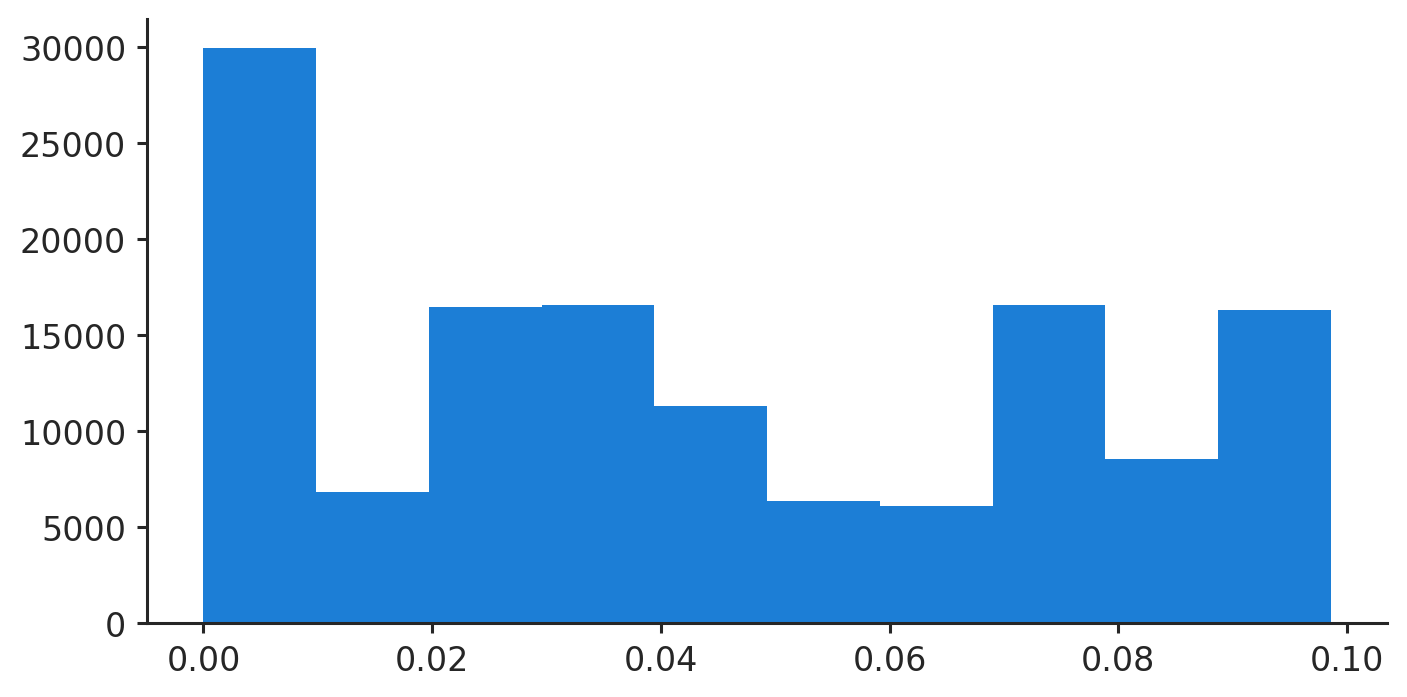

In [532]:
plt.hist(b[:, 4])

Text(0, 0.5, 'DNN')

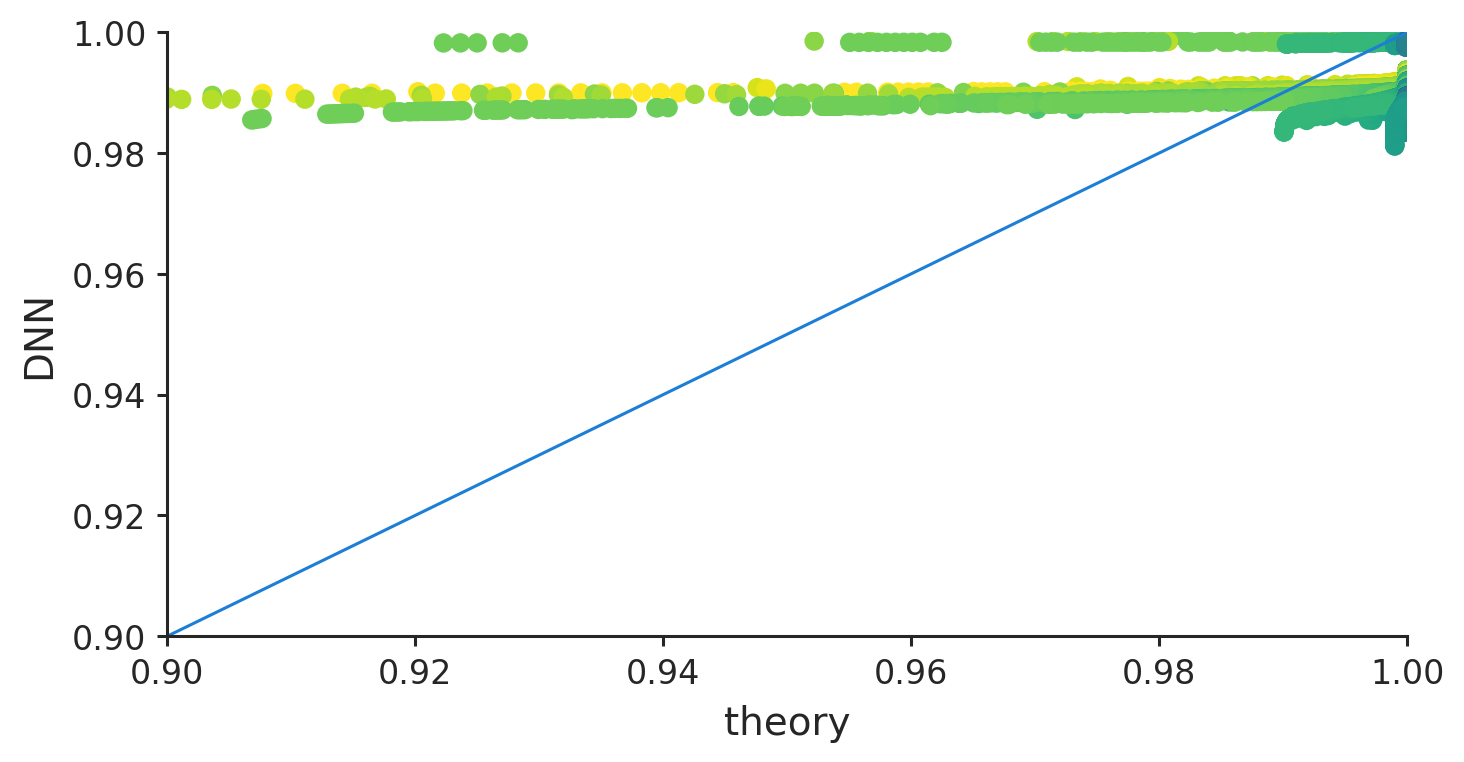

In [481]:
plt.scatter(bgs_segment(*b.T), a, c=np.log10(b[:, 2] * b[:, 0] / b[:, 1]))
plt.axline((0.94, 0.94), slope=1)
plt.xlim(0.90, 1)
plt.ylim(0.90, 1)
plt.xlabel('theory')
plt.ylabel('DNN')

In [433]:
thy = bf.func.predict(b)

(0.96, 1.0)

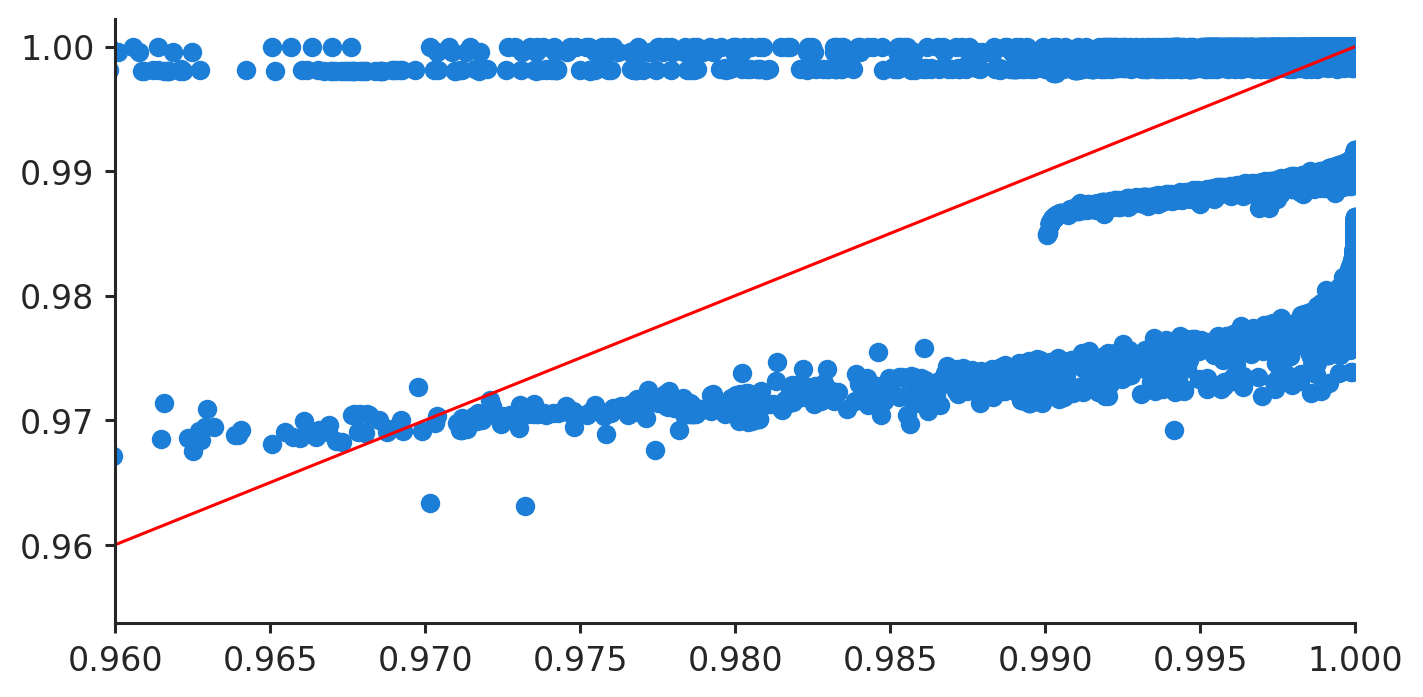

In [435]:
plt.scatter(bgs_segment(*b.T), thy)
o = 0.96
plt.axline((o, o), slope=1, c='r')
plt.xlim(o, 1)
plt.xlim(o, 1)

In [107]:
error = (bf.func.y_train-bf.func.predict(bf.func.X_train_raw)**2)

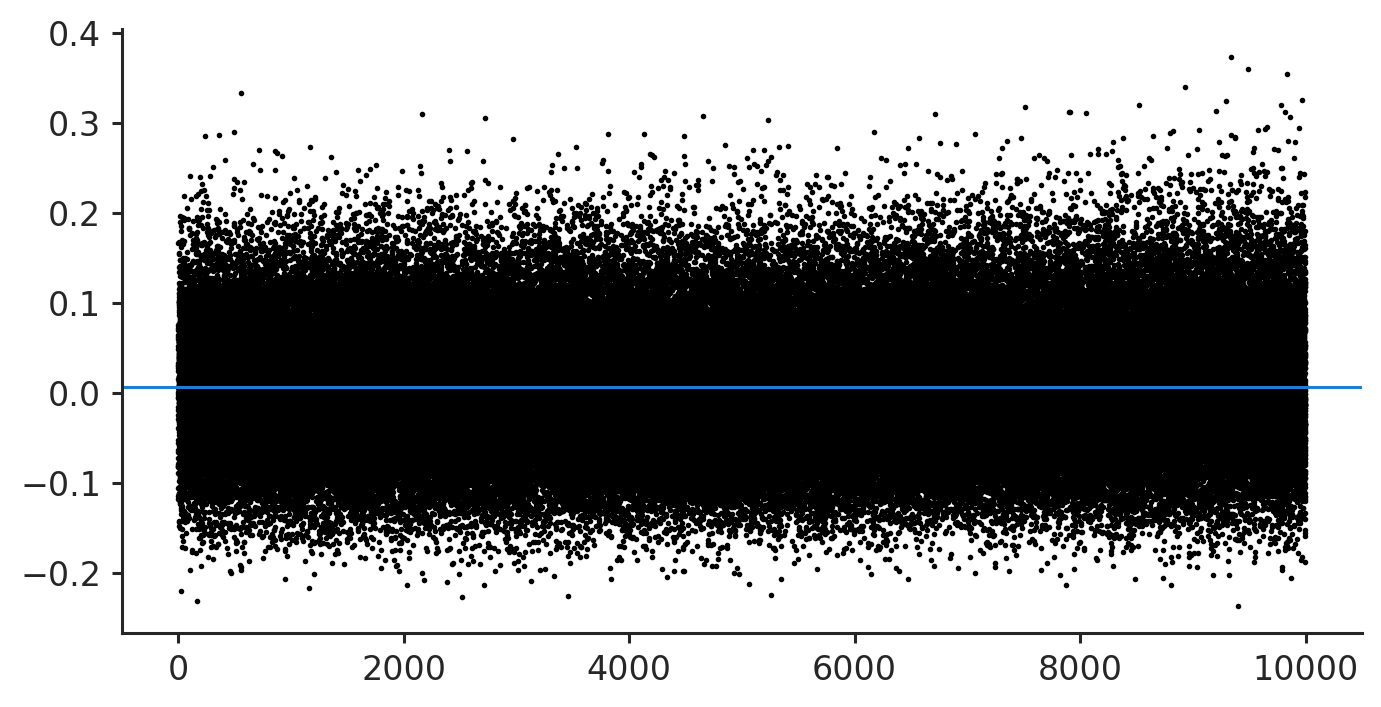

In [112]:
plt.scatter(bf.func.X_train_raw[:, 2], error, s=1, c='k')
plt.axhline(np.mean(error))

done.
32/32 [==============================] - 0s 657us/step
done.
32/32 [==============================] - 0s 692us/step
done.
32/32 [==============================] - 0s 678us/step
done.
32/32 [==============================] - 0s 664us/step


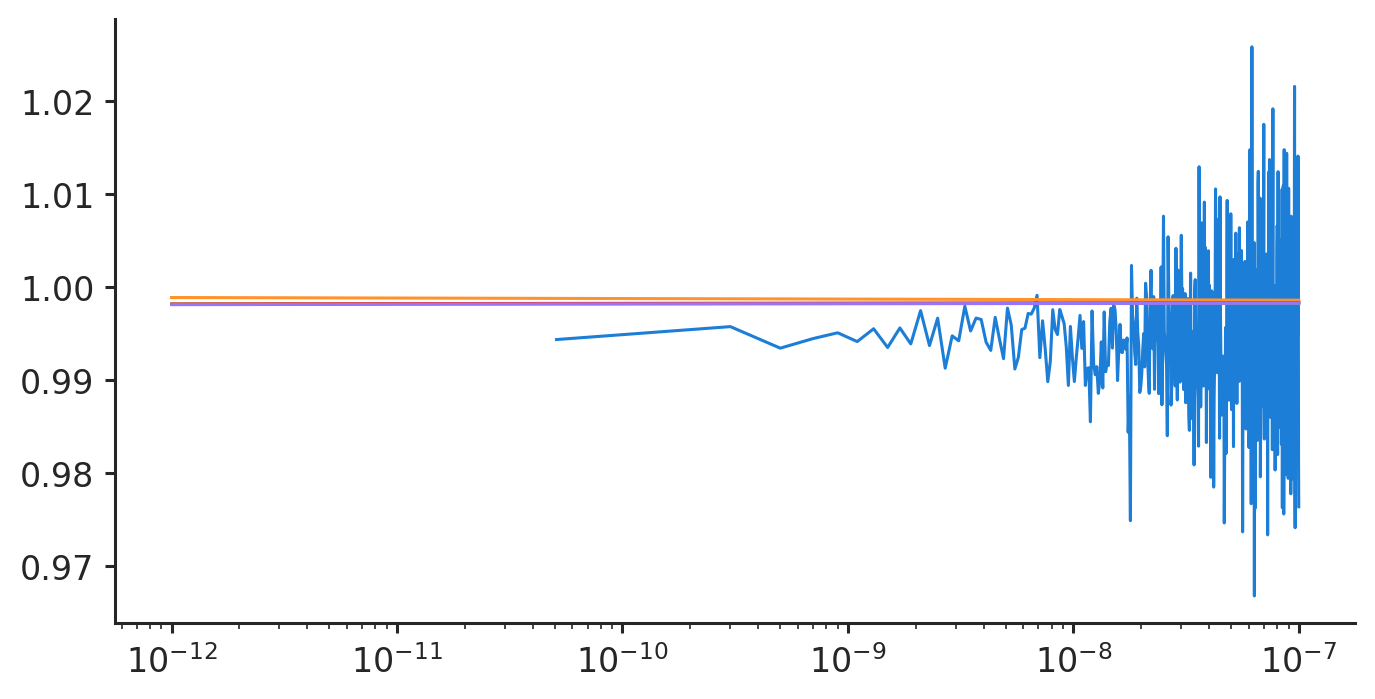

In [243]:
marginal_plot(bfs, 'rbp', 1000, log=True)

done.
32/32 [==============================] - 0s 648us/step
done.
32/32 [==============================] - 0s 697us/step
done.
32/32 [==============================] - 0s 676us/step
done.
32/32 [==============================] - 0s 717us/step


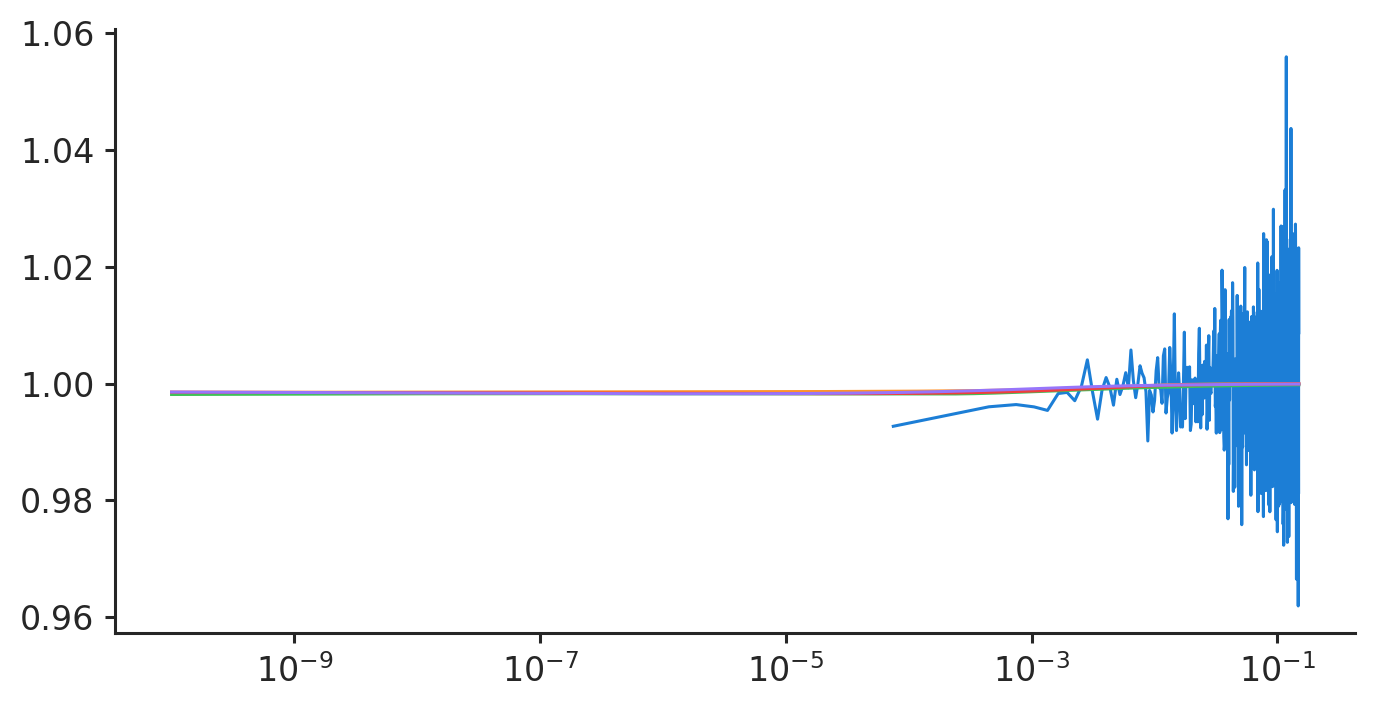

In [244]:
marginal_plot(bfs, 'rf', 1000, log=True)

done.
16/16 [==============================] - 0s 668us/step
done.
16/16 [==============================] - 0s 702us/step
done.
16/16 [==============================] - 0s 678us/step
done.
16/16 [==============================] - 0s 802us/step


[]

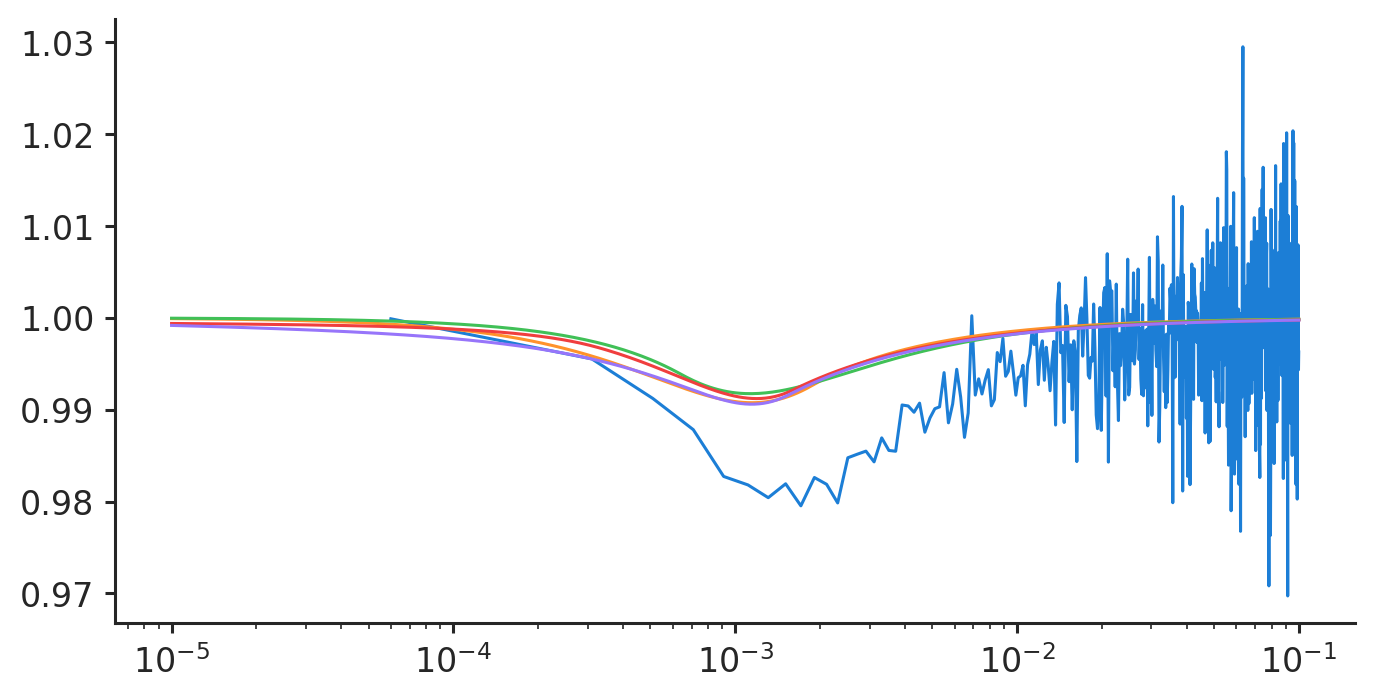

In [228]:
marginal_plot(bfs, 'rf', 1000, log=True)

done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step


[]

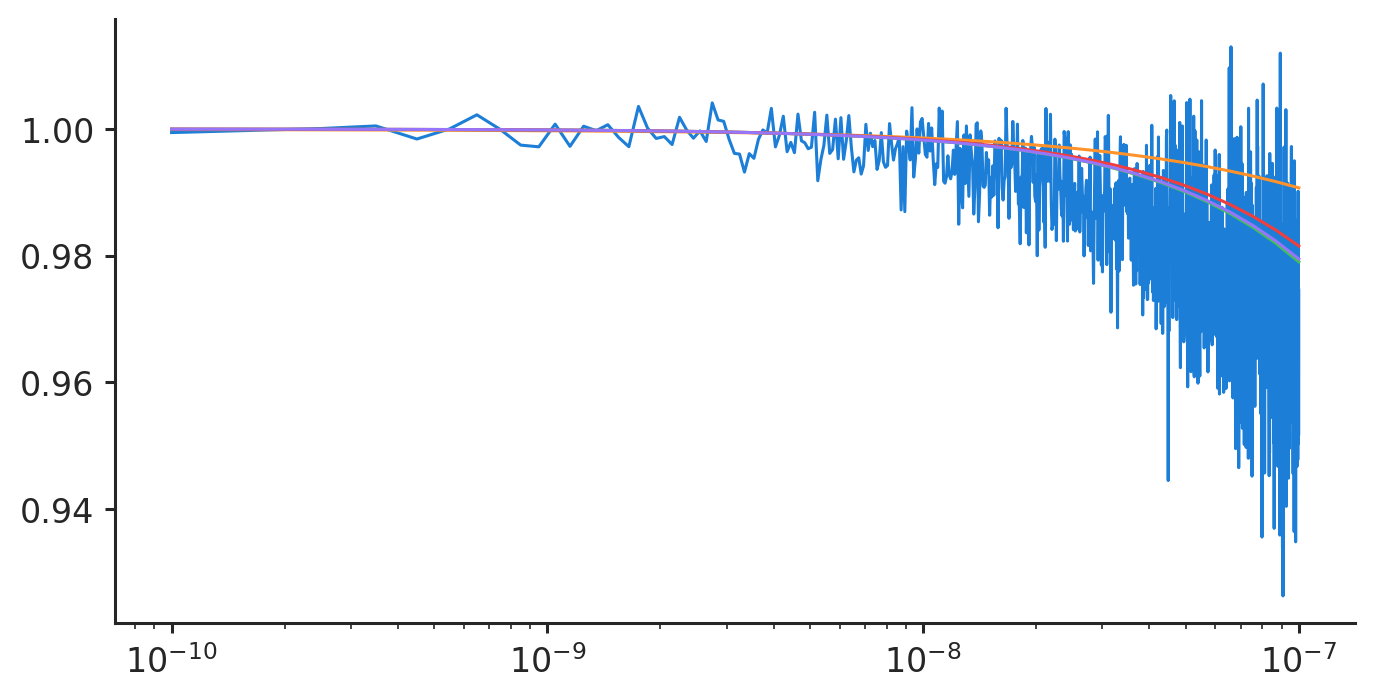

In [204]:
X = pd.DataFrame(bf.func.X, columns=('mu', 'sh', 'L', 'rbp', 'rf'))
X['y'] = bf.func.y

X['mu_bin'] = pd.cut(X['mu'], 1000)
grp = X.groupby(['mu_bin']).mean().reset_index()

mids = np.array([(x.left + x.right)/2 for x in grp['mu_bin'].values])
plt.plot(mids, grp['y'].values)

for i in range(4):
    bf = res.loc[res['key'] == f'bmap_hg38_reps_0n8_0n4_0n2_1nx_Nonel2penalty_eluactiv_sigmoidoutactiv_fit_{i}rep']['bf'].values[0]
    
    (mu, *_), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(dict(mu=50),
                                                                     fix_X={'L': 1_000, 'sh': 1e-2, 'rf': 1e-6, 'rbp': 1e-7})

    
    plt.plot(X_mesh_raw[:, 0], predict_grid.squeeze())
    
plt.semilogx()

done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step


[]

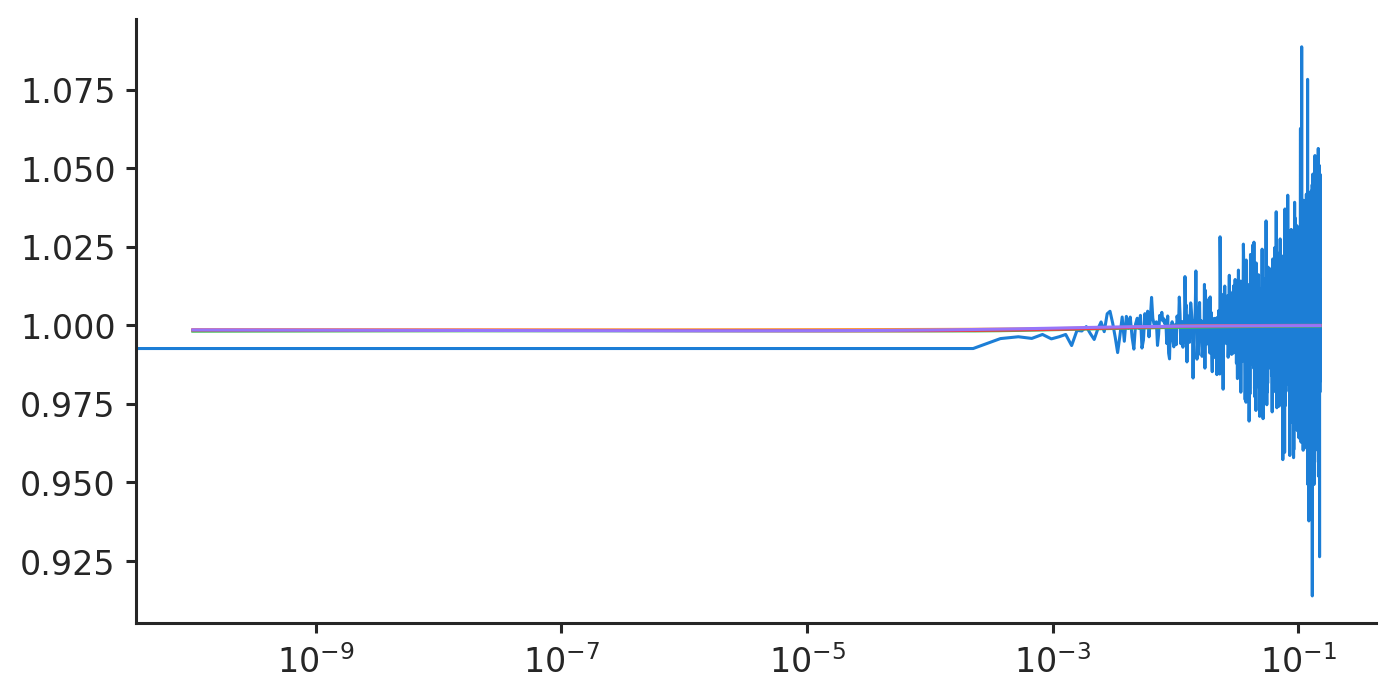

In [214]:
X = pd.DataFrame(bf.func.X, columns=('mu', 'sh', 'L', 'rbp', 'rf'))
X['y'] = bf.func.y

X['rf_bin'] = pd.cut(X['rf'], 1000)
grp = X.groupby(['rf_bin']).mean().reset_index()

mids = np.array([(x.left + x.right)/2 for x in grp['rf_bin'].values])
plt.plot(mids, grp['y'].values)

for i in range(4):
    bf = res.loc[res['key'] == f'bmap_hg38_reps_0n8_0n4_0n2_1nx_Nonel2penalty_eluactiv_sigmoidoutactiv_fit_{i}rep']['bf'].values[0]
    
    (mu, sh, L, rbp, rf), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(dict(rf=50),
                                                                     fix_X={'L': 1_000, 'sh': 1e-2, 'mu': 1e-8, 'rbp': 1e-7})

    
    plt.plot(X_mesh_raw[:, 4], predict_grid.squeeze())
    
plt.semilogx()

done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 2ms/step
done.
2/2 [==============================] - 0s 4ms/step
done.
2/2 [==============================] - 0s 3ms/step


[]

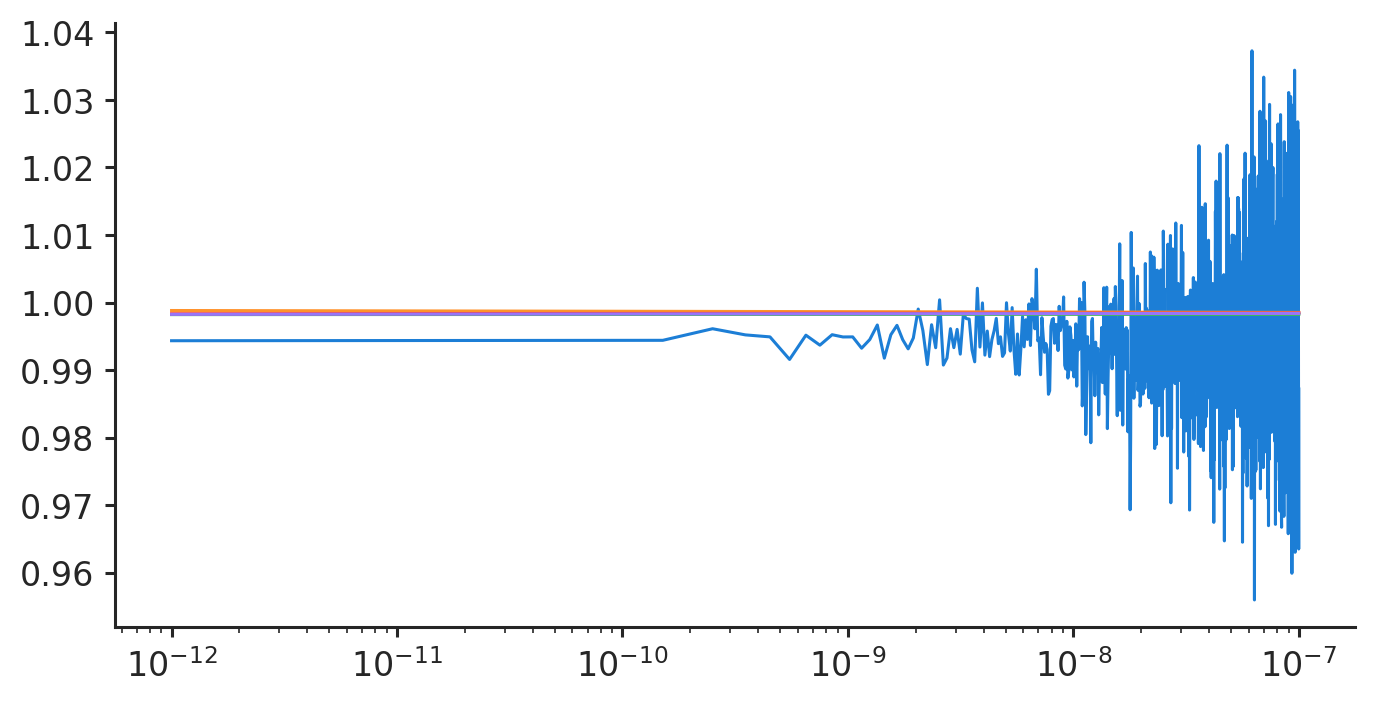

In [213]:
X = pd.DataFrame(bf.func.X, columns=('mu', 'sh', 'L', 'rbp', 'rf'))
X['y'] = bf.func.y

X['rbp_bin'] = pd.cut(X['rbp'], 1000)
grp = X.groupby(['rbp_bin']).mean().reset_index()

mids = np.array([(x.left + x.right)/2 for x in grp['rbp_bin'].values])
plt.plot(mids, grp['y'].values)

for i in range(4):
    bf = res.loc[res['key'] == f'bmap_hg38_reps_0n8_0n4_0n2_1nx_Nonel2penalty_eluactiv_sigmoidoutactiv_fit_{i}rep']['bf'].values[0]
    
    (mu, sh, L, rbp, rf), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(dict(rbp=50),
                                                                     fix_X={'L': 1_000, 'sh': 1e-2, 'mu': 1e-8, 'rf': 1e-8})

    
    plt.plot(X_mesh_raw[:, 3], predict_grid.squeeze())
    
plt.semilogx()

(array([107003.,  15999.,   9409.,   6546.,   5127.,   4132.,   3496.,
          3036.,   2811.,   2441.]),
 array([1.000e-10, 1.009e-08, 2.008e-08, 3.007e-08, 4.006e-08, 5.005e-08,
        6.004e-08, 7.003e-08, 8.002e-08, 9.001e-08, 1.000e-07]),
 <BarContainer object of 10 artists>)

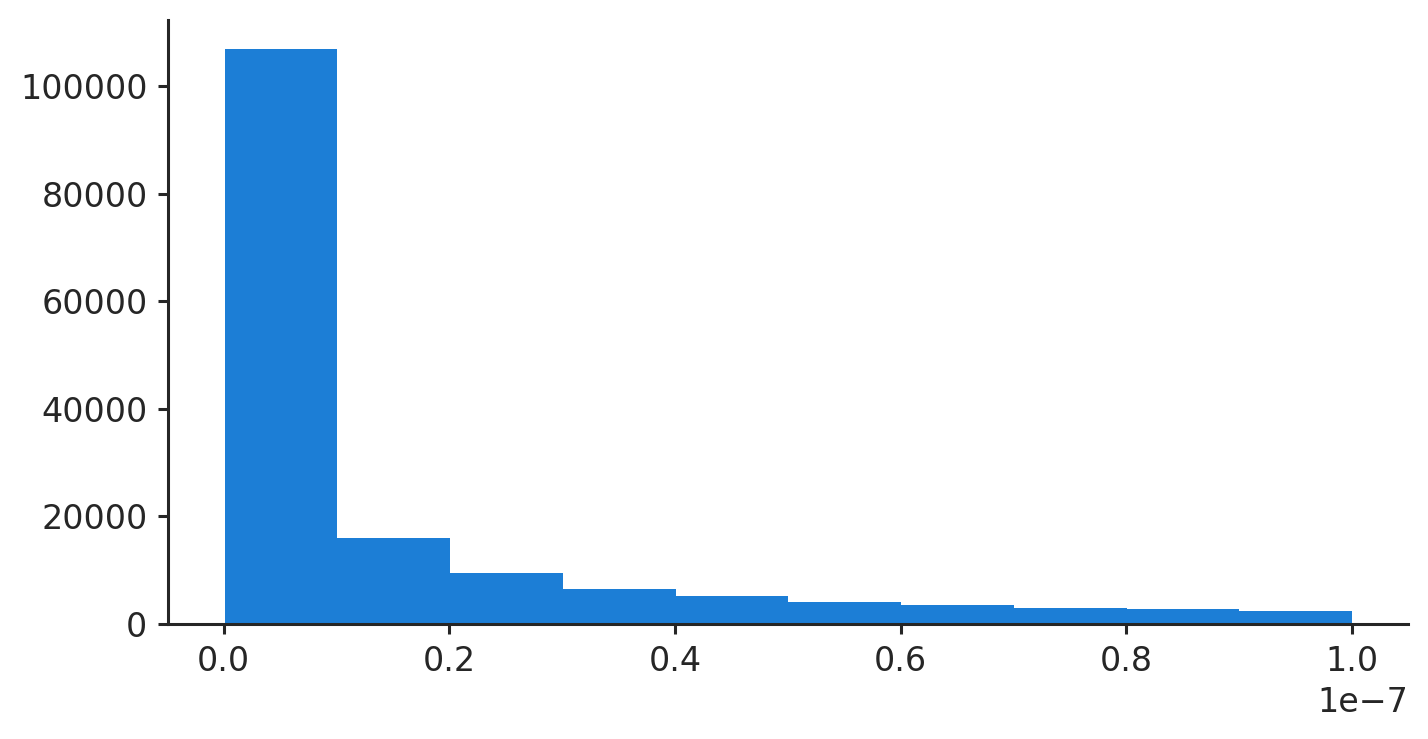

In [218]:
plt.hist(bf.func.X_train_raw[:, 0])

(array([16075., 16135., 16041., 16071., 15811., 15993., 16098., 15975.,
        15914., 15887.]),
 array([-1.7289465 , -1.38253584, -1.03612517, -0.68971451, -0.34330385,
         0.00310682,  0.34951748,  0.69592814,  1.04233881,  1.38874947,
         1.73516014]),
 <BarContainer object of 10 artists>)

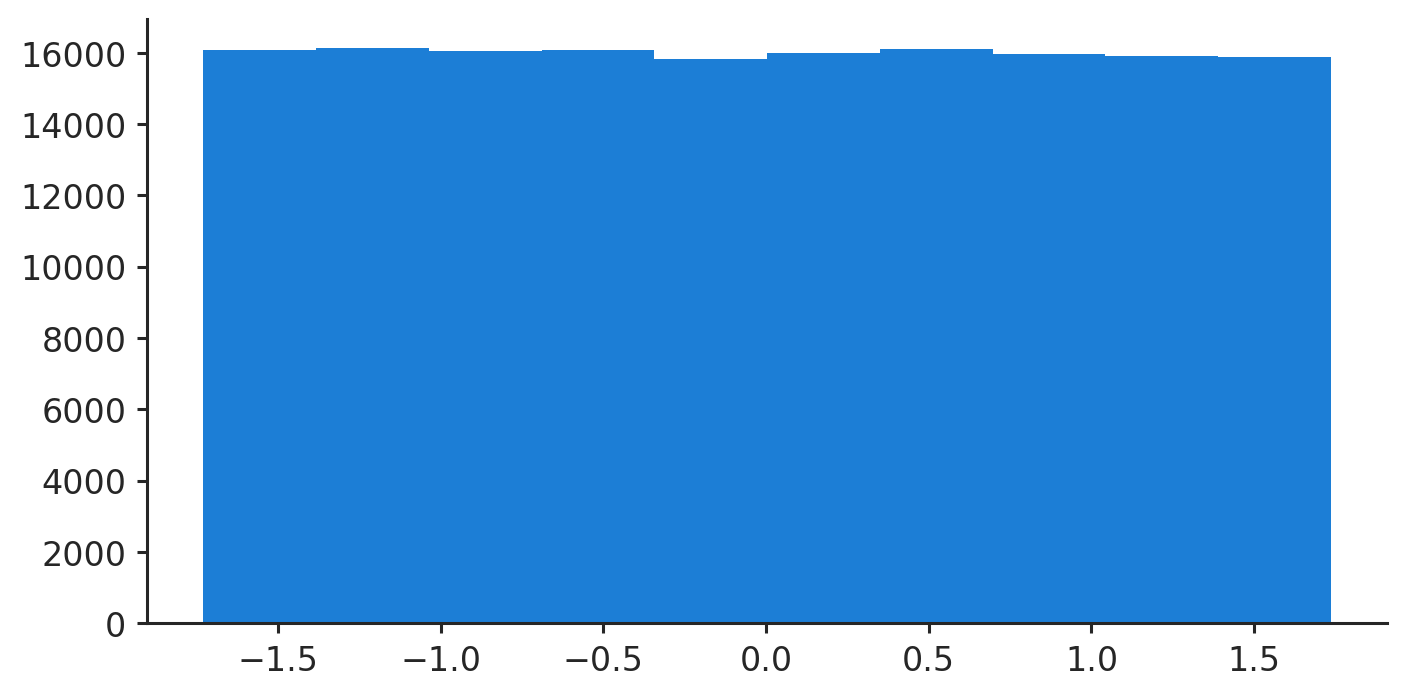

In [217]:
plt.hist(bf.func.X_train[:, 0])

done.
316/316 [==============================] - 0s 734us/step


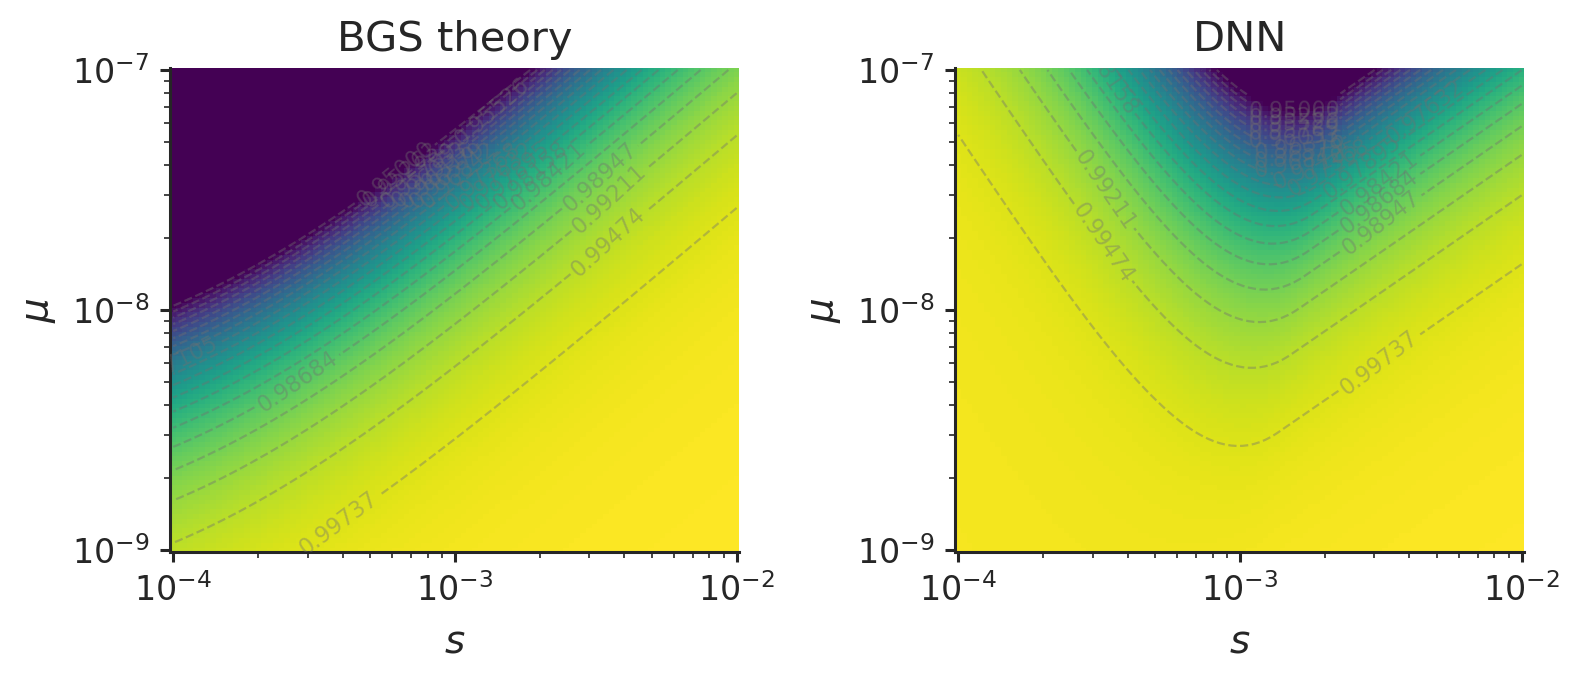

In [128]:
bf = res.loc[res['key'] == 'bmap_hg38_reps_0n8_0n4_0n2_1nx_Nonel2penalty_eluactiv_sigmoidoutactiv_fit_2rep']['bf'].values[0]


(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = bf.func.predict_grid(None, #{'mu': 101, 'sh': 100}, 
                                                                            manual_domains={'mu': (-9, -7, 101, True),
                                                                                                  'sh': (-4, -2, 100, True)}, 
                                                                            fix_X={'rf': 1e-6,
                                                                                   'rbp': 1e-7,
                                                                                    'L': 1000})                                                                   

Zp = predict_grid.squeeze()
Z = bf.theory_B(X_mesh_raw).reshape(Zp.shape)

cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')
norm = mpl.colors.Normalize(vmin=0.95, vmax=1, clip=True)

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ncontour = np.linspace(0.95, 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

(array([20195., 20013., 19981., 19794., 19918., 19790., 20098., 20069.,
        20129., 20013.]),
 array([1.0000e+00, 1.0008e+03, 2.0006e+03, 3.0004e+03, 4.0002e+03,
        5.0000e+03, 5.9998e+03, 6.9996e+03, 7.9994e+03, 8.9992e+03,
        9.9990e+03]),
 <BarContainer object of 10 artists>)

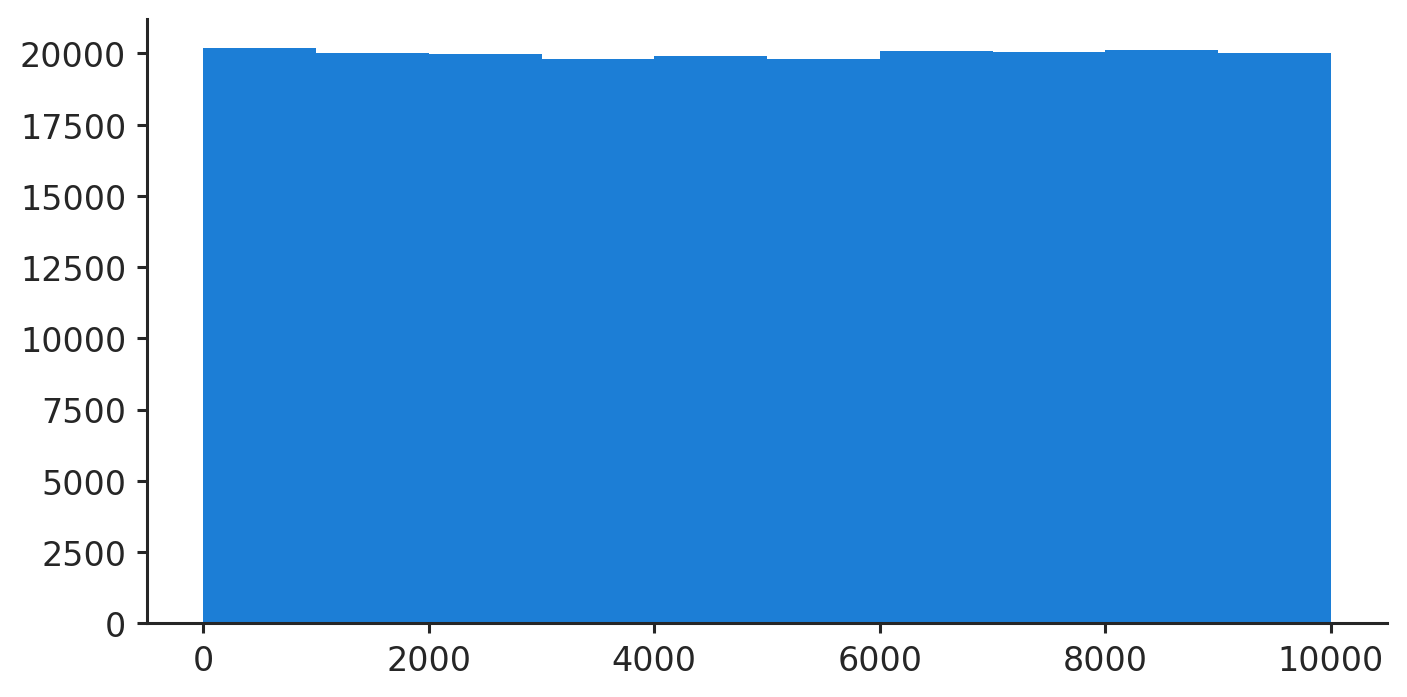

In [121]:
plt.hist(bf.func.X[:, 2])

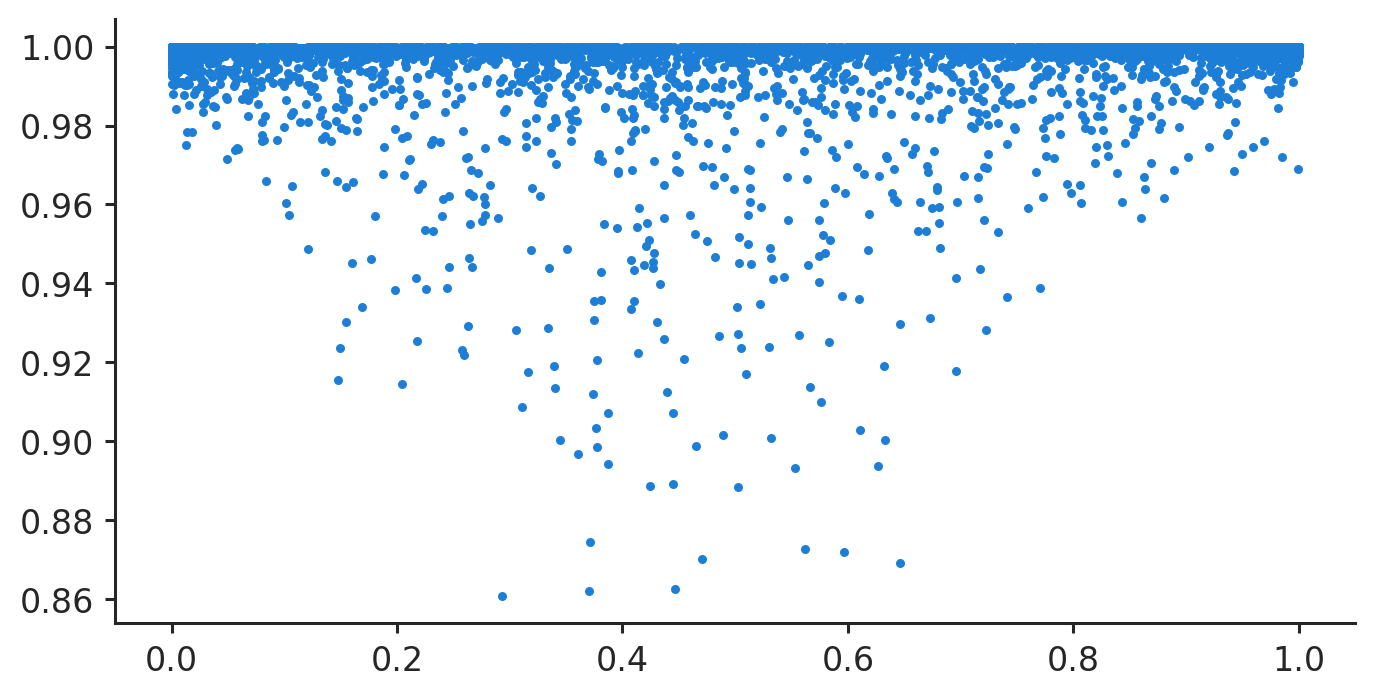

In [167]:
btheory = bgs_segment(*bf.func.X_test_raw.T)
rate = bf.func.X_test_raw[:, 0] / bf.func.X_test_raw[:, 1]
x = btheory
y = bf.predict_test()

idx = rate > 1e-4

plt.scatter(x[idx], y[idx], s=5)

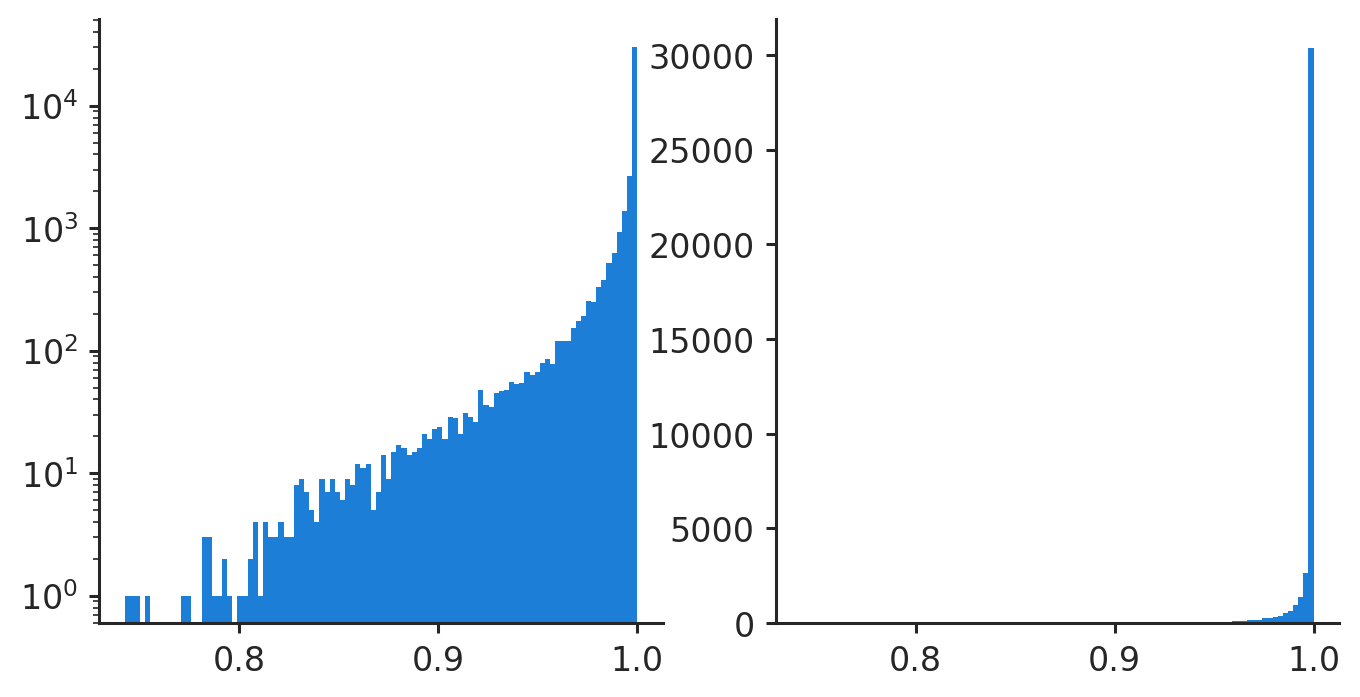

In [23]:
fig, ax = plt.subplots(ncols=2)
_ = ax[0].hist(bf.func.predict_test(), 100)
ax[0].semilogy()
_ = ax[1].hist(bf.func.predict_test(), 100)

In [24]:
np.mean(bf.func.predict_test() == 1)

0.0009

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

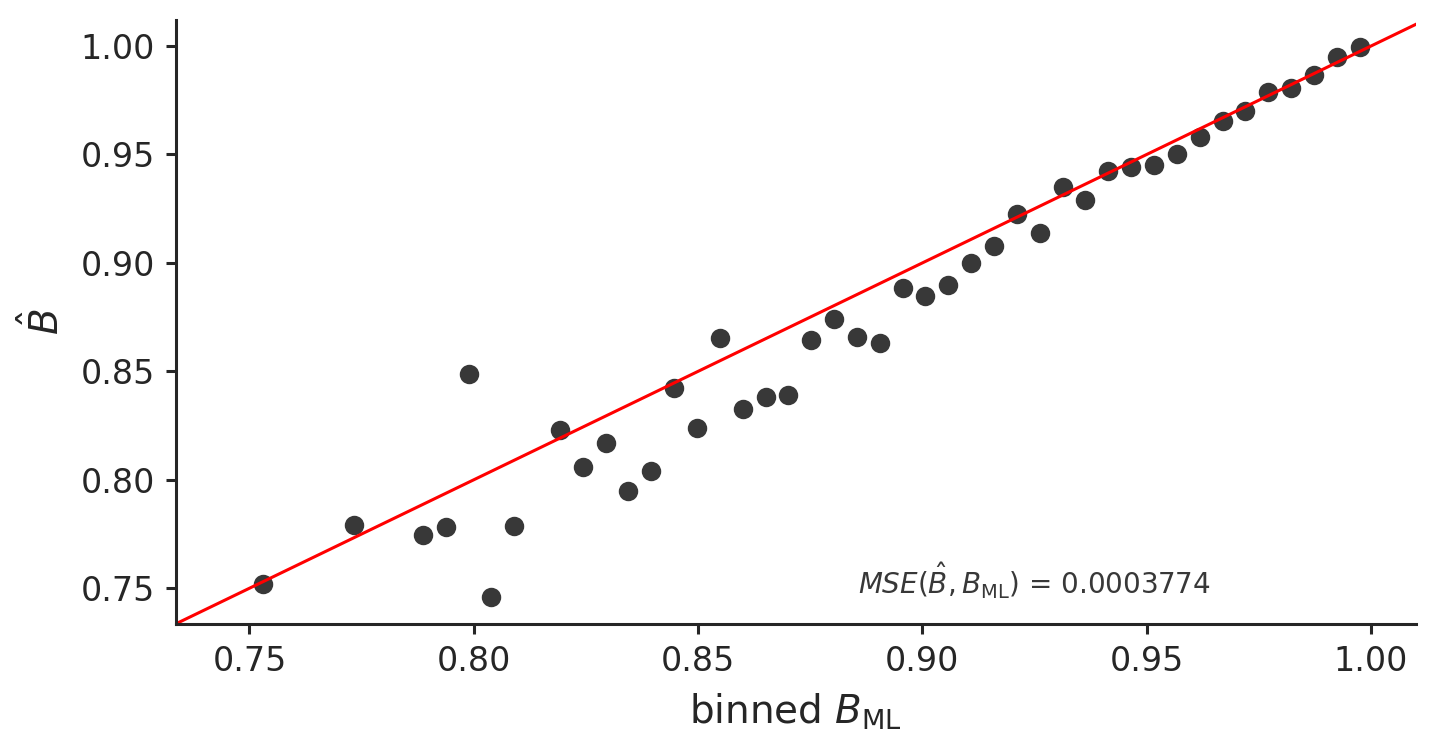

In [52]:
bhat_plot(res.loc[res['key'] == 'bmap_hg38_reps_0n16_0n8_0n4_0n2_1nx_1e-06l2penalty_eluactiv_sigmoidoutactiv_Falsevsw_fit_0rep']['bf'].values[0], 50)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

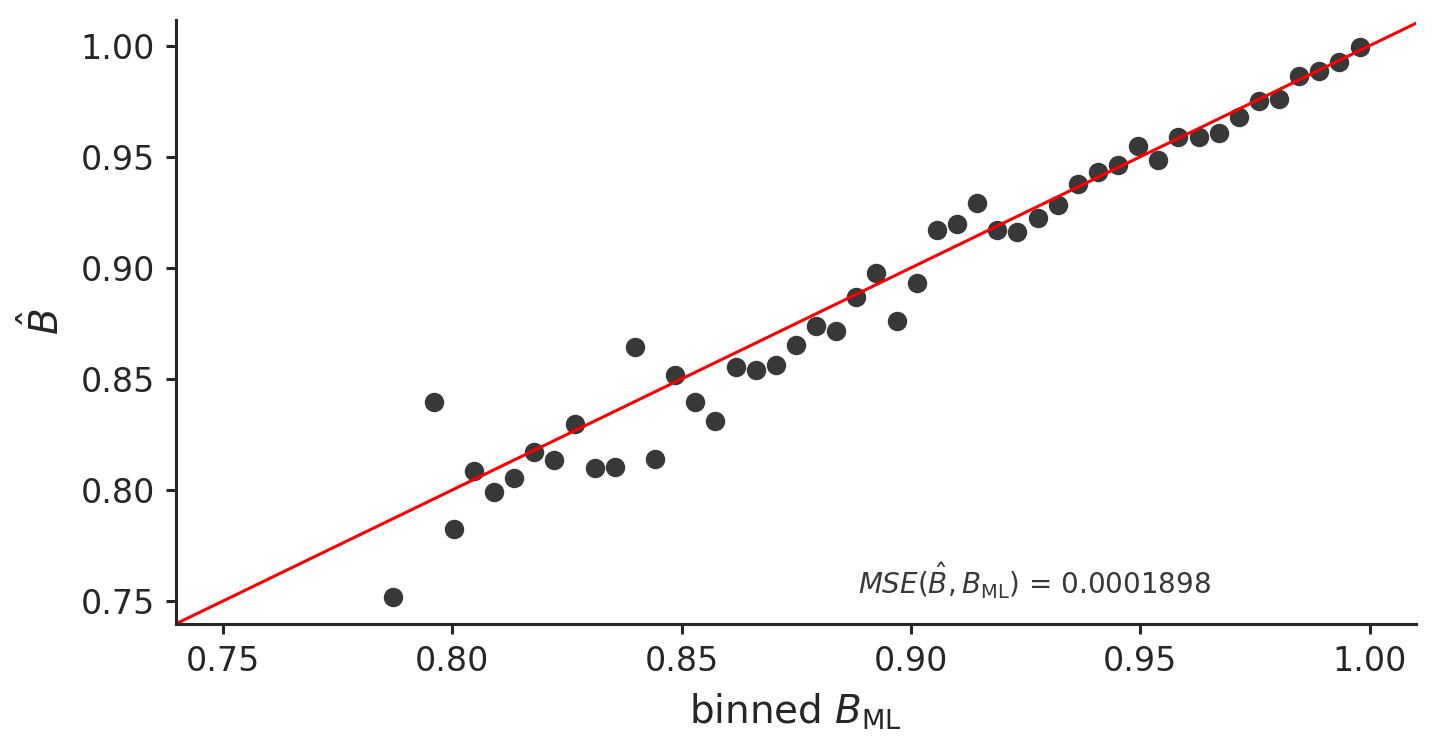

In [368]:
bhat_plot(res.loc[res['key'] == 'bmap_hg38_reps_0n128_0n64_0n32_0n8_1nx_eluactiv_sigmoidoutactiv_Falsebalance_fit_1rep']['bf'].values[0], 50)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

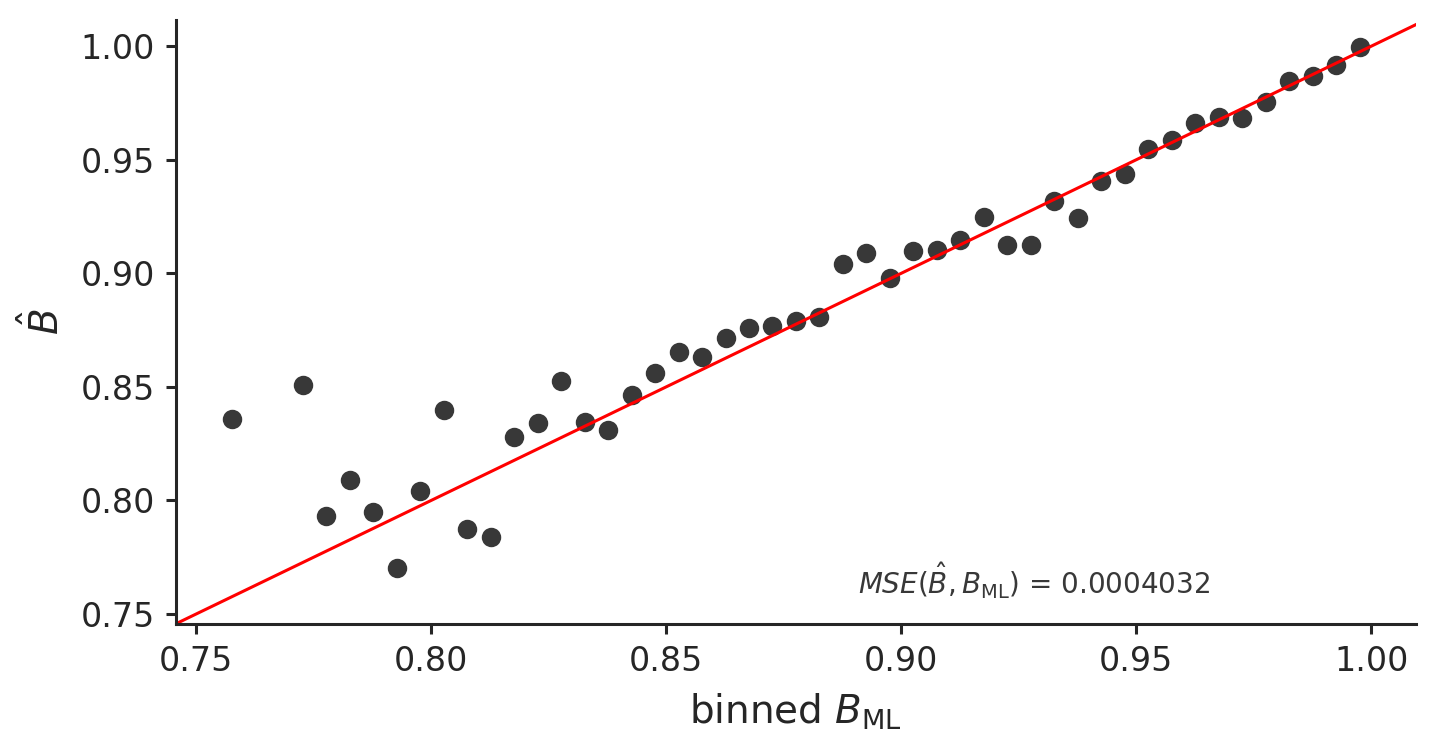

In [311]:
bhat_plot(res.loc[res['key'] == 'bmap_hg38_reps_0n128_0n64_0n32_0n8_2nx_eluactiv_sigmoidoutactiv_Falsebalance_fit_2rep']['bf'].values[0], 50)

In [242]:
res['bf'][0].func.X_train

array([[-1.58883616,  1.354554  ,  1.42148202, -0.34875262,  1.42815208],
       [-1.36827149, -1.09239208,  1.44570127,  0.6580455 ,  1.49297222],
       [-0.55965287, -1.60912926, -0.90252792, -0.72435268, -0.33156639],
       ...,
       [ 0.44830057, -1.44674693, -0.21158734,  0.99560408, -1.10044673],
       [ 1.39508924,  0.31588274, -1.66266635, -0.80968888,  1.23008948],
       [-0.29577099, -0.94881874, -0.55342474,  1.59853513, -1.32516129]])

In [247]:
res['bf'][0].func.test_mae()

0.05699589835886113

In [245]:
debug

> /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/keras/engine/data_adapter.py(988)select_data_adapter()
    986   if not adapter_cls:
    987     # TODO(scottzhu): This should be a less implementation-specific error.
--> 988     raise ValueError(
    989         "Failed to find data adapter that can handle "
    990         "input: {}, {}".format(



ipdb>  y
ipdb>  x
ipdb>  u


> /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/keras/utils/traceback_utils.py(67)error_handler()
     65     except Exception as e:  # pylint: disable=broad-except
     66       filtered_tb = _process_traceback_frames(e.__traceback__)
---> 67       raise e.with_traceback(filtered_tb) from None
     68     finally:
     69       del filtered_tb



ipdb>  y


*** NameError: name 'y' is not defined


ipdb>  x


*** NameError: name 'x' is not defined


ipdb>  down


> /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/keras/engine/data_adapter.py(988)select_data_adapter()
    986   if not adapter_cls:
    987     # TODO(scottzhu): This should be a less implementation-specific error.
--> 988     raise ValueError(
    989         "Failed to find data adapter that can handle "
    990         "input: {}, {}".format(



ipdb>  dir()


['adapter_cls', 'x', 'y']


ipdb>  exit


(<Figure size 1800x500 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=0, n8=0, n5=2'}>)

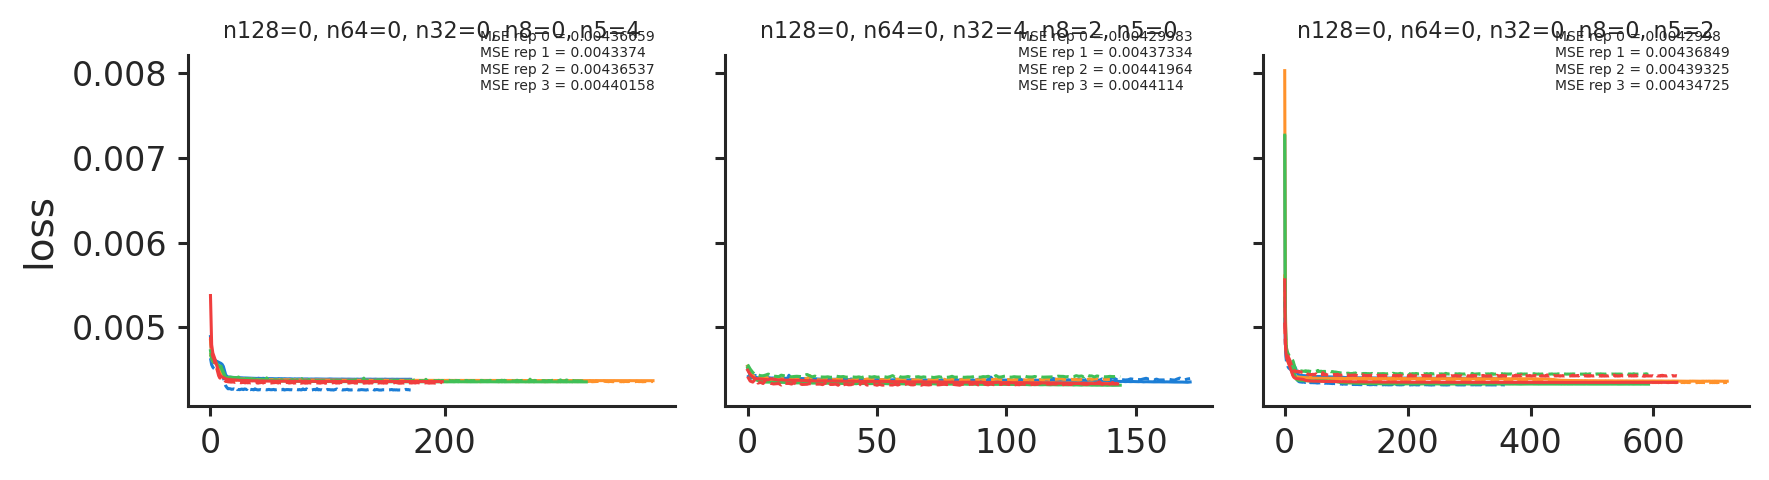

In [15]:
arch_loss_plot(res)

In [18]:
res[(0, 0, 0, 0, 2)][0].func.bounds

{'mu': (-10, -7),
 'sh': (-5, -1),
 'L': (1, 10000),
 'rbp': (-12, -7),
 'rf': (-10, -0.824)}

(0.004, 0.0045)

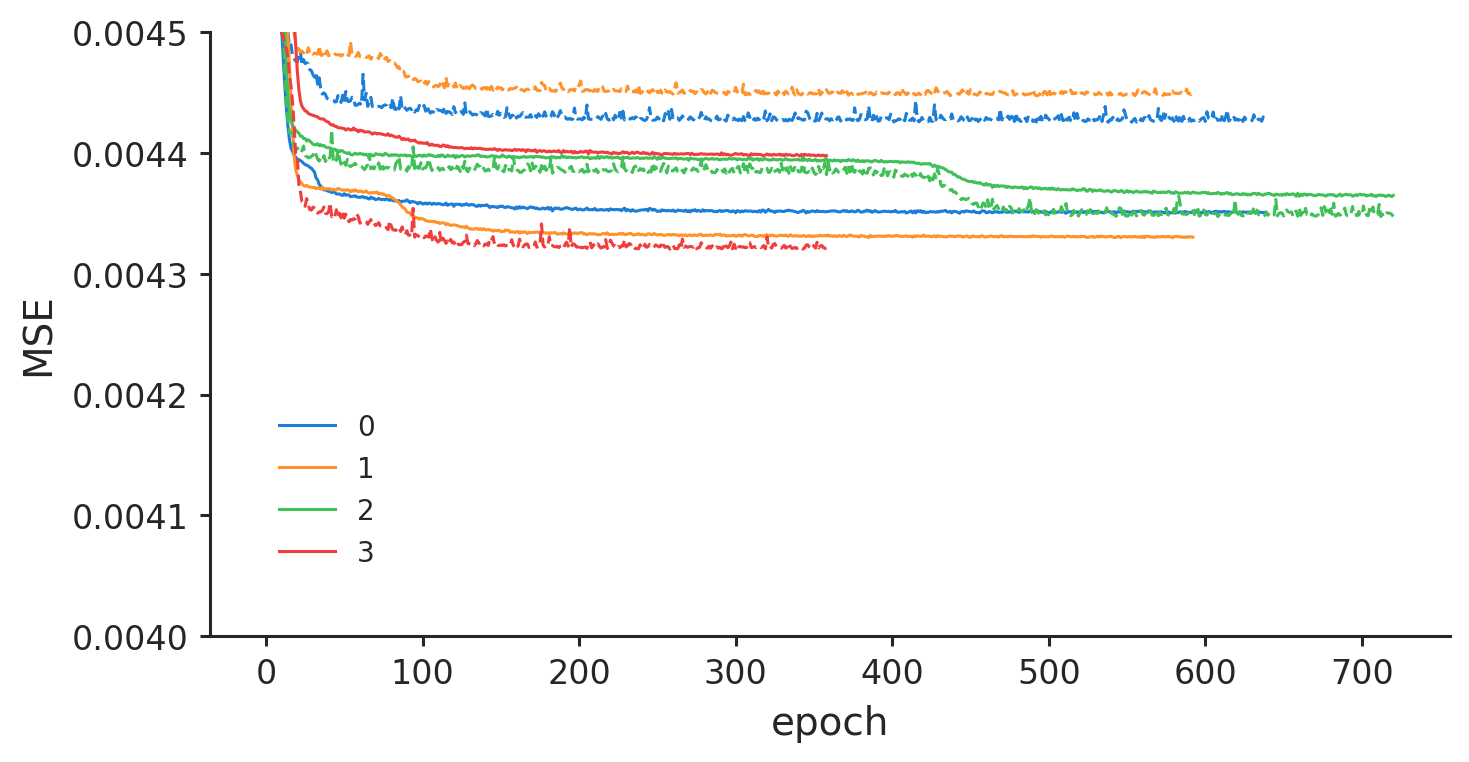

In [14]:
figax = plt.subplots()

for i in range(4):
    figax = loss_plot(res[(0, 0, 0, 0, 2)][i], figax=figax, loss_label=i, val_label=None, match_colors=True)

fig, ax = figax
ax.set_ylim(0.004, 0.0045)

In [17]:
res[(0, 0, 0, 0, 2)][1].predict_test().max()

1.0

In [20]:
import keras

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


(<Figure size 1800x500 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=0, n8=0, n5=2'}>)

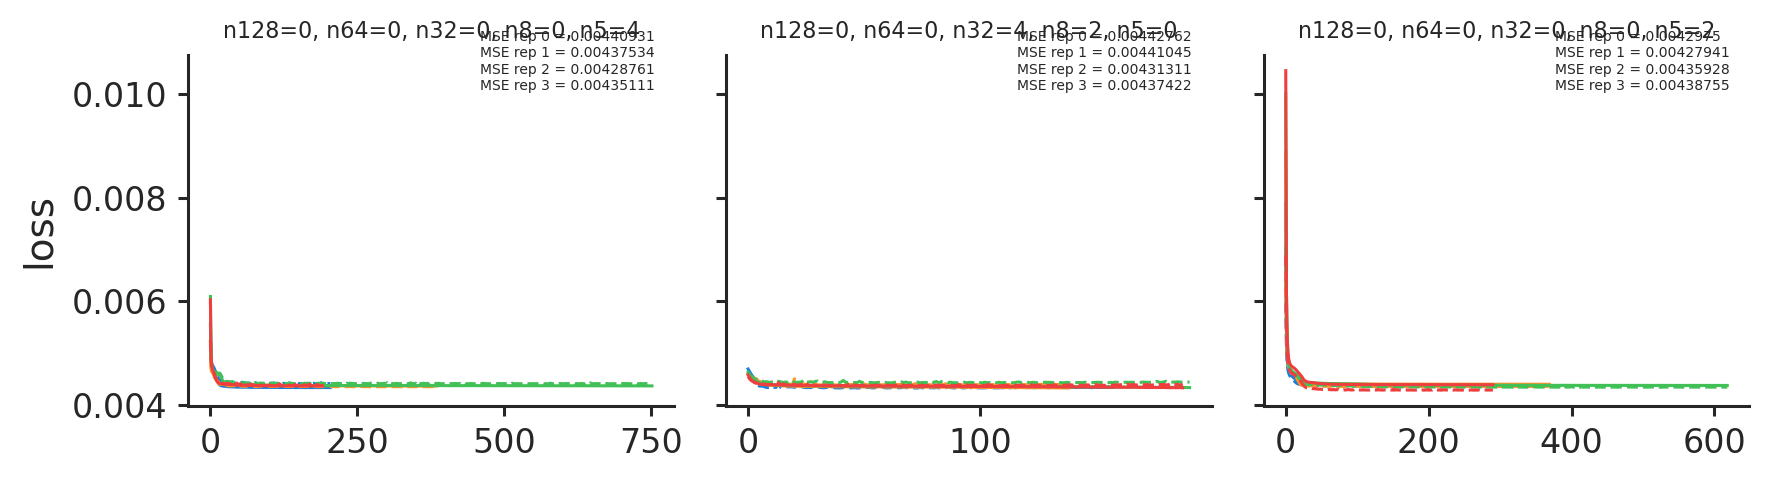

In [8]:
arch_loss_plot(res)

(<Figure size 2000x1400 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='actual', ylabel='predict'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

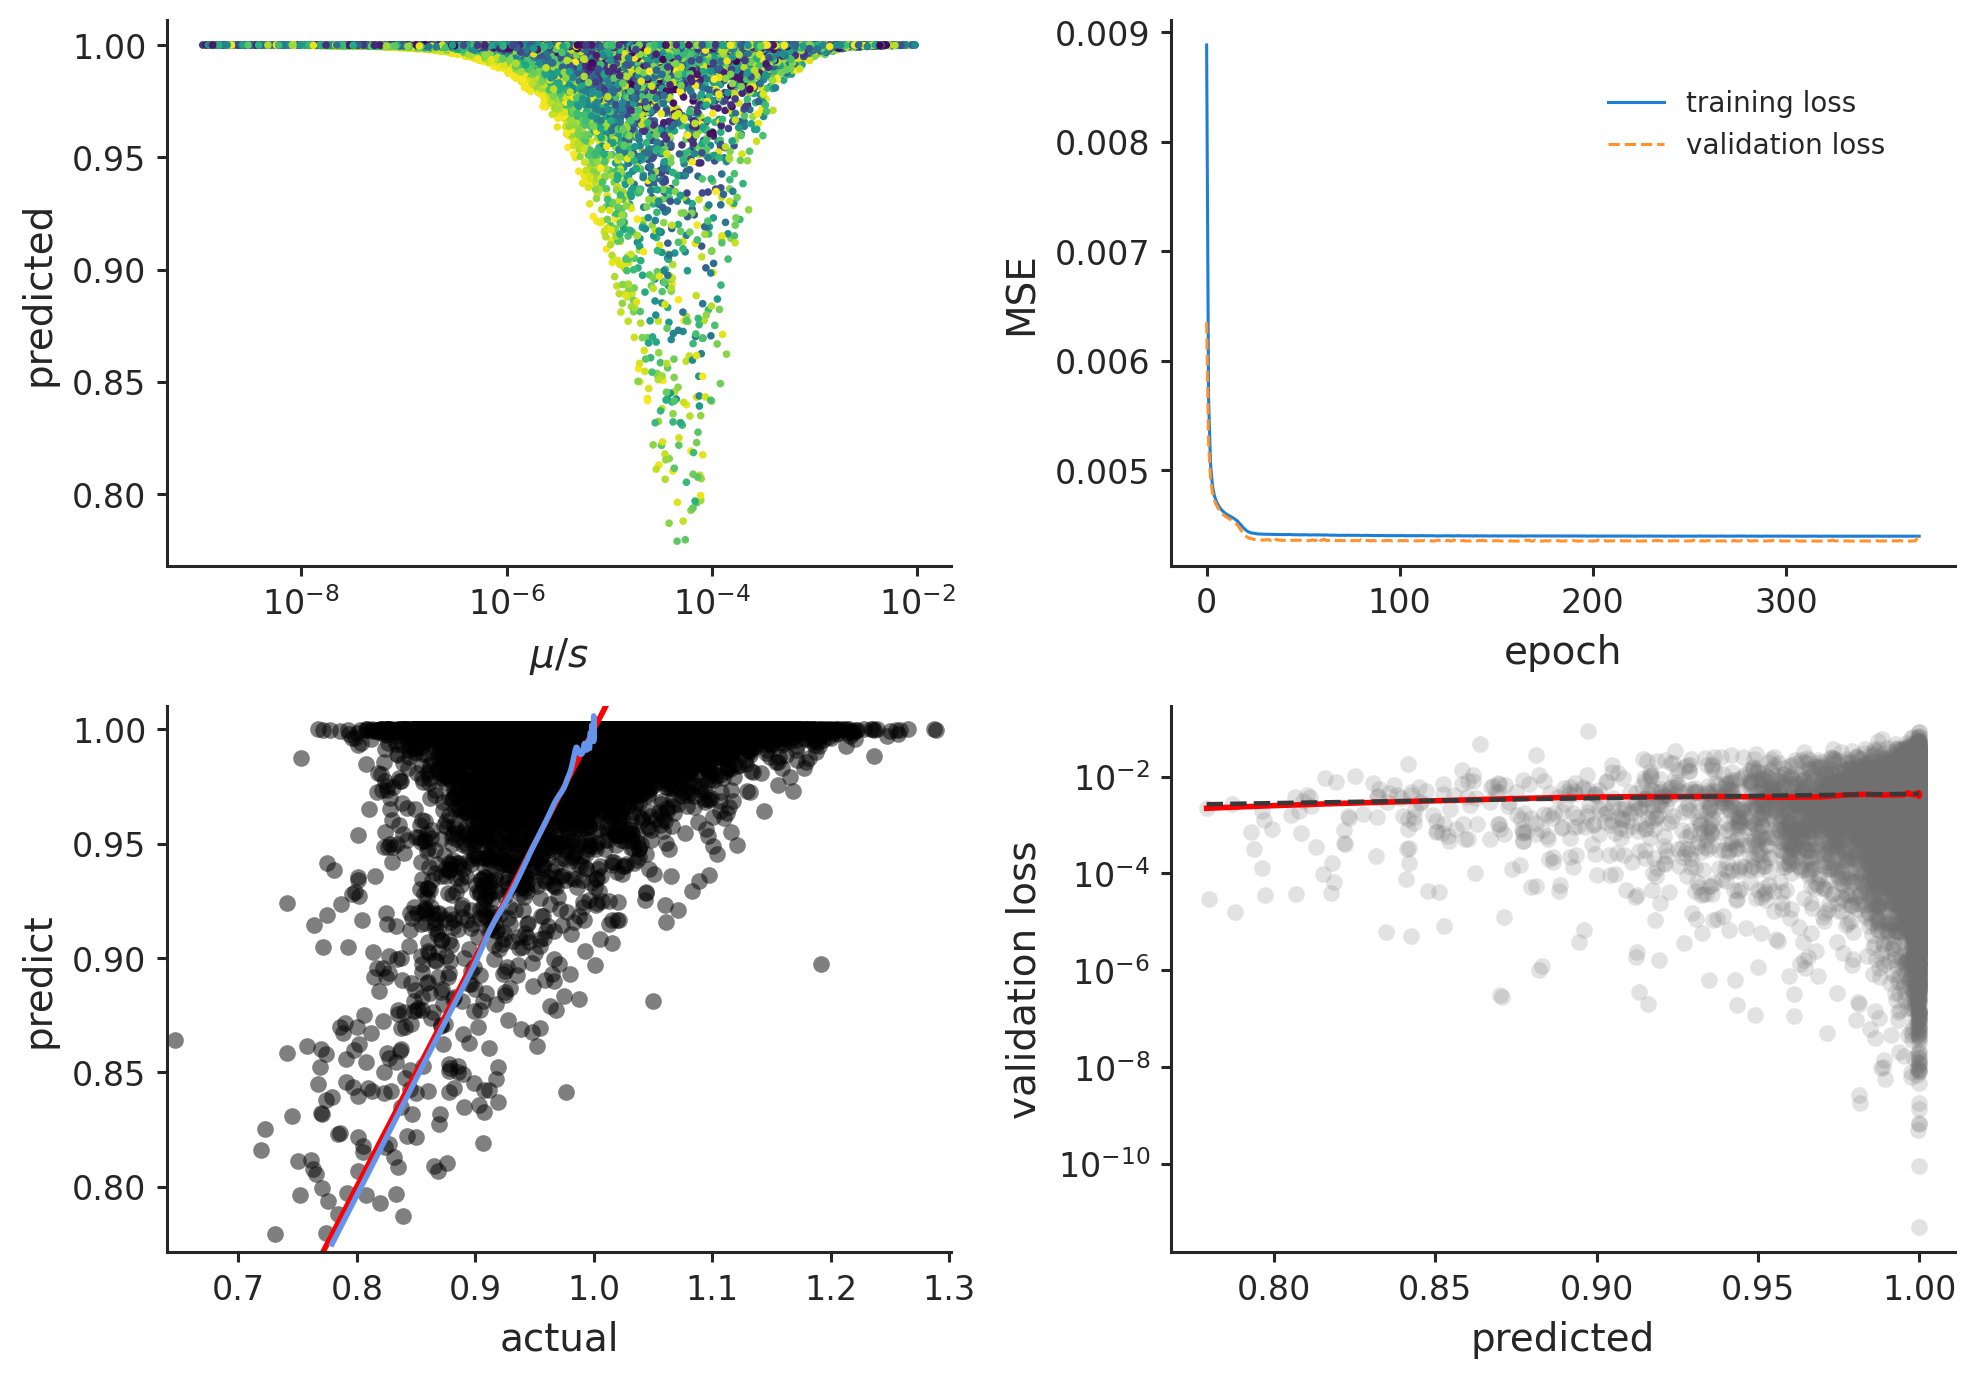

In [64]:
b_learn_diagnostic_plot(res[(0, 0, 0, 0, 2)][2], panel='predict', R=50,
                        bins=100,
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [16]:
res.keys()

dict_keys([(0, 0, 0, 0, 4), (0, 0, 4, 2, 0), (0, 0, 0, 0, 2)])

(<Figure size 2000x1400 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='actual', ylabel='predict'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

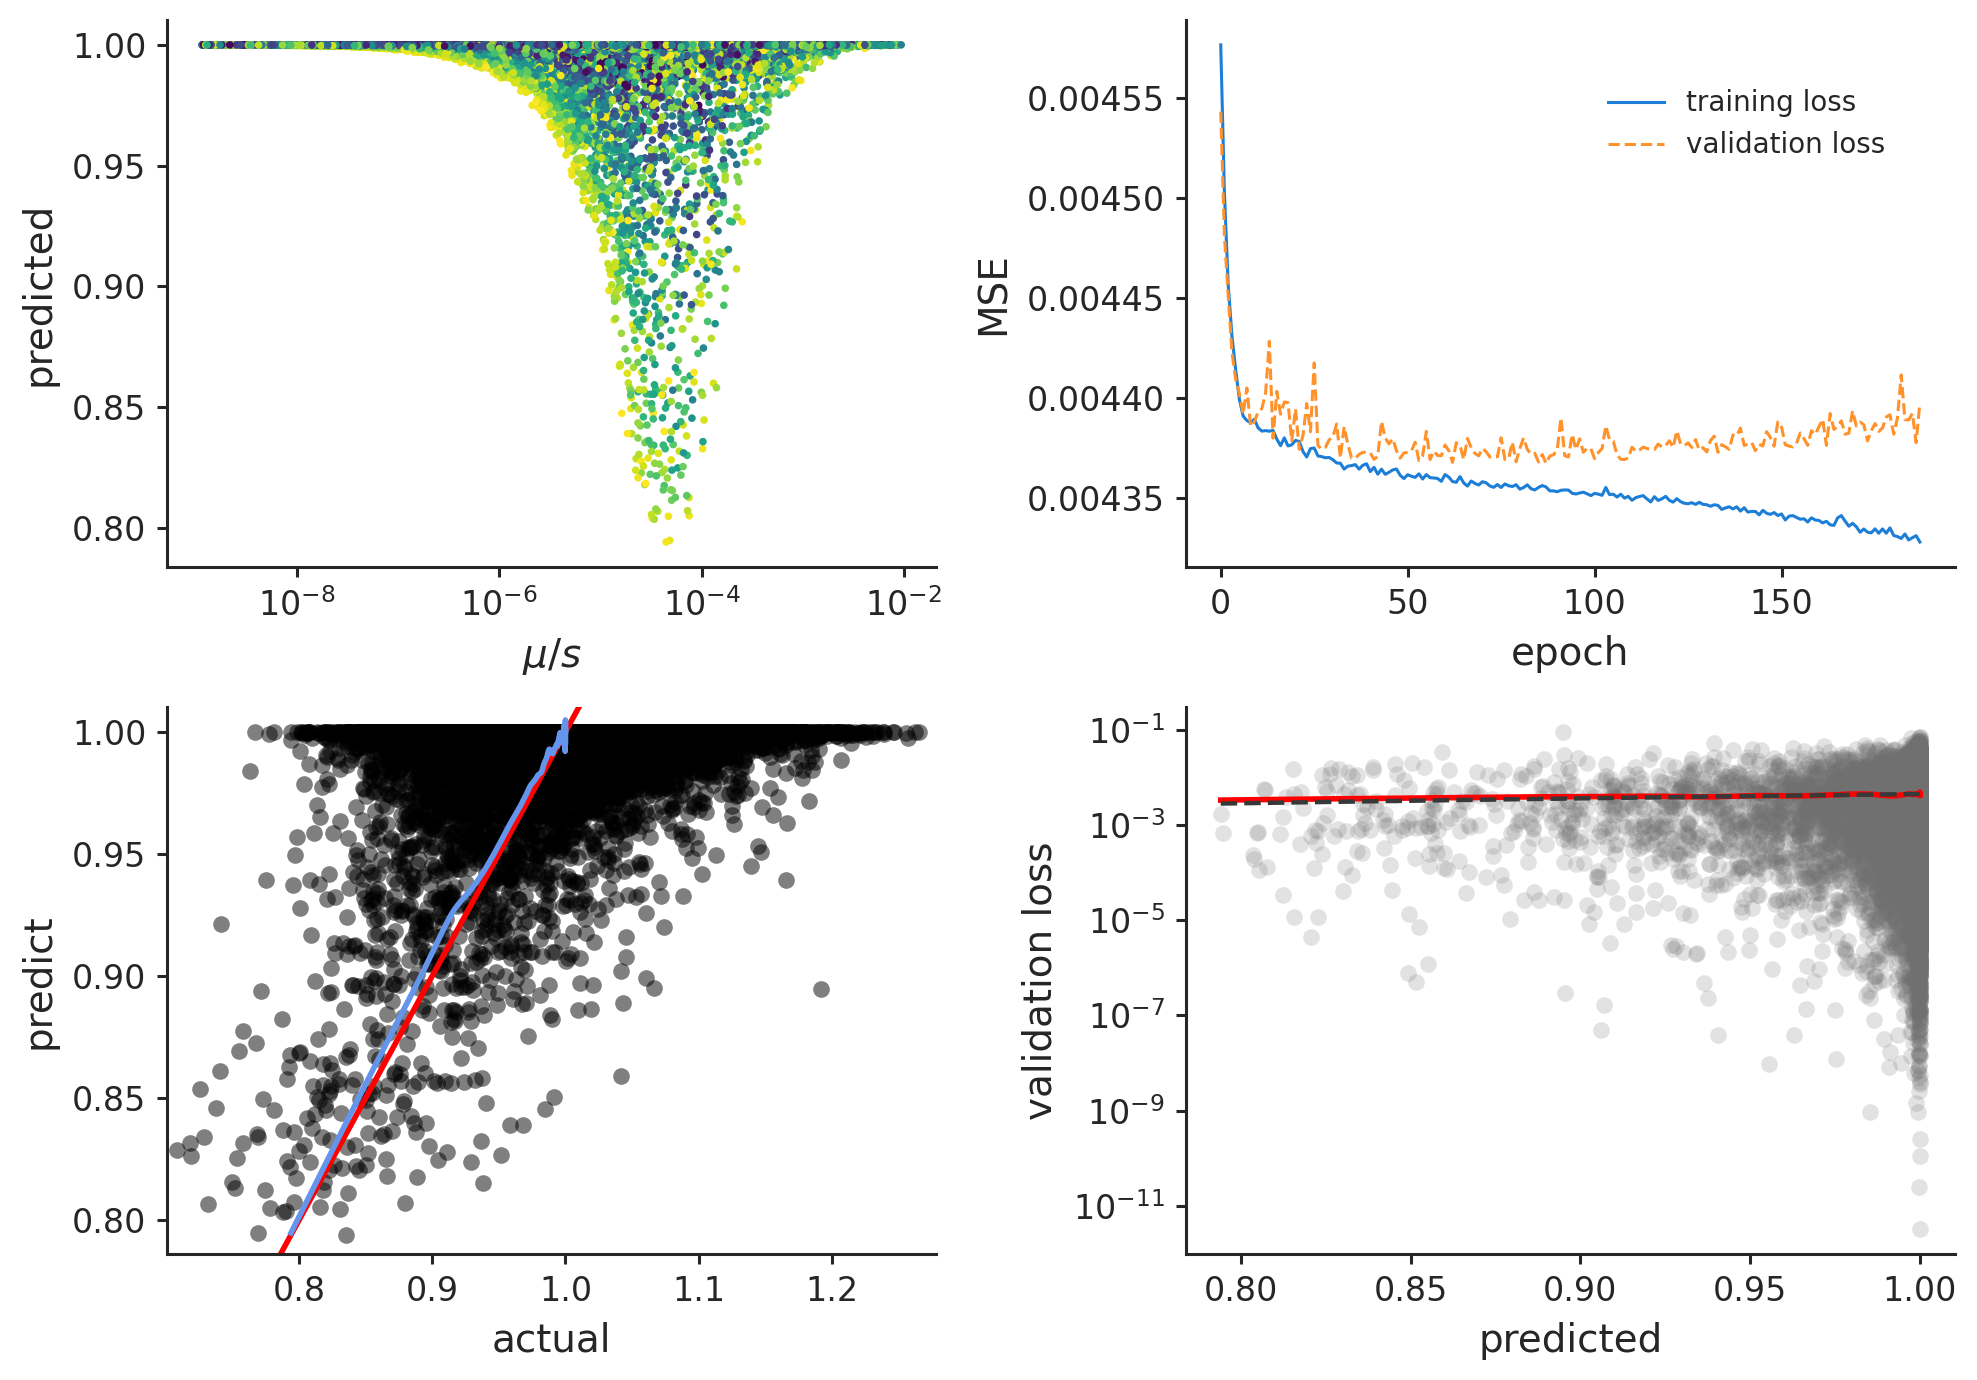

In [59]:
b_learn_diagnostic_plot(res[(0, 0, 4, 2, 0)][3], 
                        panel='predict', R=50,
                        bins=100, 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [214]:
debug


> /home/vsb/projects/bprime/bgspy/plots.py(58)bhat_plot()
     56     ax.set_ylabel('$\hat{B}$')
     57     ax.set_xlabel('binned $B_\mathrm{ML}$')
---> 58     o = min(bin_mid, ytest)
     59     ax.axline((o, o), slope=1, c='r')
     60     mse = signif(bfunc.Bhat_mse(bins), 4)



ipdb>  bin_mid


array([0.8055723 , 0.80958104, 0.81358993, 0.8175987 , 0.8216075 ,
       0.82561636, 0.8296251 , 0.833634  , 0.8376428 , 0.8416516 ,
       0.84566045, 0.8496692 , 0.8536781 , 0.8576869 , 0.86169577,
       0.86570454, 0.8697133 , 0.8737222 , 0.87773097, 0.88173985,
       0.8857486 , 0.88975745, 0.8937663 , 0.89777505, 0.90178394,
       0.9057927 , 0.9098016 , 0.9138104 , 0.91781914, 0.92182803,
       0.9258368 , 0.9298457 , 0.93385446, 0.9378633 , 0.9418721 ,
       0.9458809 , 0.9498898 , 0.95389855, 0.95790744, 0.9619162 ,
       0.965925  , 0.96993387, 0.97394264, 0.9779515 , 0.9819603 ,
       0.9859691 , 0.98997796, 0.9939867 , 0.9979956 ], dtype=float32)


ipdb>  exit


In [207]:
edges, mids, y = res[(0, 0, 0, 0, 2)][0].binned_Bhats(50)

ERROR! Session/line number was not unique in database. History logging moved to new session 1237


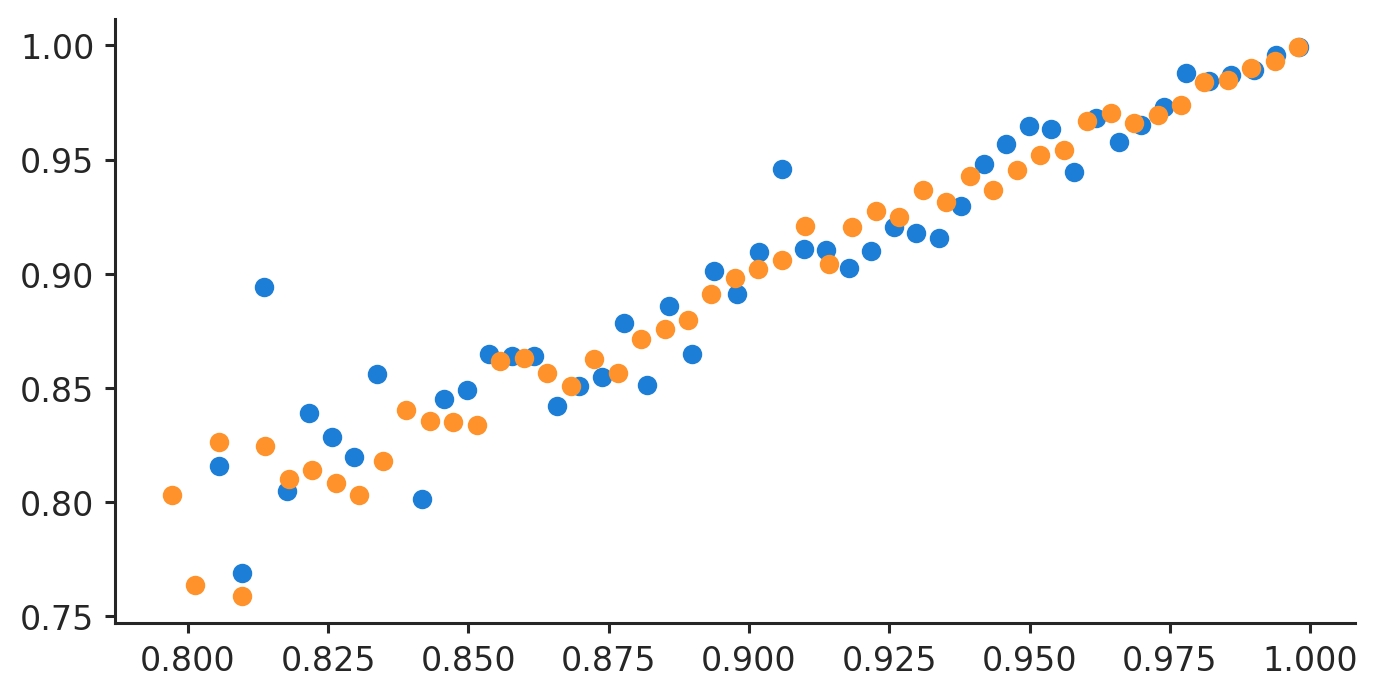

In [210]:
edges, mids, y = res[(0, 0, 0, 0, 2)][0].binned_Bhats(50)
plt.scatter(mids, y)
edges, mids, y = res[(0, 0, 0, 0, 2)][0].binned_Bhats(50, which='train')
plt.scatter(mids, y)

In [195]:
debug

> /home/vsb/projects/bprime/bgspy/utils.py(236)signif()
    234     if x == 0:
    235         return 0.
--> 236     return np.round(x, digits-int(floor(log10(abs(x))))-1)
    237 
    238 def midpoint(x):



ipdb>  u


> /home/vsb/projects/bprime/bgspy/plots.py(59)bhat_plot()
     57     ax.set_xlabel('binned $B_\mathrm{ML}$')
     58     ax.axline((0.4, 0.4), slope=1, c='r')
---> 59     mse = signif(bfunc.Bhat_mse(bins), 4)
     60     ax.text(0.4, 0.05, f"$MSE(\hat{{B}}, B_\mathrm{{ML}})$ = {mse}")
     61     return fig, ax



ipdb>  bins


50


ipdb>  down


> /home/vsb/projects/bprime/bgspy/utils.py(236)signif()
    234     if x == 0:
    235         return 0.
--> 236     return np.round(x, digits-int(floor(log10(abs(x))))-1)
    237 
    238 def midpoint(x):



ipdb>  x


nan


ipdb>  up


> /home/vsb/projects/bprime/bgspy/plots.py(59)bhat_plot()
     57     ax.set_xlabel('binned $B_\mathrm{ML}$')
     58     ax.axline((0.4, 0.4), slope=1, c='r')
---> 59     mse = signif(bfunc.Bhat_mse(bins), 4)
     60     ax.text(0.4, 0.05, f"$MSE(\hat{{B}}, B_\mathrm{{ML}})$ = {mse}")
     61     return fig, ax



ipdb>  exit


In [65]:
import seaborn as sns

In [ ]:
sns.pairplot(pd.DataFrame(res[(0, 0, 0, 0, 2)][2].func.X), kind="kde")

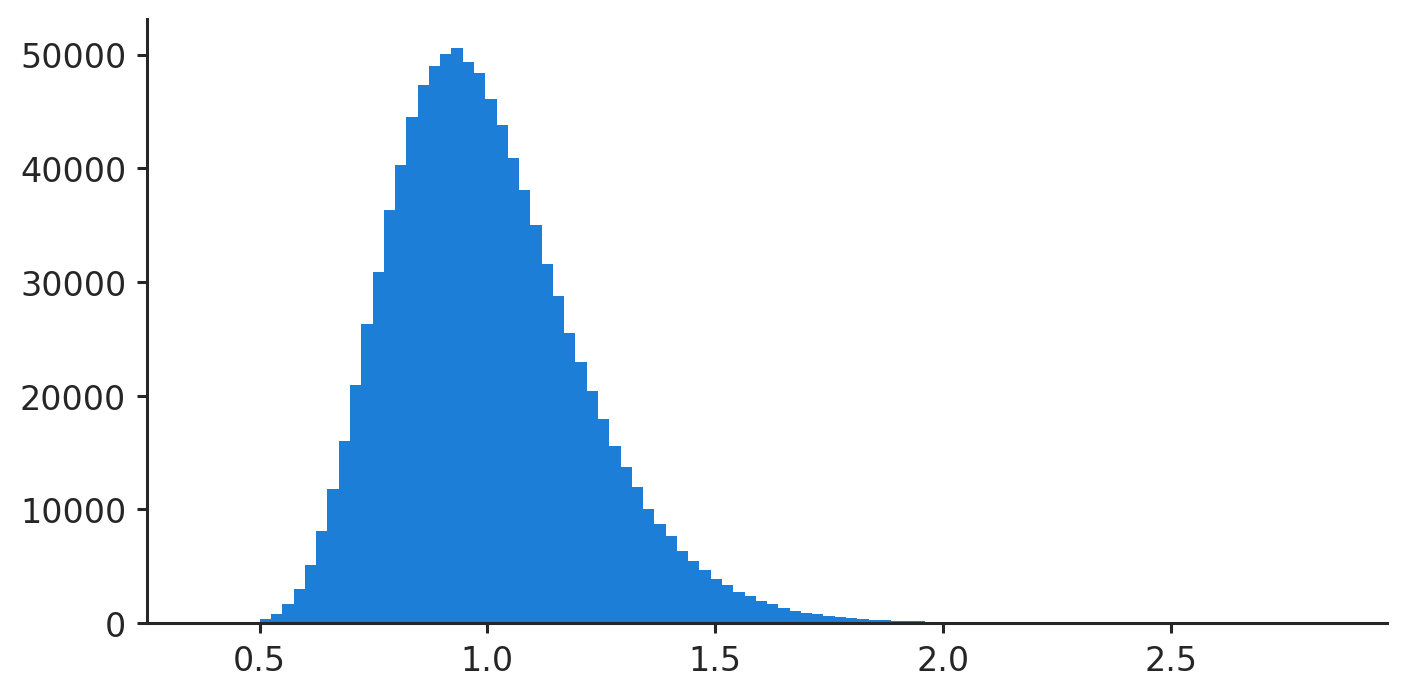

In [43]:
_ = plt.hist(res[(0, 0, 0, 0, 2)][2].func.y, 100)

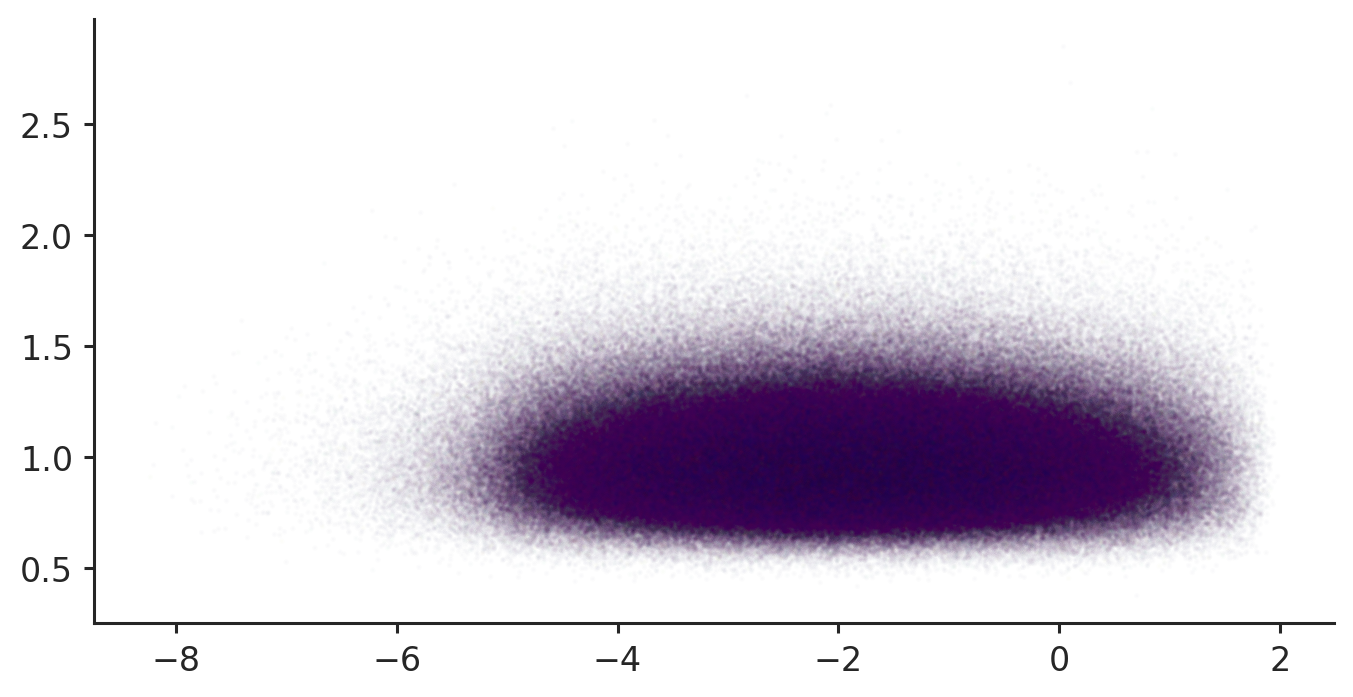

In [33]:
rate = res[(0, 0, 0, 0, 2)][2].func.X[:,2] * res[(0, 0, 0, 0, 2)][2].func.X[:,0]/res[(0, 0, 0, 0, 2)][2].func.X[:,1]
_ = plt.scatter(np.log10(rate), res[(0, 0, 0, 0, 2)][2].func.y, c=res[(0, 0, 0, 0, 2)][2].func.X[:,3], s=1, alpha=0.01)

In [34]:
len(rate)

1000000

/home/vsb/projects/bprime/bgspy/plots.py:94: RuntimeWarning: divide by zero encountered in log10
  rate = np.log10(X[:, Xcols('L')] * X[:, Xcols('mu')] / X[:, Xcols('sh')])


(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:title={'center':'\ntheory MAE=0.1139, MSE=0.0887'}, xlabel='predicted', ylabel='theory'>)

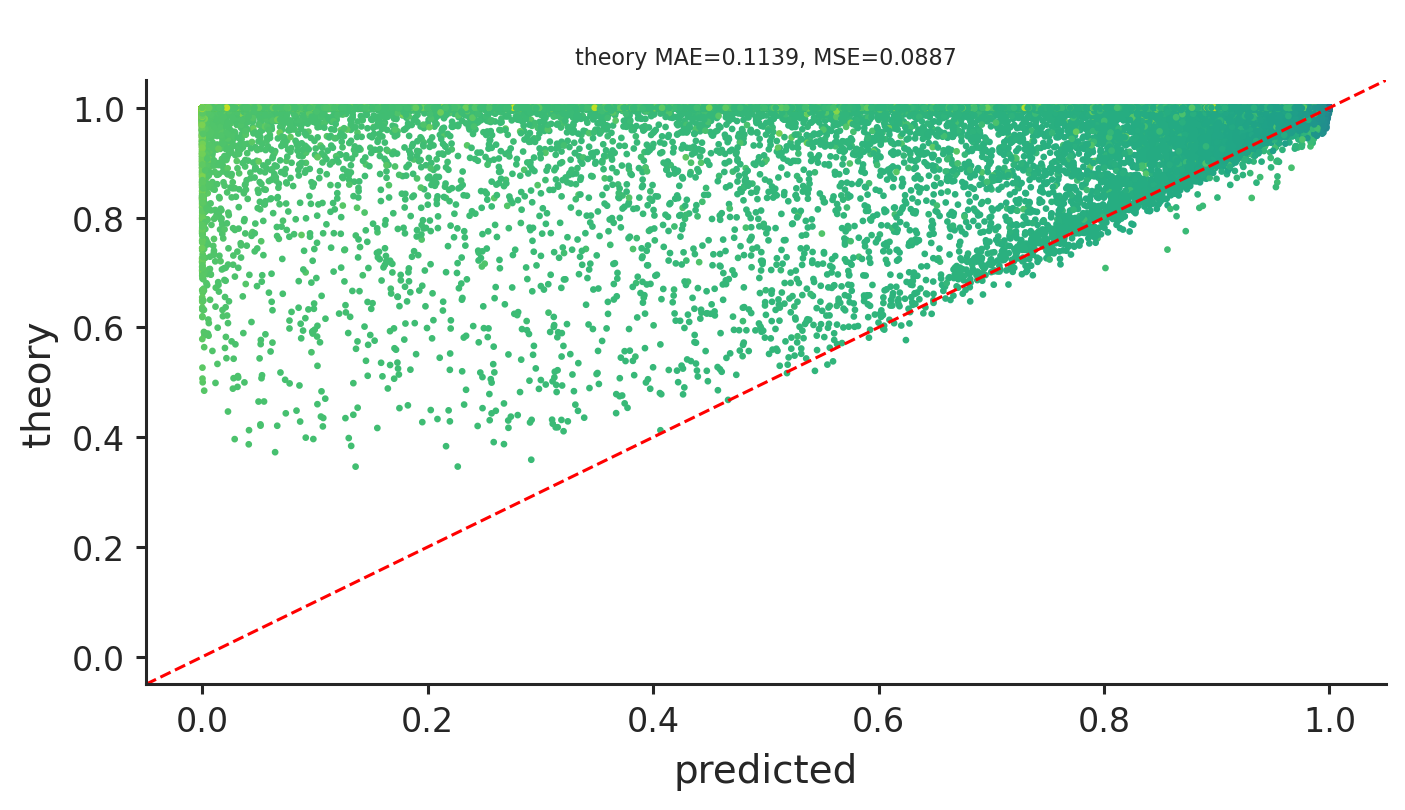

In [11]:
theory_loss_plot(segmodel[(0, 0, 0, 0, 2)][2], s=2)

In [13]:
def func():
    a = 0
    def foo():
        a += 1
        print(a)
    return foo
b = func()
b()

UnboundLocalError: local variable 'a' referenced before assignment

In [37]:
func = segmodel[(0, 0, 0, 0, 2)][0].func

In [51]:
(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = func.predict_grid(None, #{'mu': 101, 'sh': 100}, 
                                                                            manual_domains={'mu': (-9, -7, 101, True),
                                                                                                  'sh': (-4, -2, 100, True)}, 
                                                                            fix_X={'rf': 1e-8,
                                                                                   'rbp': 1e-8,
                                                                                    'L': 500})
func.features                                                                     

done.
316/316 [==============================] - 0s 939us/step


{'mu': 0, 'sh': 1, 'L': 2, 'rbp': 3, 'rf': 4}

In [52]:
Zp = predict_grid.squeeze()
Z = segmodel[(0, 0, 0, 0, 2)][2].theory_B(X_mesh_raw).reshape(Zp.shape)

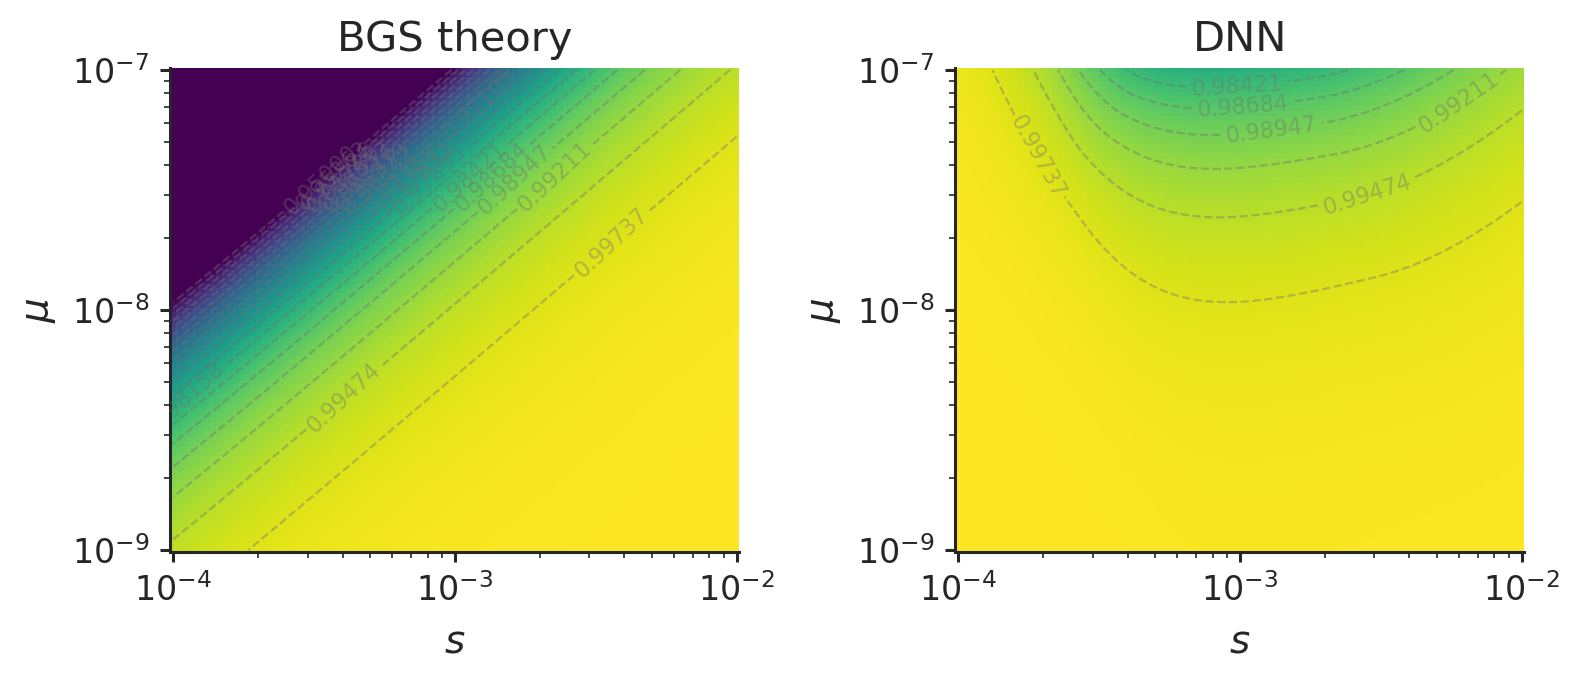

In [53]:
cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')
norm = mpl.colors.Normalize(vmin=0.95, vmax=1, clip=True)

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ncontour = np.linspace(0.95, 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

In [44]:
func = segmodel[(0, 0, 0, 0, 2)][2].func

In [45]:
(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = func.predict_grid(None, #{'mu': 101, 'sh': 100}, 
                                                                            manual_domains={'mu': (-9, -7, 101, True),
                                                                                                  'sh': (-4, -2, 100, True)}, 
                                                                            fix_X={'rf': 1e-8,
                                                                                   'rbp': 1e-8,
                                                                                    'L': 500})
func.features                                                                     

done.
316/316 [==============================] - 0s 936us/step


{'mu': 0, 'sh': 1, 'L': 2, 'rbp': 3, 'rf': 4}

In [46]:
Zp = predict_grid.squeeze()
Z = segmodel[(0, 0, 0, 0, 2)][2].theory_B(X_mesh_raw).reshape(Zp.shape)

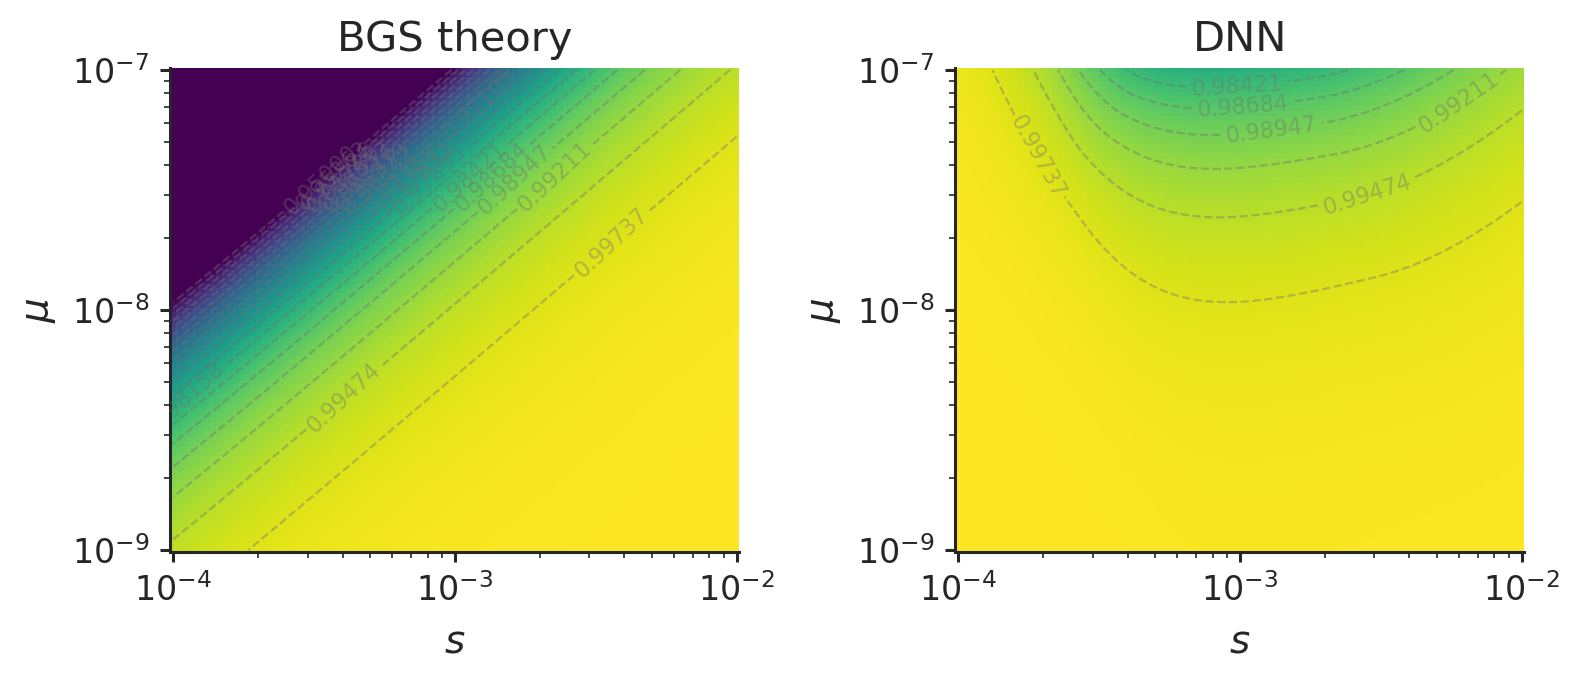

In [47]:
cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')
norm = mpl.colors.Normalize(vmin=0.95, vmax=1, clip=True)

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ncontour = np.linspace(0.95, 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

In [54]:
segmodel[(0, 0, 0, 0, 2)][0].predict

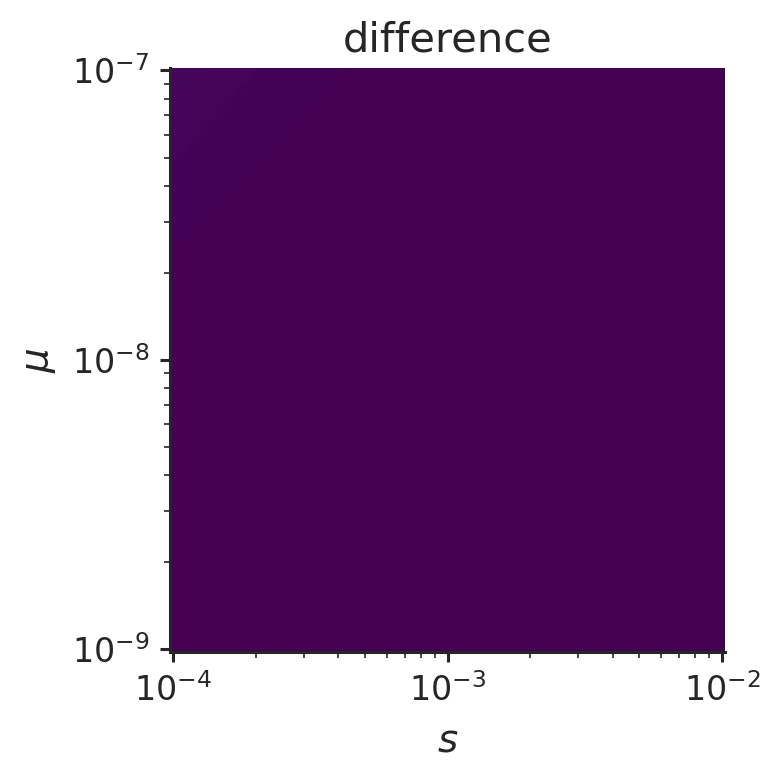

In [26]:
cmap = mpl.cm.get_cmap('viridis', 1000)
norm = mpl.colors.Normalize(vmin=0, vmax=0.6, clip=True)

fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
ncontour = np.linspace(0., 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Zp.T - Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm,
             cmap=cmap,
             ncontour=ncontour, figax=(fig, ax))
#ncontour = np.linspace(0.99, 1, 30)
ax.set_title("difference")
plt.tight_layout()

## Old stuff below this point

In [262]:
x = (Zp.T - Z.T)
x.min(), x.max()

(-0.00734692334980358, 0.9998438612487731)

(array([5490., 1155.,  642.,  463.,  372.,  311.,  291.,  286.,  319.,
         771.]),
 array([-0.00734692,  0.09337216,  0.19409123,  0.29481031,  0.39552939,
         0.49624847,  0.59696755,  0.69768663,  0.7984057 ,  0.89912478,
         0.99984386]),
 <BarContainer object of 10 artists>)

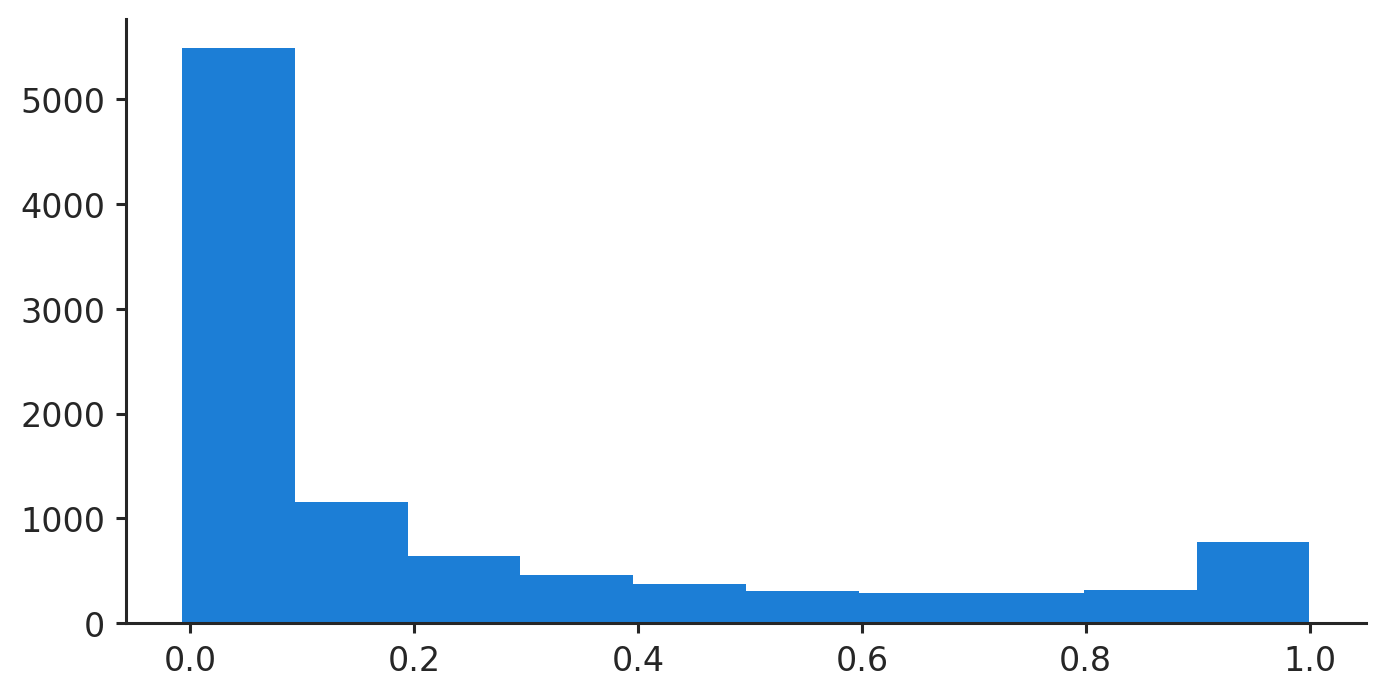

In [264]:
plt.hist(x.flatten())

In [233]:
Zp.min(), Zp.max(), Z.min(), Z.max()

(0.9962016, 0.9999993, 0.4068652151658957, 0.9999900099598801)

(array([ 0.05341737,  0.10516545,  0.14689778,  0.18696081,  0.25039394,
         0.32050424,  0.45237838,  0.69275655,  1.33543432, 13.31594948]),
 array([0.40686522, 0.46617769, 0.52549017, 0.58480265, 0.64411513,
        0.70342761, 0.76274009, 0.82205257, 0.88136505, 0.94067753,
        0.99999001]),
 <BarContainer object of 10 artists>)

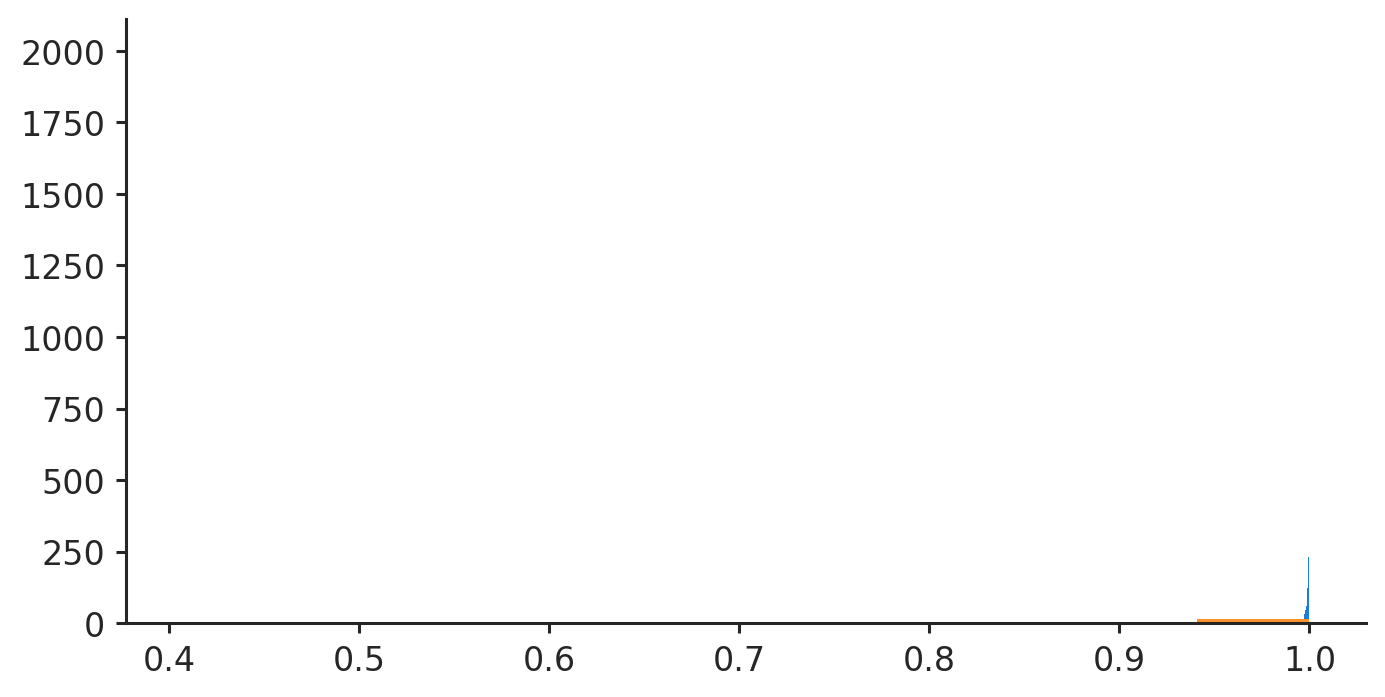

In [144]:
plt.hist(Zp.flatten(), density=True)
plt.hist(Z.flatten(), density=True)

In [143]:
Zp.shape, Z.shape

((100, 101), (100, 101))

In [32]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X_mesh_orig[:, 1], 10**X_mesh_orig[:, 0], 10**X_mesh_orig[:, 2], X_mesh_orig[:, 3],  X_mesh_orig[:, 4]).reshape(predict_grid.shape).squeeze()
Zp = predict_grid.squeeze()

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

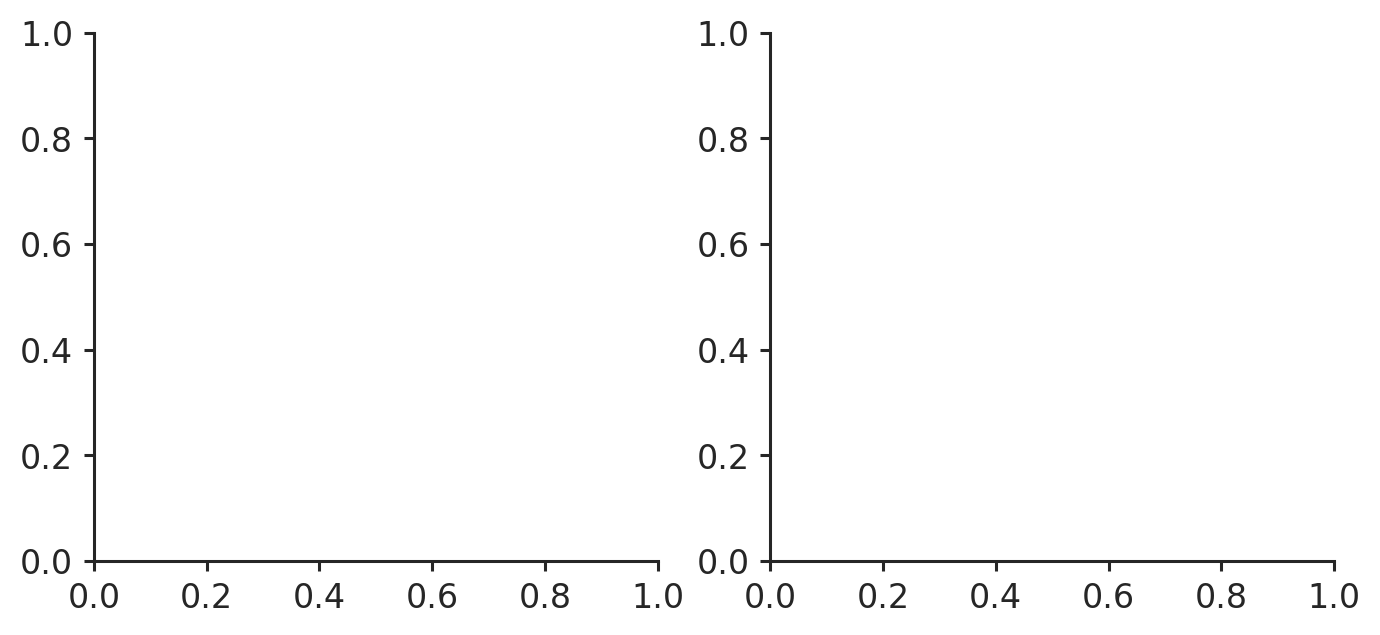

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

TypeError: Dimensions of C (100, 101) are incompatible with X (100) and/or Y (101); see help(pcolormesh)

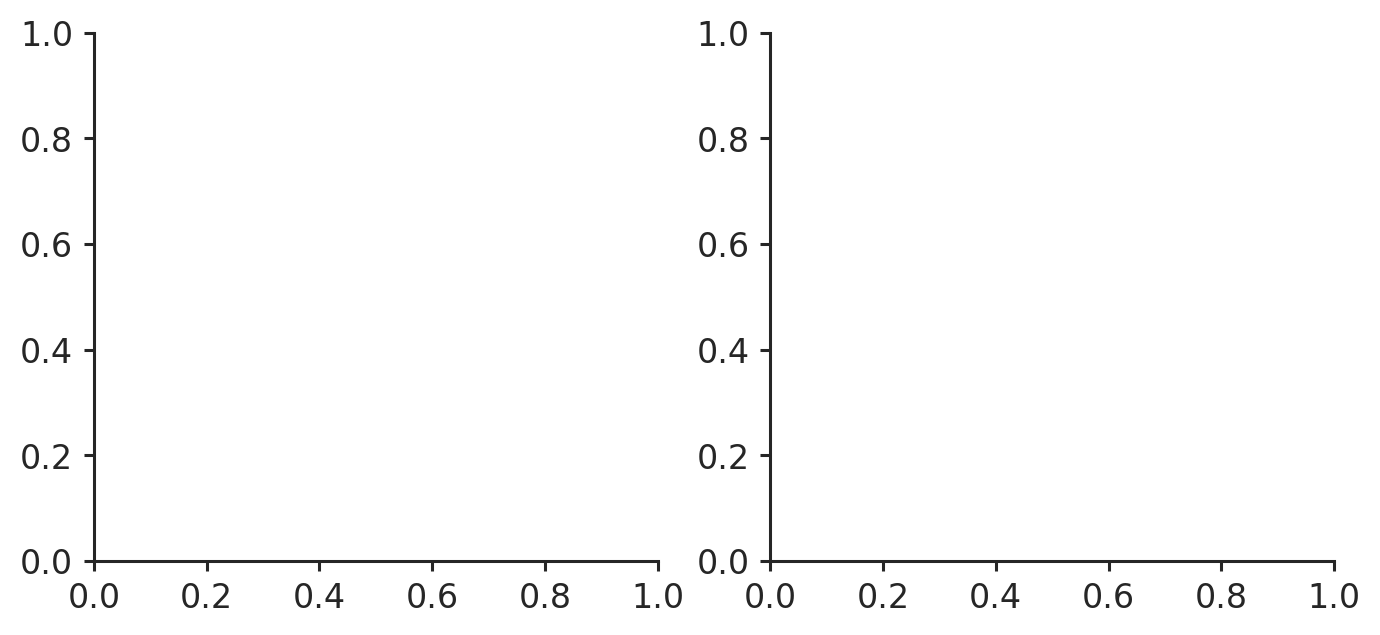

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

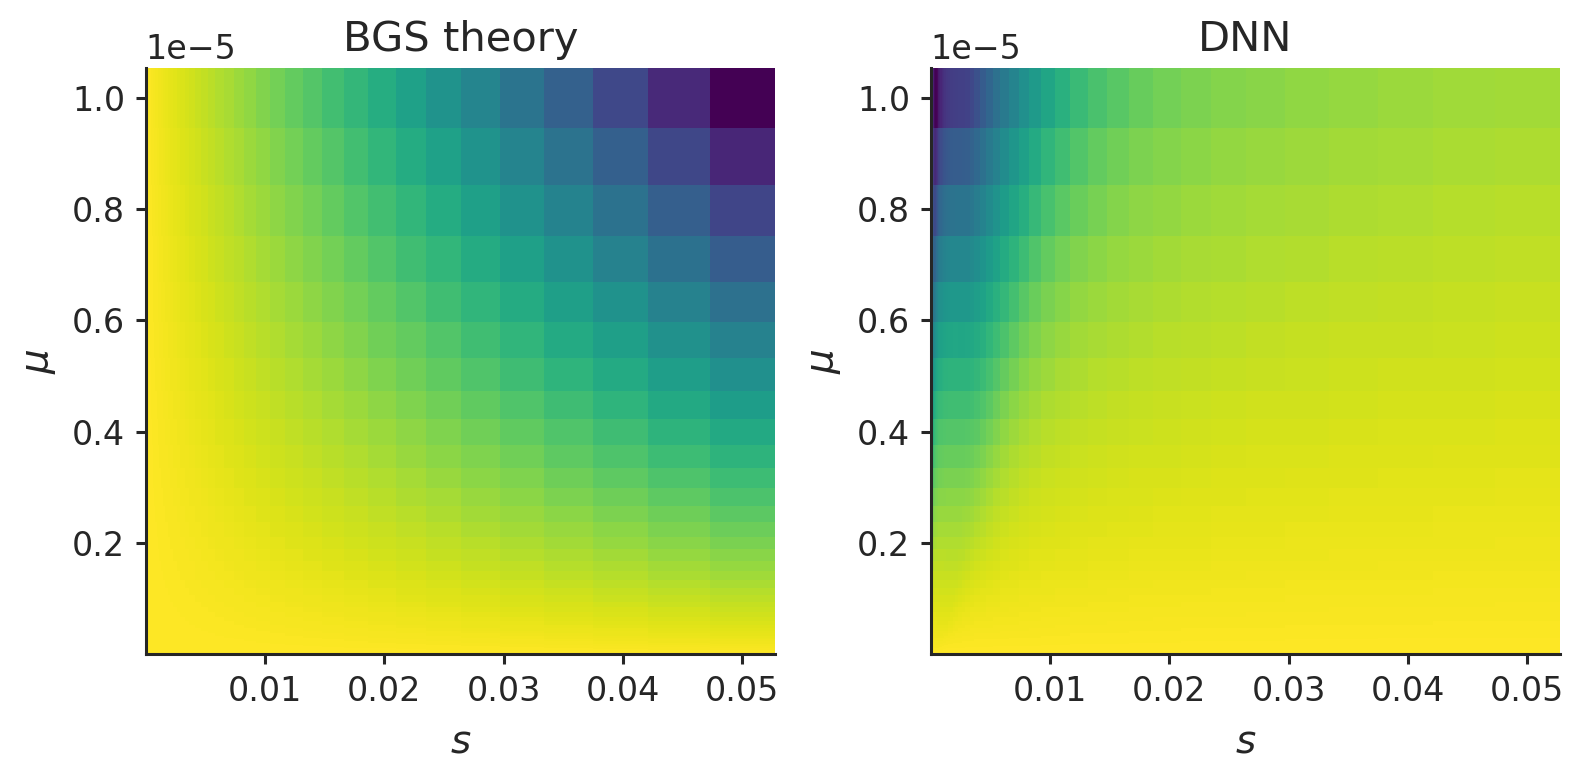

In [74]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z.T, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp.T, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

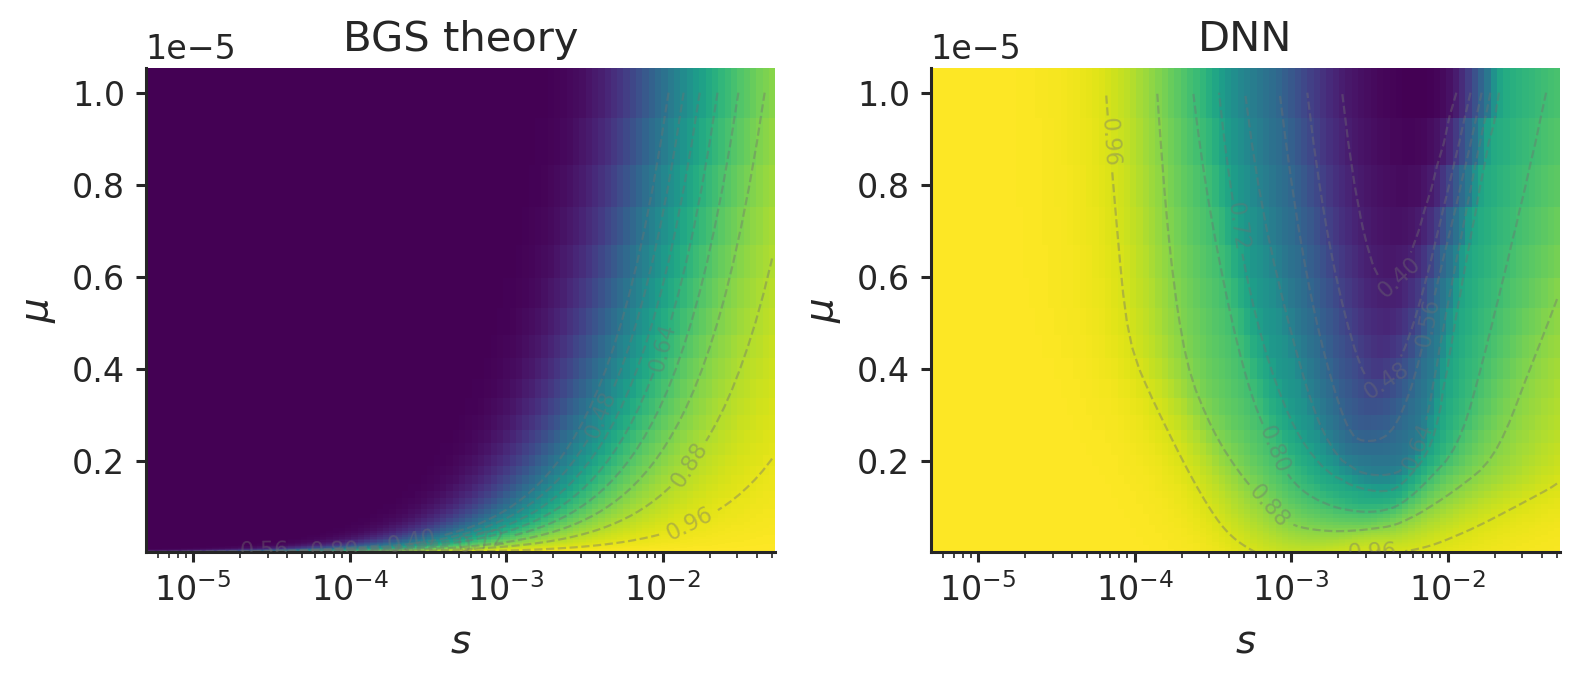

In [34]:

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout() 


(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot:xlabel='$s$', ylabel='$\\mu$'>)

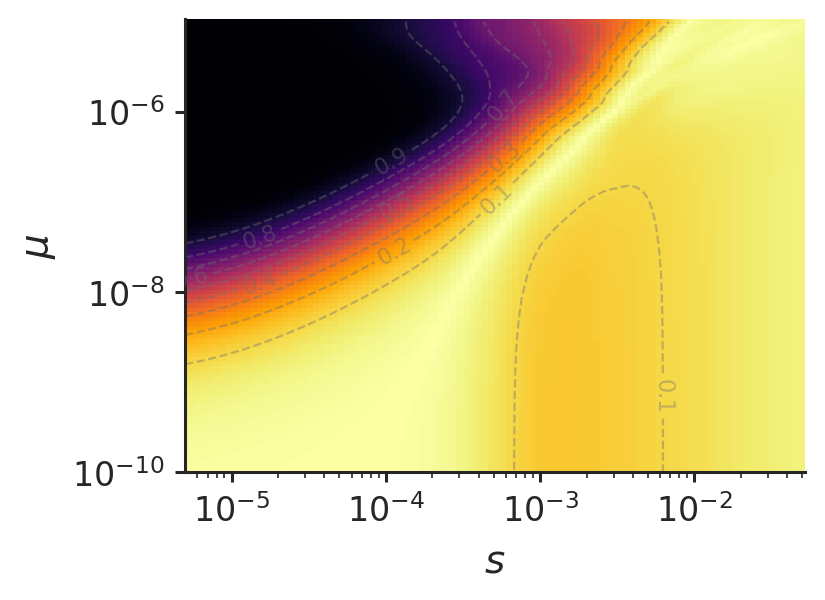

In [34]:
Zdiff = np.abs(Z-Zp)
figax = plt.subplots(figsize=(4, 3))
surface_plot(s_grid, mu_grid, Zdiff, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=10, cmap='inferno_r', figax=figax)


### Interpolation

In [ ]:
20**2 * 50**2 * 40 / 1e6

In [ ]:
# Note that the training data does not log10 mu, but here we do 
(s_grid, mu_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 20, 'sh': 20, 'rf': 50, 'rbp': 40, 'L': 50})

In [ ]:
plt.imshow(predict_grid[:, :, 0, 10, 10])

In [36]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
bs = []
ys = []
for sh in np.logspace(-5, -1,  20):
    (mu_grid_rbp, s_grid_rbp, a, b, c), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'rf': 100},
                                                                            fix_X={'mu': 1e-5, 
                                                                                   'sh': np.log10(sh),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            )
    bs.append(a)
    ys.append(predict_grid_rbp)


making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 g

In [57]:
plt.cm.viridis(0)

(0.267004, 0.004874, 0.329415, 1.0)

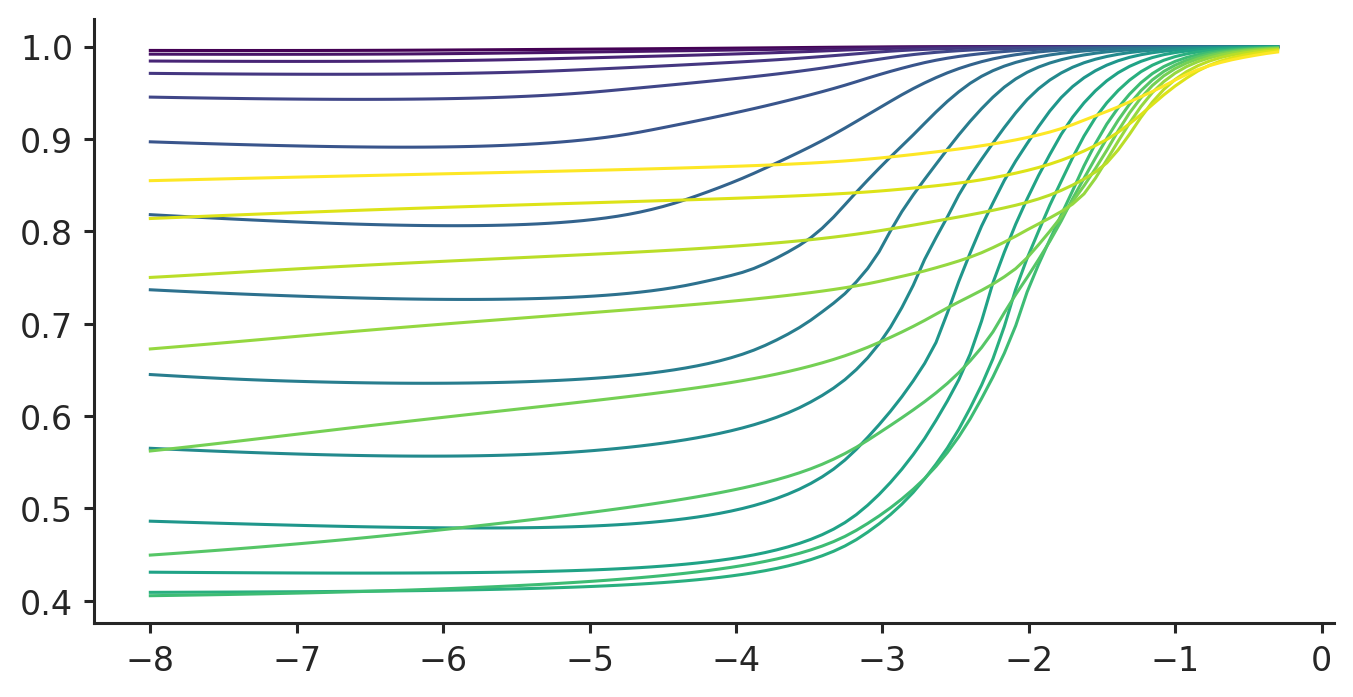

In [58]:
cmap = cm.viridis(np.linspace(0, 1, 20))
for i, y in enumerate(ys):
    plt.plot(np.log10(bs[0]), y.squeeze(), c=cmap[i])

In [62]:
from scipy.interpolate import interpn

In [63]:
(mu_grid, sh_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'mu': 50, 'sh': 50, 'rf': 50, 'rbp': 50, 'L': 50}, log10=('sh', 'rf'))


/home/vsb/projects/bprime/notebooks/../bprime/learn.py:272: RuntimeWarning: invalid value encountered in log10
  lower = np.log10(lower)
/home/vsb/projects/bprime/notebooks/../bprime/learn.py:273: RuntimeWarning: invalid value encountered in log10
  upper = np.log10(upper)


making 50x50x50x50x50 grid...	done.


2022-04-04 19:26:10.167892: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6250000000 exceeds 10% of free system memory.
2022-04-04 19:26:25.581807: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.82GiB (rounded to 6250000128)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-04 19:26:25.581912: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-04 19:26:25.581956: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 51, Chunks in use: 50. 12.8KiB allocated for chunks. 12.5KiB in use in bin. 4.3KiB client-requested in use in bin.
2022-04-04 19:26:25.581989: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
interpnkk

In [ ]:
idx = Xo[:, 4] < 1
rate = Xo[idx, 3]/Xo[idx, 1]
yy = yo[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [ ]:
X.shape, y.shape


In [ ]:
plt.rcParams['text.usetex'] = True

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = (np.log10(X[:, 0]/X[:, 1]) > -5.3) & (np.log10(X[:, 0]/X[:, 1]) < -1.5)
Xtr = X[idx, :]
ax.scatter(np.log10(Xtr[:, 0]/Xtr[:, 1]), np.log10(Xtr[:, 2]), np.log10(y[idx]), s=2,
           c=np.log10(y[idx]), alpha=0.6, cmap='plasma')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('$\\mu/s$')
ax.set_ylabel('$r$')
ax.set_zlabel('$\\log_{10}(\\hat{B})$')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(-8, -6, 3))
ax.set_yticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_yticks()])
fig.savefig('/home/vsb/B3D.pdf')

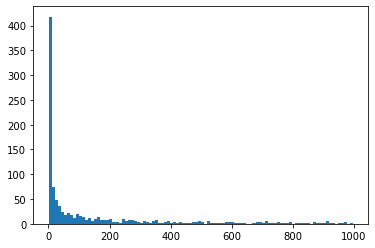

In [33]:
_ = plt.hist(10**np.random.uniform(np.log10(0.5), 3, 1000), 100)

In [34]:
((10**np.random.uniform(np.log10(0.5), 3, 10000)).astype(int) == 1).mean()

0.0906

In [35]:
np.log10(0.5)

-0.3010299956639812